# Банки — Анализ оттока клиентов

## Описание проекта

**Цель проекта**: Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

**Этапы**:

1. Загрузка и знакомство с данными
2. Предобработка данных
    * Исследовать пропущенные значения;
    - Исследовать соответствие типов;
    * Исследовать дубликаты;
    * Проверить корректность наименований колонок;
    * Переименовать колонки;
    * Удалить дубликаты;
    * Заменить пропущенные значения.
3. Исследовательский анализ данных (анализ имеющихся данных, первые выводы.)
4. Выделение отточных сегментов (в ходе данного этапа нужно провести сравнение показателей ушедших клиентов с оставшимися и выделить сегменты)
5. Проверка статистических гипотез (сформулировать и проверить гипотезы появившиеся в ходе работы)
6. Выводы и рекомендации

**Описание данных**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,    
> Кредитный скоринг (от англ. score «оценка»; в т.ч. гл.) — система оценки кредитоспособности (кредитных рисков) лица, основанная на численных статистических методах. [Вики]

[Вики]: https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B5%D0%B4%D0%B8%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BA%D0%BE%D1%80%D0%B8%D0%BD%D0%B3
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Загрузка и знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
try:
    bank = pd.read_csv('bank_dataset.csv')
except:
    bank = pd.read_csv('/datasets/bank_dataset.csv')

In [4]:
bank.sample(5)

userid  score            City Gender  Age  Objects    Balance  \
9431  15641684    523         Рыбинск      Ж   24        5  172231.93   
4213  15614881    767       Ярославль      Ж   34        8        NaN   
2706  15637807    696       Ярославль      М   22        9  149777.00   
3935  15691098    728  Ростов Великий      М   45        3  108924.33   
8239  15796691    639         Рыбинск      М   34        7  149940.04   

      Products  CreditCard  Loyalty  estimated_salary  Churn  
9431         1           0        1         155144.12      0  
4213         2           1        0          94767.77      0  
2706         1           1        1         198032.93      0  
3935         2           1        0          84300.40      1  
8239         2           0        0         156648.81      0

In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


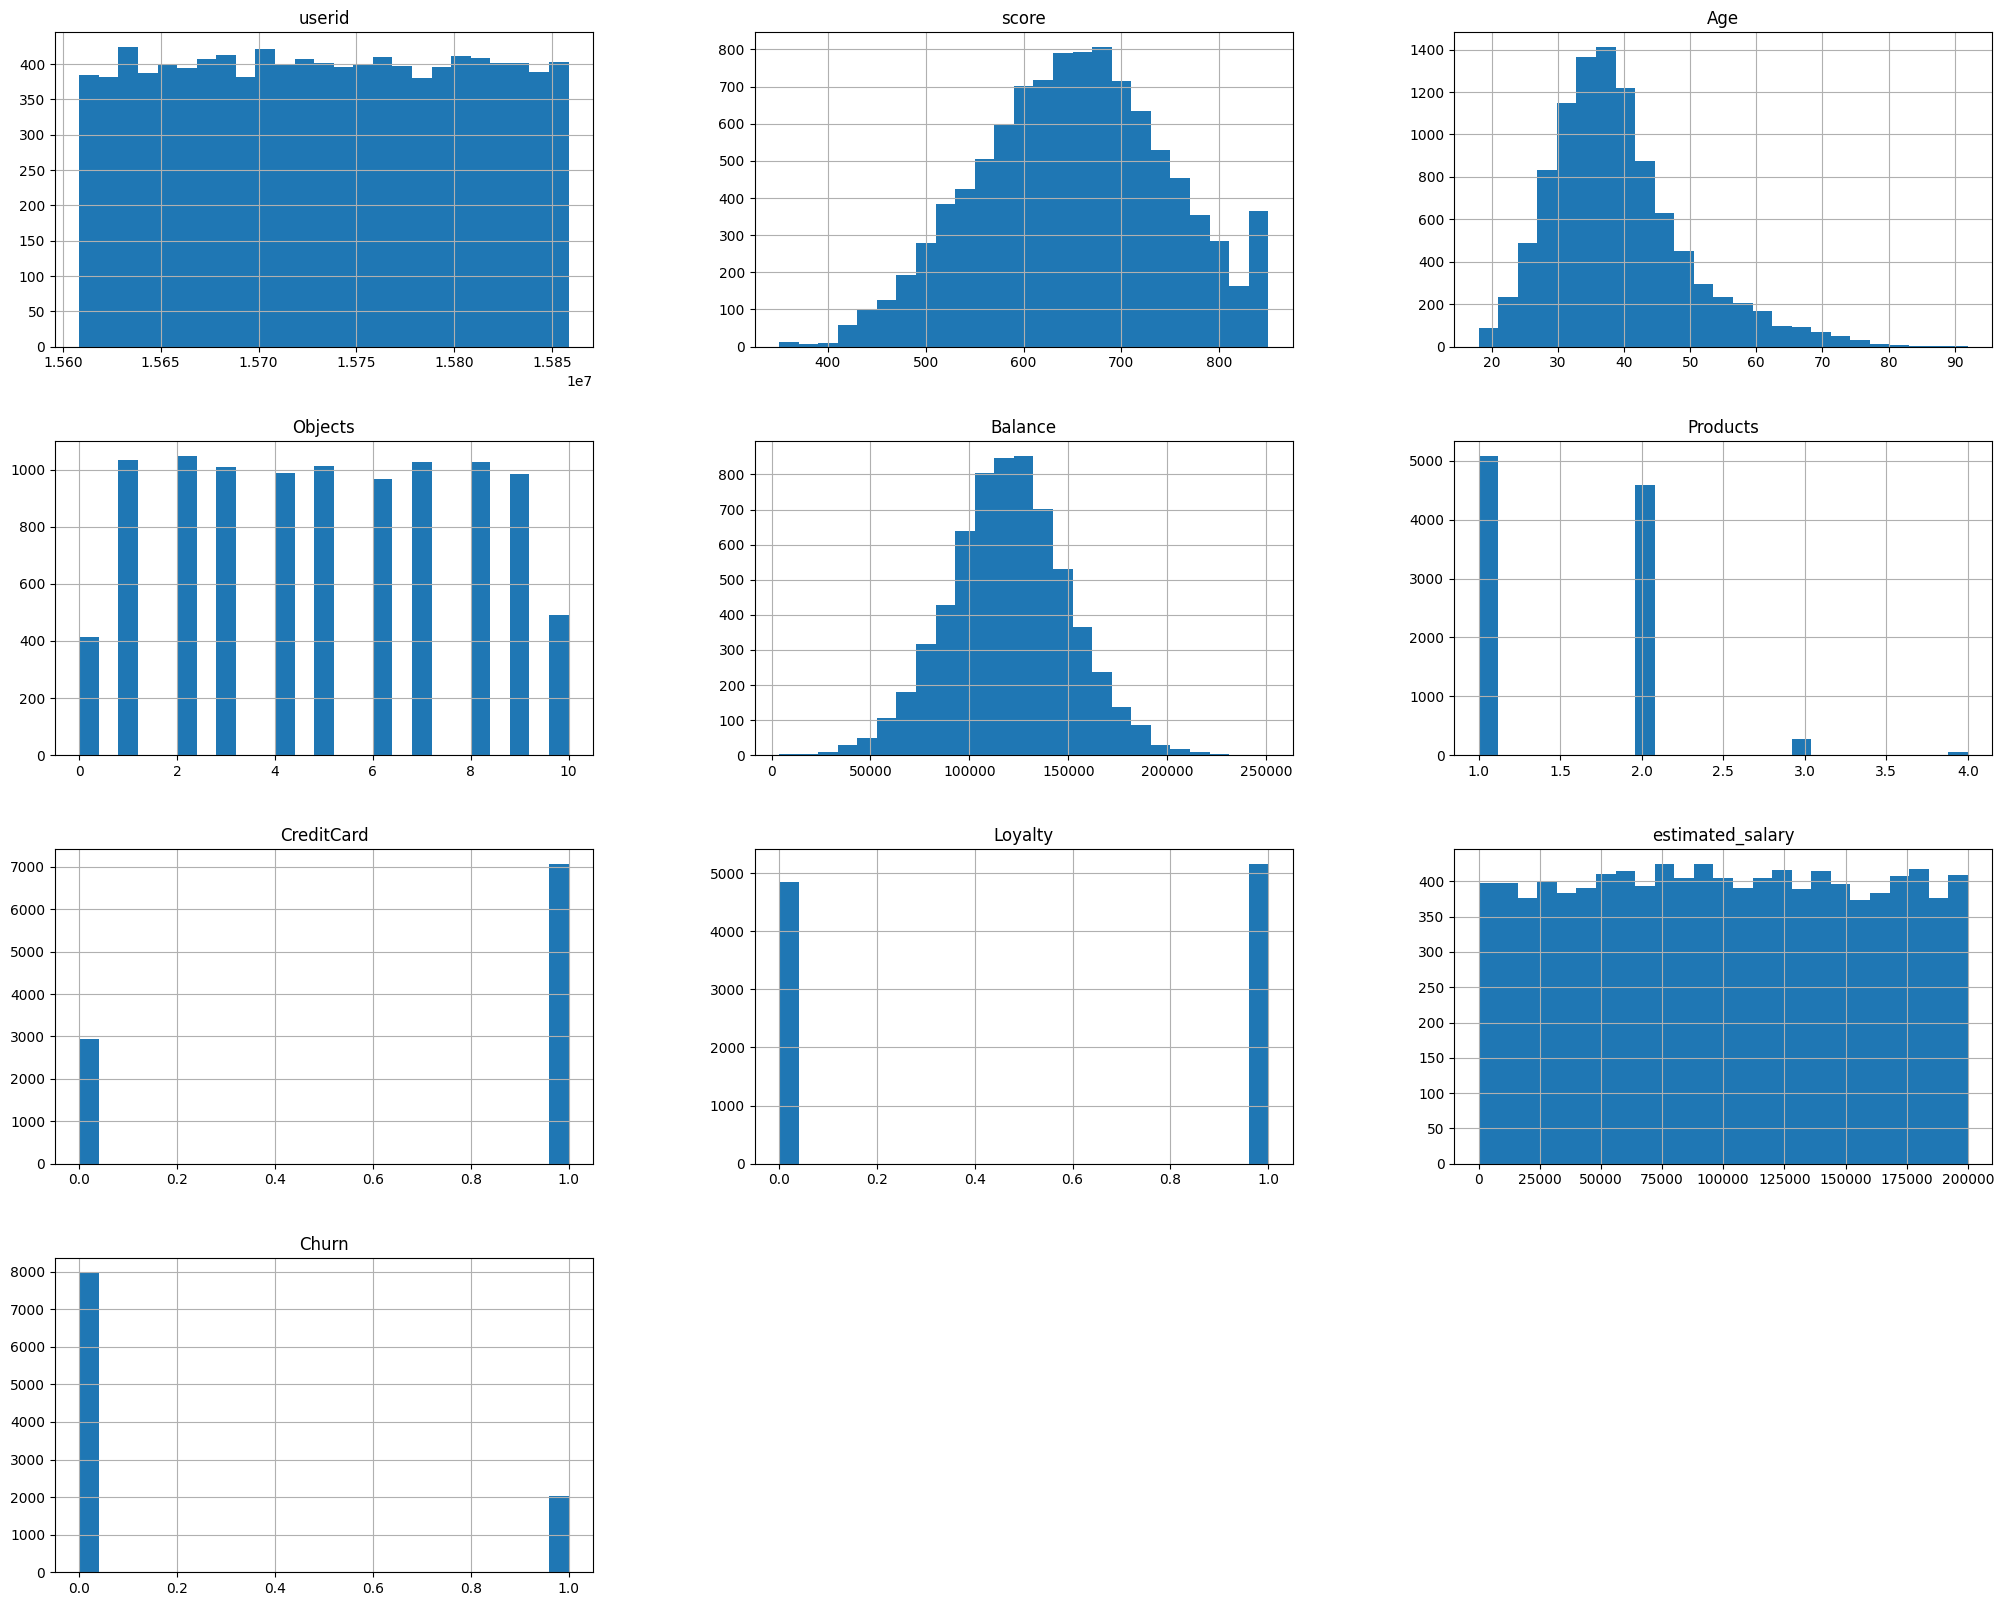

In [6]:
bank.hist(bins= 25, figsize= (25,20))
plt.show();

## Предобработка данных

В рамках предобработки выполним следующие операции:   

* переименуем колонки и значения в колонках
* проверим наличие дубликатов
* найдем столбцы с пропущенными значениями и рассмотрим возможность их заполнения

### Переименование

In [7]:
bank.columns

Index(['userid', 'score', 'City', 'Gender', 'Age', 'Objects', 'Balance',
       'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn'],
      dtype='object')

Понизим регистр и переименуем столбцы для удобства.

In [8]:
bank.columns= bank.columns.str.lower()

In [9]:
bank= bank.rename(
    columns={
        "userid": "user_id",
        "creditcard": "credit_card",
        "estimated_salary": "salary"
    }
)

In [10]:
bank.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'salary', 'churn'],
      dtype='object')

In [11]:
bank.sample(3)

user_id  score       city gender  age  objects    balance  products  \
6321  15731832    590  Ярославль      М   47        0  117879.32         1   
8415  15800767    760    Рыбинск      М   38        3   91241.85         1   
7674  15703607    665  Ярославль      М   28        8  137300.23         1   

      credit_card  loyalty    salary  churn  
6321            1        1   8214.46      0  
8415            0        1  80682.35      0  
7674            1        0  90174.83      0

Создадим копию датафрейма и заменим строковые значения в столбцах `city` и `gender` на численные значения

In [12]:
bank_num= bank.copy()
bank_num['city'] = bank_num['city'].replace({'Ярославль': 1, 'Ростов Великий': 2, 'Рыбинск': 3})
bank_num['gender'] = bank_num['gender'].replace({'М': 0, 'Ж': 1})
bank_num.sample(3)

user_id  score  city  gender  age  objects   balance  products  \
9187  15671599    601     1       0   38        4  60013.81         1   
9350  15732080    615     3       0   42        4       NaN         3   
6043  15803587    629     1       0   31        6       NaN         2   

      credit_card  loyalty     salary  churn  
9187            1        1   38020.05      0  
9350            0        1  120321.09      0  
6043            1        0   93881.75      0

Заменим значения в столбцах `credit_card`, `loyalty`, `churn`.

In [14]:
bank['credit_card'] = bank['credit_card'].replace({0: 'нет', 1: 'есть'})
bank['loyalty'] = bank['loyalty'].replace({0: 'неактивный', 1: 'активный'})
bank['churn'] = bank['churn'].replace({0: 'остался', 1: 'ушел'})

Также, для удобства, в столбцах `Salary` и `balance`, разделим значения на 1000.

In [15]:
bank['salary'] = bank['salary'].div(1000).round(2)
bank_num['salary'] = bank_num['salary'].div(1000).round(2)

In [16]:
bank.sample(3)

user_id  score            city gender  age  objects    balance  \
7652  15612130    704       Ярославль      М   24        2  148197.15   
7647  15717319    768       Ярославль      М   25        0   78396.08   
5154  15633702    729  Ростов Великий      Ж   42        4   97495.80   

      products credit_card     loyalty  salary    churn  
7652         2        есть  неактивный  182.78  остался  
7647         1        есть    активный    8.32  остался  
5154         2         нет  неактивный    2.00  остался

In [17]:
bank['balance'] = bank.query('balance.notna()')['balance'].div(1000).round(2)
bank_num['balance'] = bank_num.query('balance.notna()')['balance'].div(1000).round(2)

### Дубликаты

In [18]:
bank.duplicated().sum()

0

In [19]:
bank.drop(columns= ['user_id']).duplicated().sum()

0

In [20]:
cat_columns= ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']
for c in cat_columns:
    print(sorted(bank[c].unique()), '- уникальные значения в столбце', c)

['Ростов Великий', 'Рыбинск', 'Ярославль'] - уникальные значения в столбце city
['Ж', 'М'] - уникальные значения в столбце gender
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] - уникальные значения в столбце objects
[1, 2, 3, 4] - уникальные значения в столбце products
['есть', 'нет'] - уникальные значения в столбце credit_card
['активный', 'неактивный'] - уникальные значения в столбце loyalty
['остался', 'ушел'] - уникальные значения в столбце churn


Дубликатов нет.

### Пропущенные значения

In [21]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      10000 non-null  int64  
 1   score        10000 non-null  int64  
 2   city         10000 non-null  object 
 3   gender       10000 non-null  object 
 4   age          10000 non-null  int64  
 5   objects      10000 non-null  int64  
 6   balance      6383 non-null   float64
 7   products     10000 non-null  int64  
 8   credit_card  10000 non-null  object 
 9   loyalty      10000 non-null  object 
 10  salary       10000 non-null  float64
 11  churn        10000 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 937.6+ KB


Пропуски имеются только в столбце `balance`

In [22]:
round(bank.balance.isna().mean()*100,1)

36.2

В столбце `balance` 36.2% пропущенных значений. 

In [23]:
bank['balance'].describe()

count    6383.000000
mean      119.827509
std        30.095064
min         3.770000
25%       100.180000
50%       119.840000
75%       139.515000
max       250.900000
Name: balance, dtype: float64

Вероятно, пропущенные значения означают нулевой баланс на счете.

Добавим новый столбец - доступность баланса.

In [24]:
bank['balance_avail']= np.where(bank['balance'].isna(), 'недоступен', 'доступен')

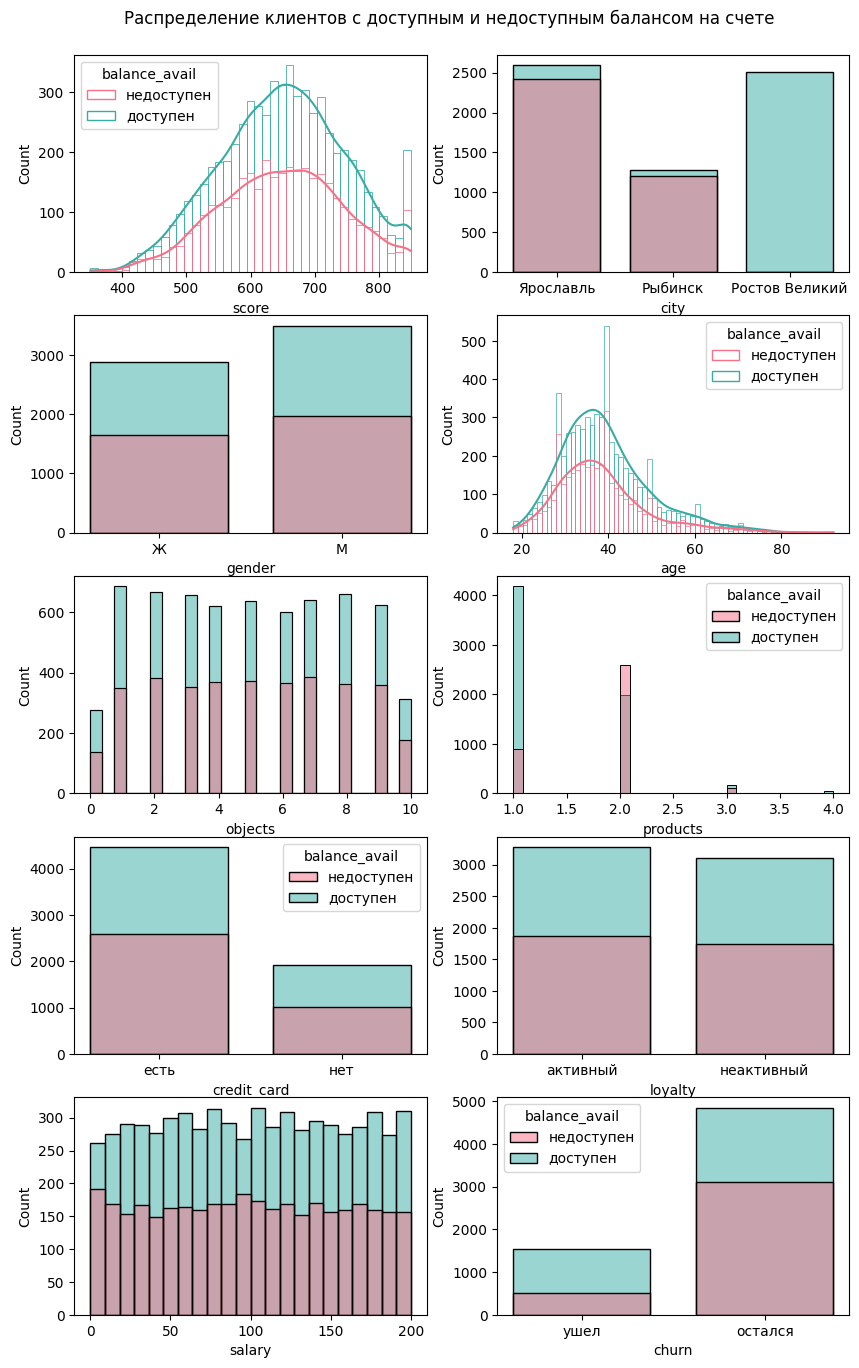

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
fig.suptitle('Распределение клиентов с доступным и недоступным балансом на счете')
#score
sns.histplot(ax= axes[0,0], data= bank, x= 'score', hue= 'balance_avail'
            ,fill= False, kde= True, palette= 'husl')
#city
sns.histplot(ax= axes[0,1], data= bank, x= 'city', hue= 'balance_avail'
             , legend= False, shrink= .75, palette= 'husl')
#gender
sns.histplot(ax= axes[1,0], data= bank, x= 'gender', hue= 'balance_avail'
             , legend= False, shrink= .75, palette= 'husl')
#age
sns.histplot(ax= axes[1,1], data= bank, x= 'age', hue= 'balance_avail'
            ,fill= False, kde= True, palette= 'husl')
#objects
sns.histplot(ax= axes[2,0], data= bank, x= 'objects', hue= 'balance_avail'
             , legend= False, palette= 'husl')
#products
sns.histplot(ax= axes[2,1], data= bank, x= 'products', hue= 'balance_avail'
            , palette= 'husl')
#credit_card
sns.histplot(ax= axes[3,0], data= bank, x= 'credit_card', hue= 'balance_avail'
             , shrink= .75, palette= 'husl')
#loyalty
sns.histplot(ax= axes[3,1], data= bank, x= 'loyalty', hue= 'balance_avail'
             , legend= False, shrink= .75, palette= 'husl')
#salary
sns.histplot(ax= axes[4,0], data= bank, x= 'salary', hue= 'balance_avail'
             , legend= False, palette= 'husl')
#churn
sns.histplot(ax= axes[4,1], data= bank, x= 'churn', hue= 'balance_avail'
             , shrink= .75, palette= 'husl')

fig.subplots_adjust(top=0.95)
plt.show();

Странная картина наблюдается в распределении клиентов по городам - в Ростове нет клиентов с недоступным балансом, в Ярославле и Рыбинске ~50 на 50.   
Также, аномальное распределение наблюдается в распределении клиентов по количеству продуктов - среди клиентов с одним продуктом  ~80% имеют средства на балансе, а среди клиентов с двумя продуктами таких всего 36%. 

По остальным категориям, клиенты с недоступным балансом распределены равномерно относительно клиентов с доступным.   

Рассмотрим такое же распределение, не учитывая клиентов из Ростова.

In [26]:
bank_null_cities = bank.query('city != "Ростов Великий"')

In [27]:
bank_null_cities['city'].unique(), bank_null_cities['products'].unique()

(array(['Ярославль', 'Рыбинск'], dtype=object), array([1, 3, 2, 4]))

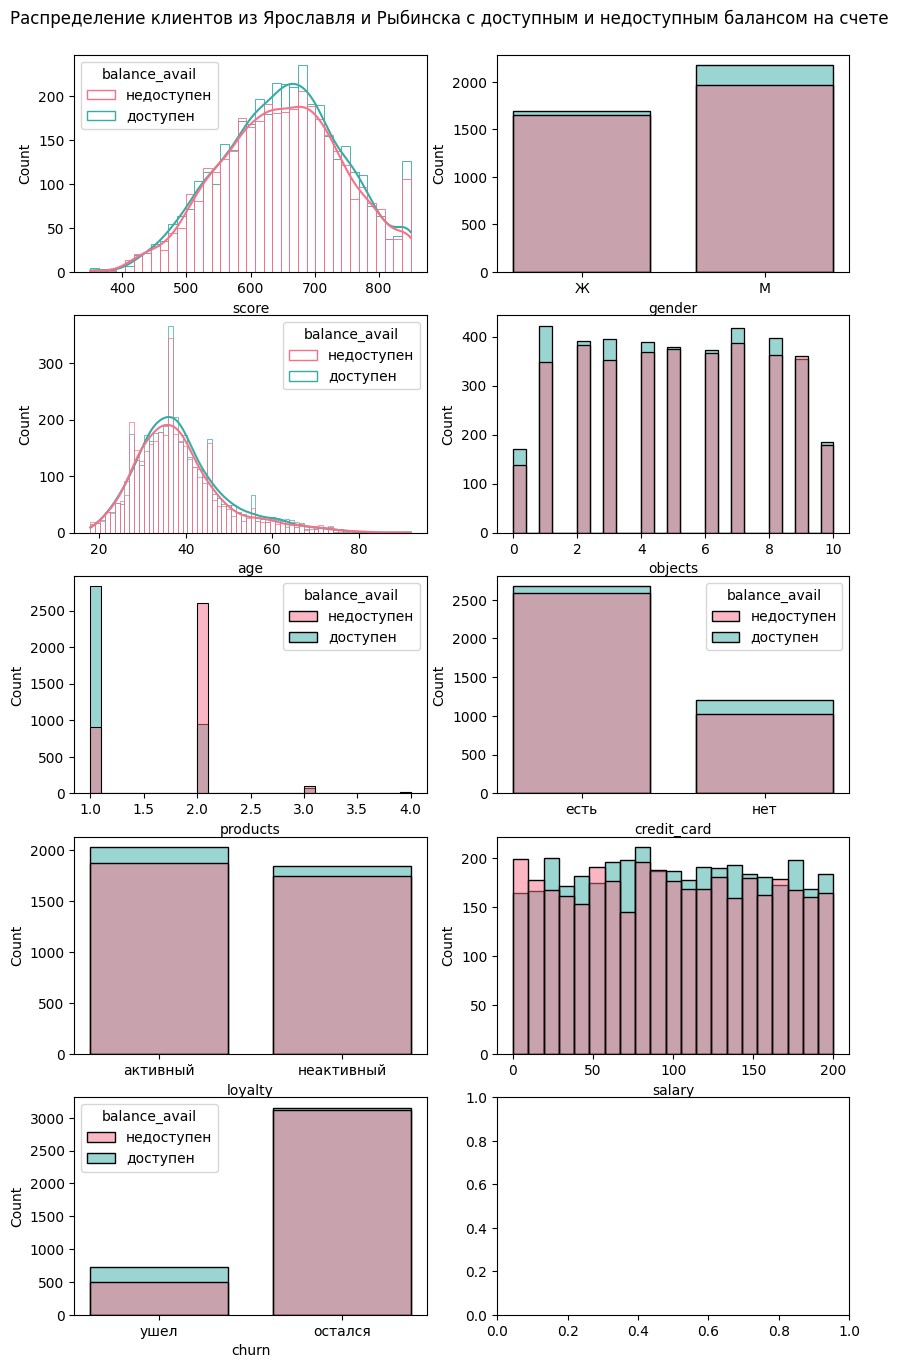

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
fig.suptitle('Распределение клиентов из Ярославля и Рыбинска с доступным и недоступным балансом на счете')
#score
sns.histplot(ax= axes[0,0], data= bank_null_cities, x= 'score', hue= 'balance_avail'
            ,fill= False, kde= True, palette= 'husl')
#gender
sns.histplot(ax= axes[0,1], data= bank_null_cities, x= 'gender', hue= 'balance_avail'
             , legend= False, shrink= .75, palette= 'husl')
#age
sns.histplot(ax= axes[1,0], data= bank_null_cities, x= 'age', hue= 'balance_avail'
            ,fill= False, kde= True, palette= 'husl')
#objects
sns.histplot(ax= axes[1,1], data= bank_null_cities, x= 'objects', hue= 'balance_avail'
             , legend= False, palette= 'husl')
#products
sns.histplot(ax= axes[2,0], data= bank_null_cities, x= 'products', hue= 'balance_avail'
            , palette= 'husl')
#credit_card
sns.histplot(ax= axes[2,1], data= bank_null_cities, x= 'credit_card', hue= 'balance_avail'
             , shrink= .75, palette= 'husl')
#loyalty
sns.histplot(ax= axes[3,0], data= bank_null_cities, x= 'loyalty', hue= 'balance_avail'
             , legend= False, shrink= .75, palette= 'husl')
#salary
sns.histplot(ax= axes[3,1], data= bank_null_cities, x= 'salary', hue= 'balance_avail'
             , legend= False, palette= 'husl')
#churn
sns.histplot(ax= axes[4,0], data= bank_null_cities, x= 'churn', hue= 'balance_avail'
             , shrink= .75, palette= 'husl')

fig.subplots_adjust(top=0.95)
plt.show();

По всем категориям, кроме `products`, распределение клиентов с доступным и недоступным балансом на счете составляет 50 на 50.   
По количеству продуктов - среди клиентов с одним продуктом - у 25% баланс неизвестен, с двумя продуктами - у 75% клиентов баланс неизвестен.

Поскольку недоступный баланс есть только в городах Рыбинск и Ярославль, клиенты с недоступным балансом распределены равномерно по всем категориям, кроме количества продуктов (среди клиентов с одним продуктом - у 25% баланс неизвестен, с двумя продуктами - у 75%), то, вероятнее всего имеет место быть какая то техническая ошибка связанная с продуктом и локацией.

## Исследовательский анализ

### Общие сведения

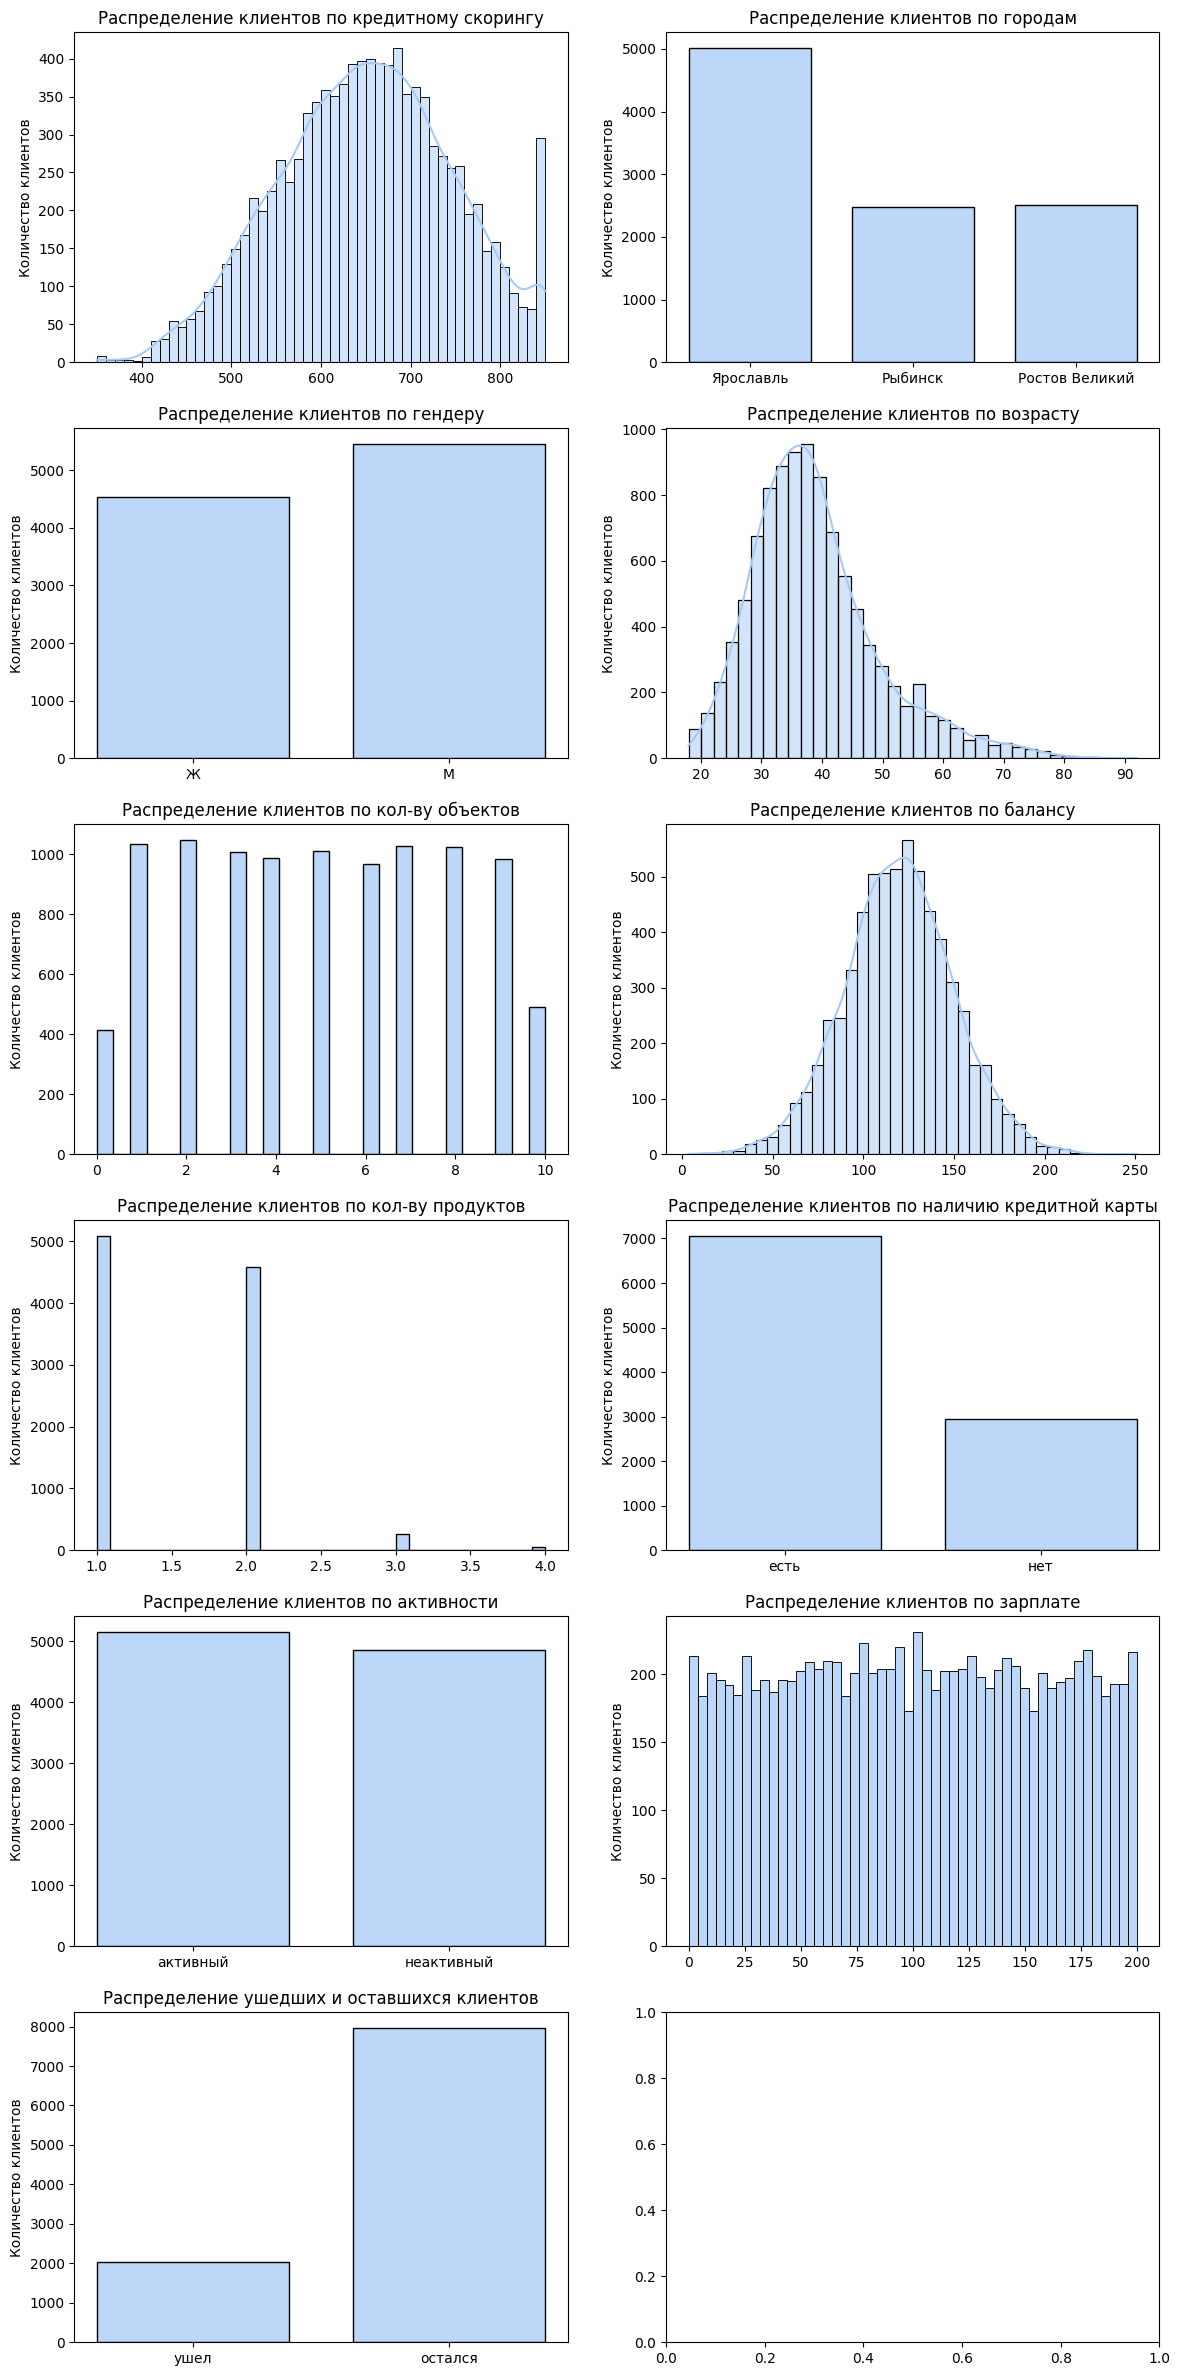

In [29]:
fig, axes = plt.subplots(6, 2, figsize=(14, 30))
axes= axes.flatten()
c= '#a6caf5'
#score
sns.histplot(ax=axes[0], data=bank, x="score",bins= 50, kde= True, color=c)
axes[0].title.set_text('Распределение клиентов по кредитному скорингу')
#city
sns.histplot(ax=axes[1],data= bank, x= 'city', shrink= 0.75, color=c)
axes[1].title.set_text('Распределение клиентов по городам')
#gender
sns.histplot(ax=axes[2],data= bank, x= 'gender', shrink= 0.75, palette= 'Blues_r', color=c)
axes[2].title.set_text('Распределение клиентов по гендеру')
#age
sns.histplot(ax=axes[3],data= bank, x= 'age', bins= 36, kde= True, color=c)
axes[3].title.set_text('Распределение клиентов по возрасту')
#objects
sns.histplot(ax=axes[4],data= bank, x= 'objects', color=c)
axes[4].title.set_text('Распределение клиентов по кол-ву объектов')
#balance
sns.histplot(ax=axes[5],data= bank, x= 'balance', bins= 40, kde= True, color=c)
axes[5].title.set_text('Распределение клиентов по балансу')
#products
sns.histplot(ax=axes[6],data= bank, x= 'products', palette= 'Blues_r', color=c)
axes[6].title.set_text('Распределение клиентов по кол-ву продуктов')
#credit_card
sns.histplot(ax=axes[7],data= bank, x= 'credit_card', shrink= 0.75, palette= 'Blues_r', color=c)
axes[7].title.set_text('Распределение клиентов по наличию кредитной карты')
#loyalty
sns.histplot(ax=axes[8],data= bank, x= 'loyalty', shrink= 0.75, palette= 'Blues_r', color=c)
axes[8].title.set_text('Распределение клиентов по активности')
#salary
sns.histplot(ax=axes[9], data=bank, x="salary",bins= 50, color=c)
axes[9].title.set_text('Распределение клиентов по зарплате')
#churn
sns.histplot(ax=axes[10],data= bank, x= 'churn', shrink= 0.75, palette= 'Blues_r', color=c)
axes[10].title.set_text('Распределение ушедших и оставшихся клиентов')

for c in range(11):
    axes[c].set_xlabel('')
    axes[c].set_ylabel('Количество клиентов')


**Вывод**
* `score` - Распределение похоже на нормальное. Большая часть значений сосредоточилась в интервале от 600 до 700. Скопление значений у верхней границы обусловлено техническим ограничением.
* `city` - 50% клиентов из Ярославля, по 25% из Рыбинска и Ростова.
* `gender` - Женщин среди клиентов на 10% меньше, чем мужчин.
* `age` - Возраст половины клиентов расположен в интервале 32-44 года. Чем больше возраст, тем меньше клиентов.
* `objects` - Распределение клиентов по количеству объектов довольно равномерно - 90% клиентов имеют в собственности от 1 до 9 объектов. 5% не имеют объектов в собственности и у оставшихся 5% - 10 объектов в собственности.
* `balance` - Получили нормальное распределение. 50% процентов клиентов имеют на балансе от 100 до 140 тыс.рублей.
* `products` - 50% клиентов пользуются только одним продуктом банка, 45% - двумя, 4% - тремя и 1% - четырьмя продуктами.
* `credit_card` - 70% клиентов являются обладателями кредитной карты.
* `salary` - Клиенты равномерно распределены по заработной плате от 0 до 200 тыс.рублей.
* `churn` - 20% клиентов ушло, 80% - осталось.

### Матрица корреляции

Рассмотрим связи между величинами среди ушедших и оставшихся клиентов, предварительно убрав заведомо неинформативные столбцы (`user_id`, `objects`,`credit_card` )

In [30]:
bank_distr= bank_num.drop(columns= ['user_id', 'objects','credit_card' ])
bank_distr.columns

Index(['score', 'city', 'gender', 'age', 'balance', 'products', 'loyalty',
       'salary', 'churn'],
      dtype='object')

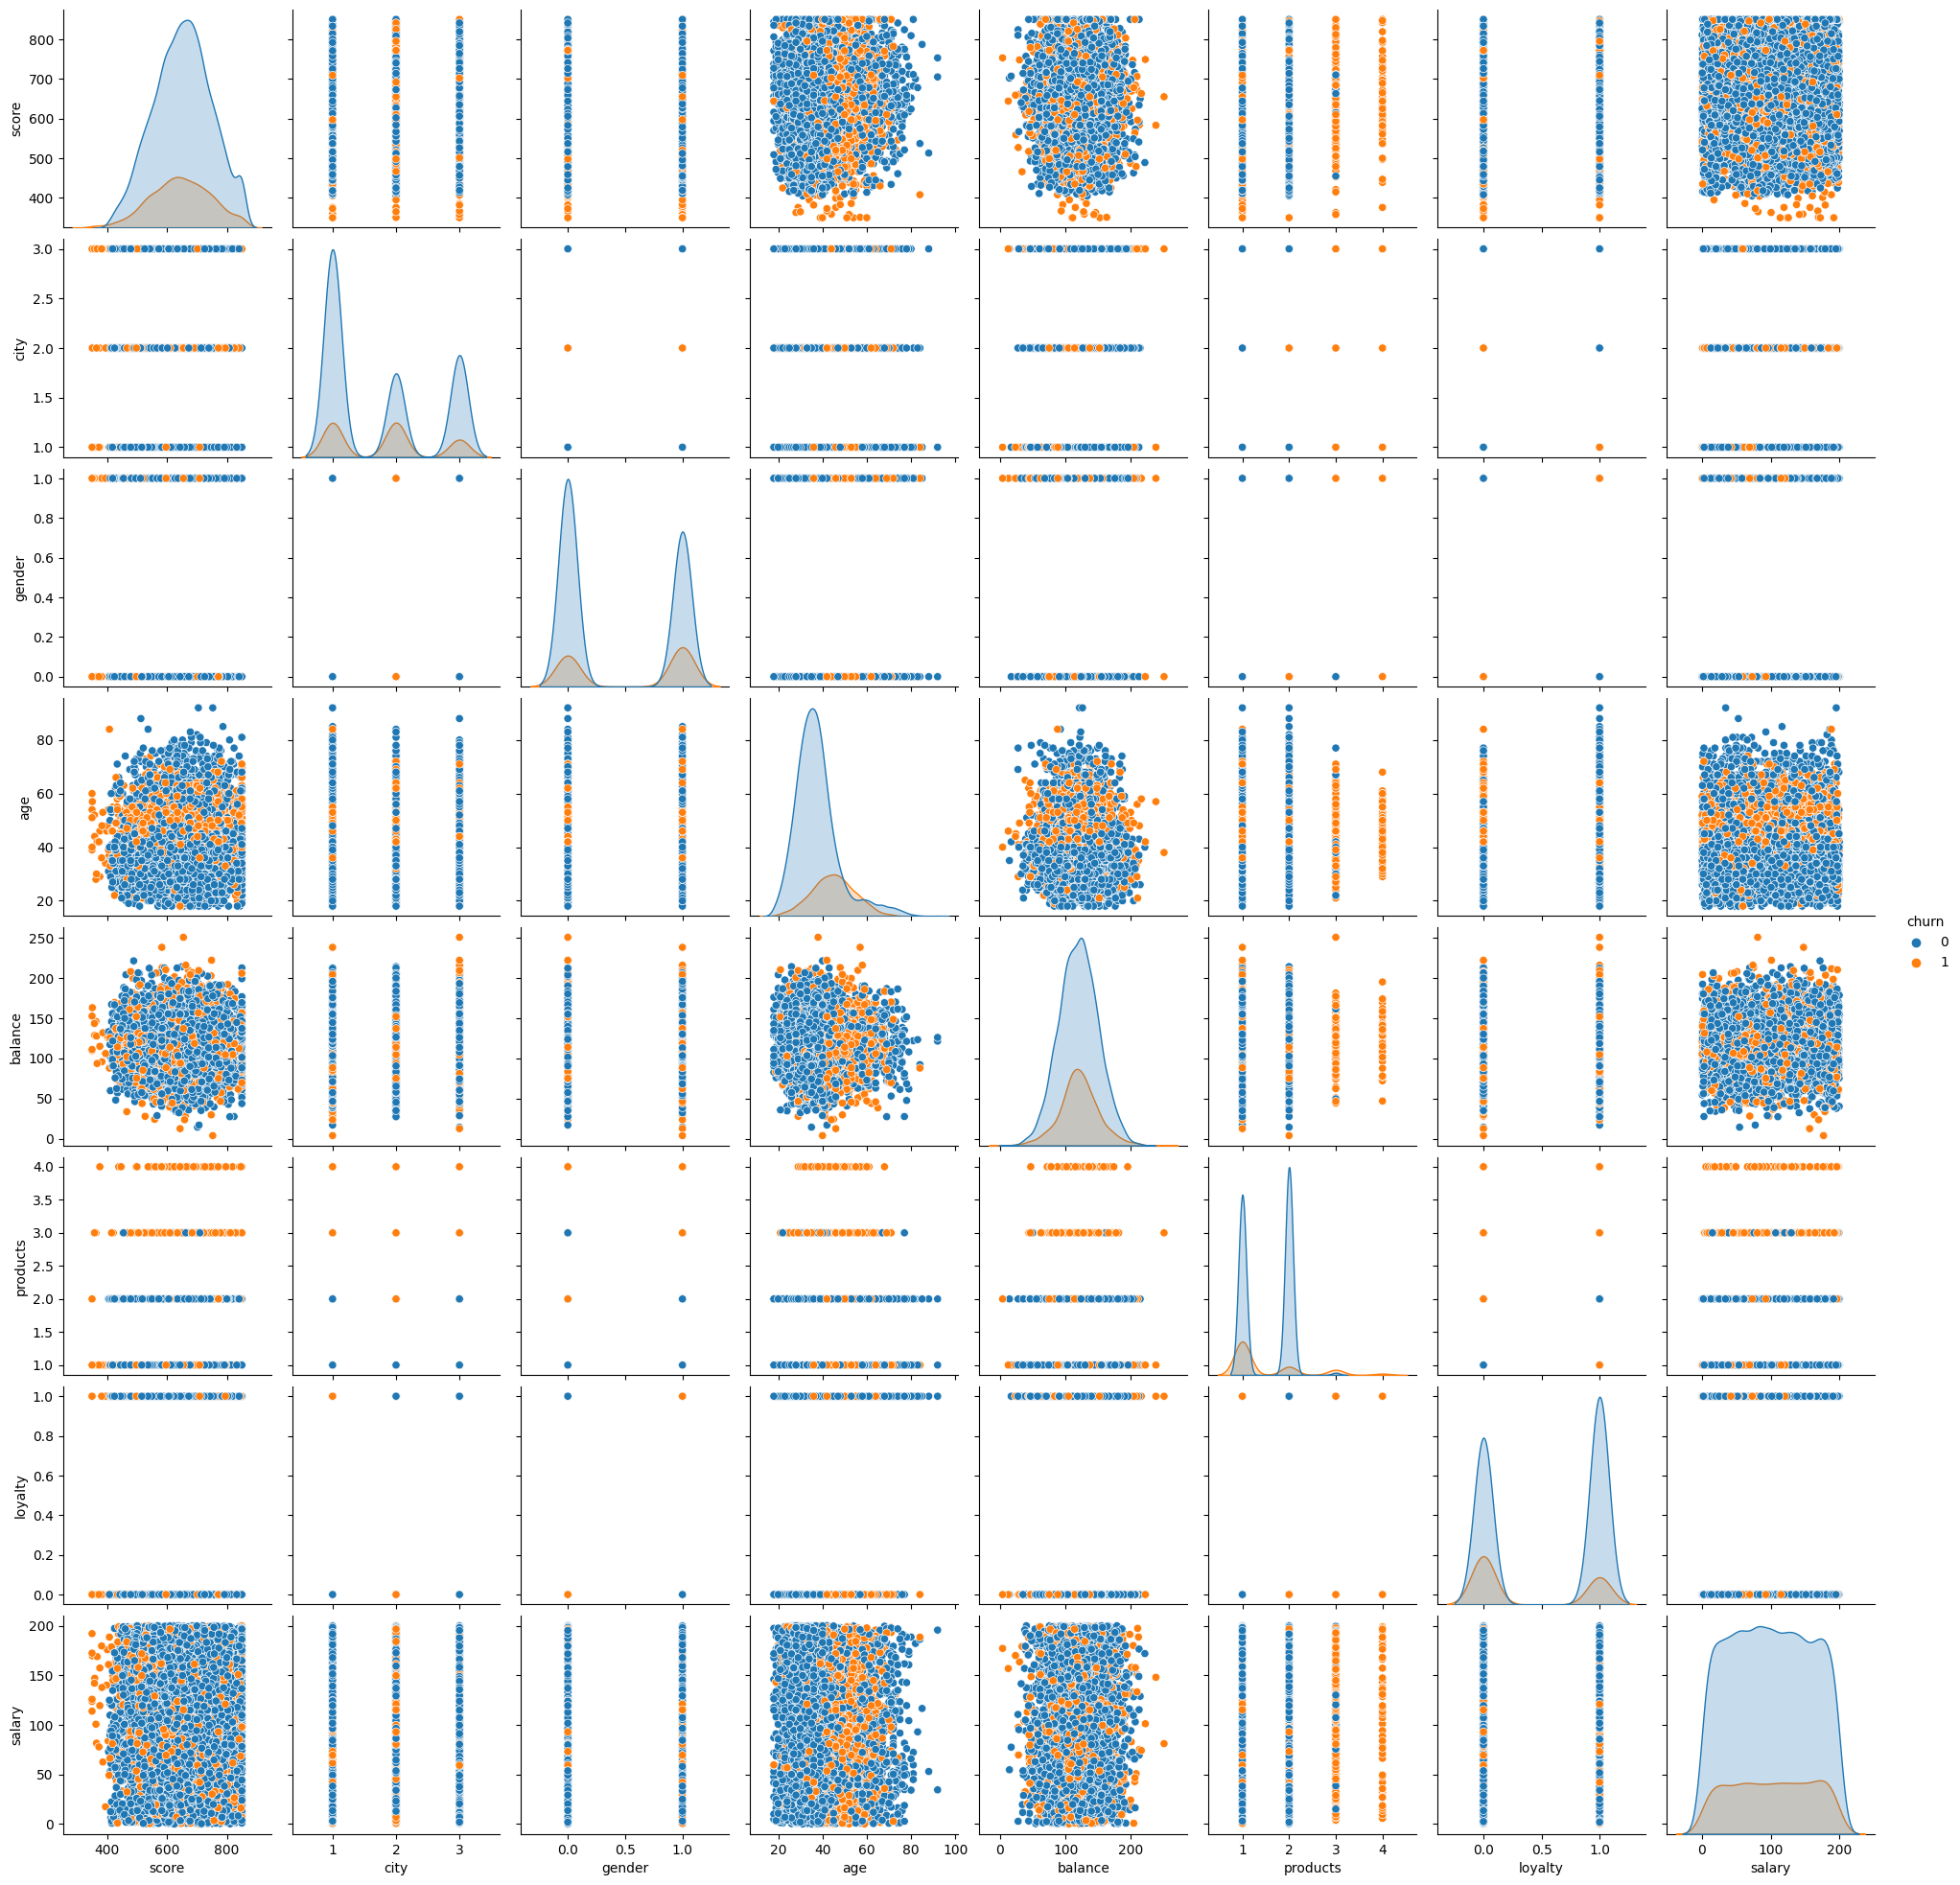

In [31]:
sns.pairplot(bank_distr, hue= 'churn')

Ознакомившись с графиком можно сделать следующие выводы:
* **`score`** - при низких значениях кредитного скоринга (~400) нет оставшихся клиентов, только ушедшие,
* **`city`** - в городе №2 (Ростов Великий) наблюдается больше ушедших клиентов, чем в остальных городах,
* `gender` - ушедших женщин незначительно больше, чем мужчин,
* **`age`** - ярко прослеживается большое количество ушедших клиентов в возрасте от 38 до 65,
* **`products`** среди клиентов с 3 и 4 много ушедших и мало значений ,
* `balance`, `salary` и `loyalty`- ничего особенного не наблюдается

## Выделение отточных сегментов

На основе выводов сделанных в предыдущей главе, разберем каждый из пунктов для выделения отточных сегментов.

Посмотрим, до каких значений скоринга в датасете будут только ушедшие.

In [32]:
#scoring
display(bank.query('score< 405').groupby('churn').agg({'user_id':'count'}))
display(bank.query('score< 406').groupby('churn').agg({'user_id':'count'}))

user_id
churn         
ушел        21

user_id
churn           
остался        1
ушел          22

При значениях скоринга менее 405, нет ни одного оставшегося клиента и 21 ушедший. Вероятно, клиенты с низкими значениями скоринга более склонны к уходу, чем с высокими значениями

Посмотрим, сколько ушедших и оставшихся пользователей с 3 и 4 продуктами.

In [33]:
#3 products
display(bank.query('products == 3').groupby('churn').agg({'user_id':'count'}))
#4 products
bank.query('products == 4').groupby('churn').agg({'user_id':'count'})

user_id
churn           
остался       46
ушел         220

user_id
churn         
ушел        60

Среди клиентов, использующих три банковских продукта всего 46 клиентов остались и 220 клиентов ушло.   
Среди клиентов, использующих четыре банковских продукта нет ни одного оставшегося клиента.

Распределения клиентов по скорингу и по продуктам посмотрим ниже.

Попробуем посмотреть, есть ли корреляция между категориями

In [34]:
bank_to_corr= bank_distr.drop(columns= ['balance', 'loyalty', 'salary'])
bank_to_corr.columns

Index(['score', 'city', 'gender', 'age', 'products', 'churn'], dtype='object')

In [35]:
bank_to_corr.corr()

score      city    gender       age  products     churn
score     1.000000  0.007888  0.002857 -0.003965  0.012238 -0.027094
city      0.007888  1.000000 -0.004719  0.022812  0.003972  0.035943
gender    0.002857 -0.004719  1.000000  0.027544  0.021859  0.106512
age      -0.003965  0.022812  0.027544  1.000000 -0.030680  0.285323
products  0.012238  0.003972  0.021859 -0.030680  1.000000 -0.047820
churn    -0.027094  0.035943  0.106512  0.285323 -0.047820  1.000000

Корреляции нет.

Далее, сравним относительные распределения ушедших и оставшихся клиентов по категориям при независимой нормализации. Но перед этим, разобьем числовые значения в столбцах `score`, `age`, `salary` и `balance` на категории и напишем фнукции для быстрого построения графиков.

### Категоризация

Разобьем столбцы по категориям

In [36]:
# категоризация по значениям скоринга
def categorize_score(score):
    if 350 <= score <= 475:
        return 'A'
    elif 476 <= score <= 600:
        return 'B'
    elif 601 <= score <= 725:
        return 'C'
    elif score >= 726:
        return 'D'
    
bank['score_cat']= bank['score'].apply(categorize_score)
bank.sample(2)

user_id  score       city gender  age  objects  balance  products  \
5940  15834694    849  Ярославль      Ж   41        6      NaN         2   
2832  15800907    582  Ярославль      М   20        4      NaN         1   

     credit_card   loyalty  salary    churn balance_avail score_cat  
5940        есть  активный  169.20     ушел    недоступен         D  
2832        есть  активный   55.76  остался    недоступен         B

In [37]:
# категоризация по возрасту
def categorize_age(age):
    if 18 <= age <= 30:
        return '18-30'
    elif 31 <= age <= 45:
        return '31-45'
    elif 46 <= age <= 60:
        return '46-60'
    elif age >= 61:
        return '61-92'
    
bank['age_cat']= bank['age'].apply(categorize_age)
bank.sample(2)

user_id  score     city gender  age  objects  balance  products  \
5181  15754023    661  Рыбинск      Ж   35        5   128.42         1   
1174  15631406    705  Рыбинск      Ж   40        5   203.72         1   

     credit_card     loyalty  salary    churn balance_avail score_cat age_cat  
5181        есть  неактивный  142.63  остался      доступен         C   31-45  
1174        есть  неактивный  179.98     ушел      доступен         C   31-45

In [38]:
# категоризация по уровню зарплаты
def categorize_salary(salary):
    if 0 <= salary <= 50:
        return '0-50'
    elif 51 <= salary <= 100:
        return '051-100'
    elif 101 <= salary <= 150:
        return '101-150'
    elif salary >= 151:
        return '151-200'
    
bank['salary_cat']= bank['salary'].apply(categorize_salary)
bank.sample(2)

user_id  score            city gender  age  objects  balance  products  \
5310  15667480    622  Ростов Великий      М   42        9   115.77         1   
9180  15611062    637       Ярославль      Ж   44        2      NaN         2   

     credit_card     loyalty  salary    churn balance_avail score_cat age_cat  \
5310         нет  неактивный   72.16     ушел      доступен         C   31-45   
9180        есть  неактивный  149.67  остался    недоступен         C   31-45   

     salary_cat  
5310    051-100  
9180    101-150

In [39]:
# категоризация по балансу на карте
def categorize_balance(balance):
    if 0 <= balance <= 100:
        return '0-100'
    elif 101 <= balance <= 120:
        return '101-120'
    elif 121 <= balance <= 140:
        return '121-140'
    elif 141<= balance <= 240:
        return '141-240'
    
bank['balance_cat']= bank['balance'].apply(categorize_balance)
bank.sample(2)

user_id  score            city gender  age  objects  balance  products  \
1916  15854934    543  Ростов Великий      М   48        1   100.90         1   
4059  15734688    676       Ярославль      М   37       10   106.24         1   

     credit_card     loyalty  salary    churn balance_avail score_cat age_cat  \
1916         нет  неактивный   33.31     ушел      доступен         B   46-60   
4059        есть    активный  166.68  остался      доступен         C   31-45   

     salary_cat balance_cat  
1916       0-50        None  
4059    151-200     101-120

### Функция графиков

Напишем функции для построения графиков распределения.

Распределение численных данных:

In [40]:
def histplot_num(ax= None, df= bank, x= None, hue= 'churn', 
               f= False, shr= 1, kde= True, c= None,
               s= 'percent', cn= False, leg= True, b= 40
              ):
    p= {'ушел': '#d46aa2', 'остался': '#75d1ba'}
    plot= sns.histplot(ax= ax, data = df, x = x, hue = hue,
                       fill= f, shrink= shr, kde= kde, palette= p, color= c,
                       stat = s, common_norm= cn, legend = leg, bins= b, alpha= 0.5
                      )
    return plot

Распределение категориальных данных:

In [41]:
def histplot_cat(ax= None, df= bank, x= None, hue= 'churn', 
                 f= True, shr= 0.75, kde= False, c= None,
                 s= 'percent', cn= False, leg= True
                ):
    p= {'ушел': '#d46aa2', 'остался': '#75d1ba'}
    plot= sns.histplot(ax= ax, data = df.sort_values(by= x), x = x, hue = hue,
                       fill= f, shrink= shr, kde= kde, palette= p, color= c,
                       stat = s, common_norm= cn, legend = leg, alpha= 0.5
                      )
    return plot

In [42]:
def simple_draw():
    x= ['score', 'age', 'balance', 'salary', 
    'city', 'gender', 'balance_cat', 'credit_card',
    'loyalty', 'objects', 'products', 'score_cat', 
    'age_cat', 'salary_cat']
    fig, axes = plt.subplots(7, 2, figsize=(14, 25))
    axes= axes.flatten()
    fig.suptitle('Распределение ушедших и оставшихся клиентов')
    fig.subplots_adjust(top=0.95)
    for num, col in enumerate(x):
        if col == 'score' or col == 'age' or col == 'balance' or col == 'salary':
            histplot_num(ax= axes[num], x= col, hue= 'churn', s= 'percent', cn= False, leg= True)
        else:
            histplot_cat(ax= axes[num], x= col, hue= 'churn', s= 'percent', cn= False,
                         shr= 0.75, leg= True)
        axes[num].set_ylabel('Доля клиентов')
    

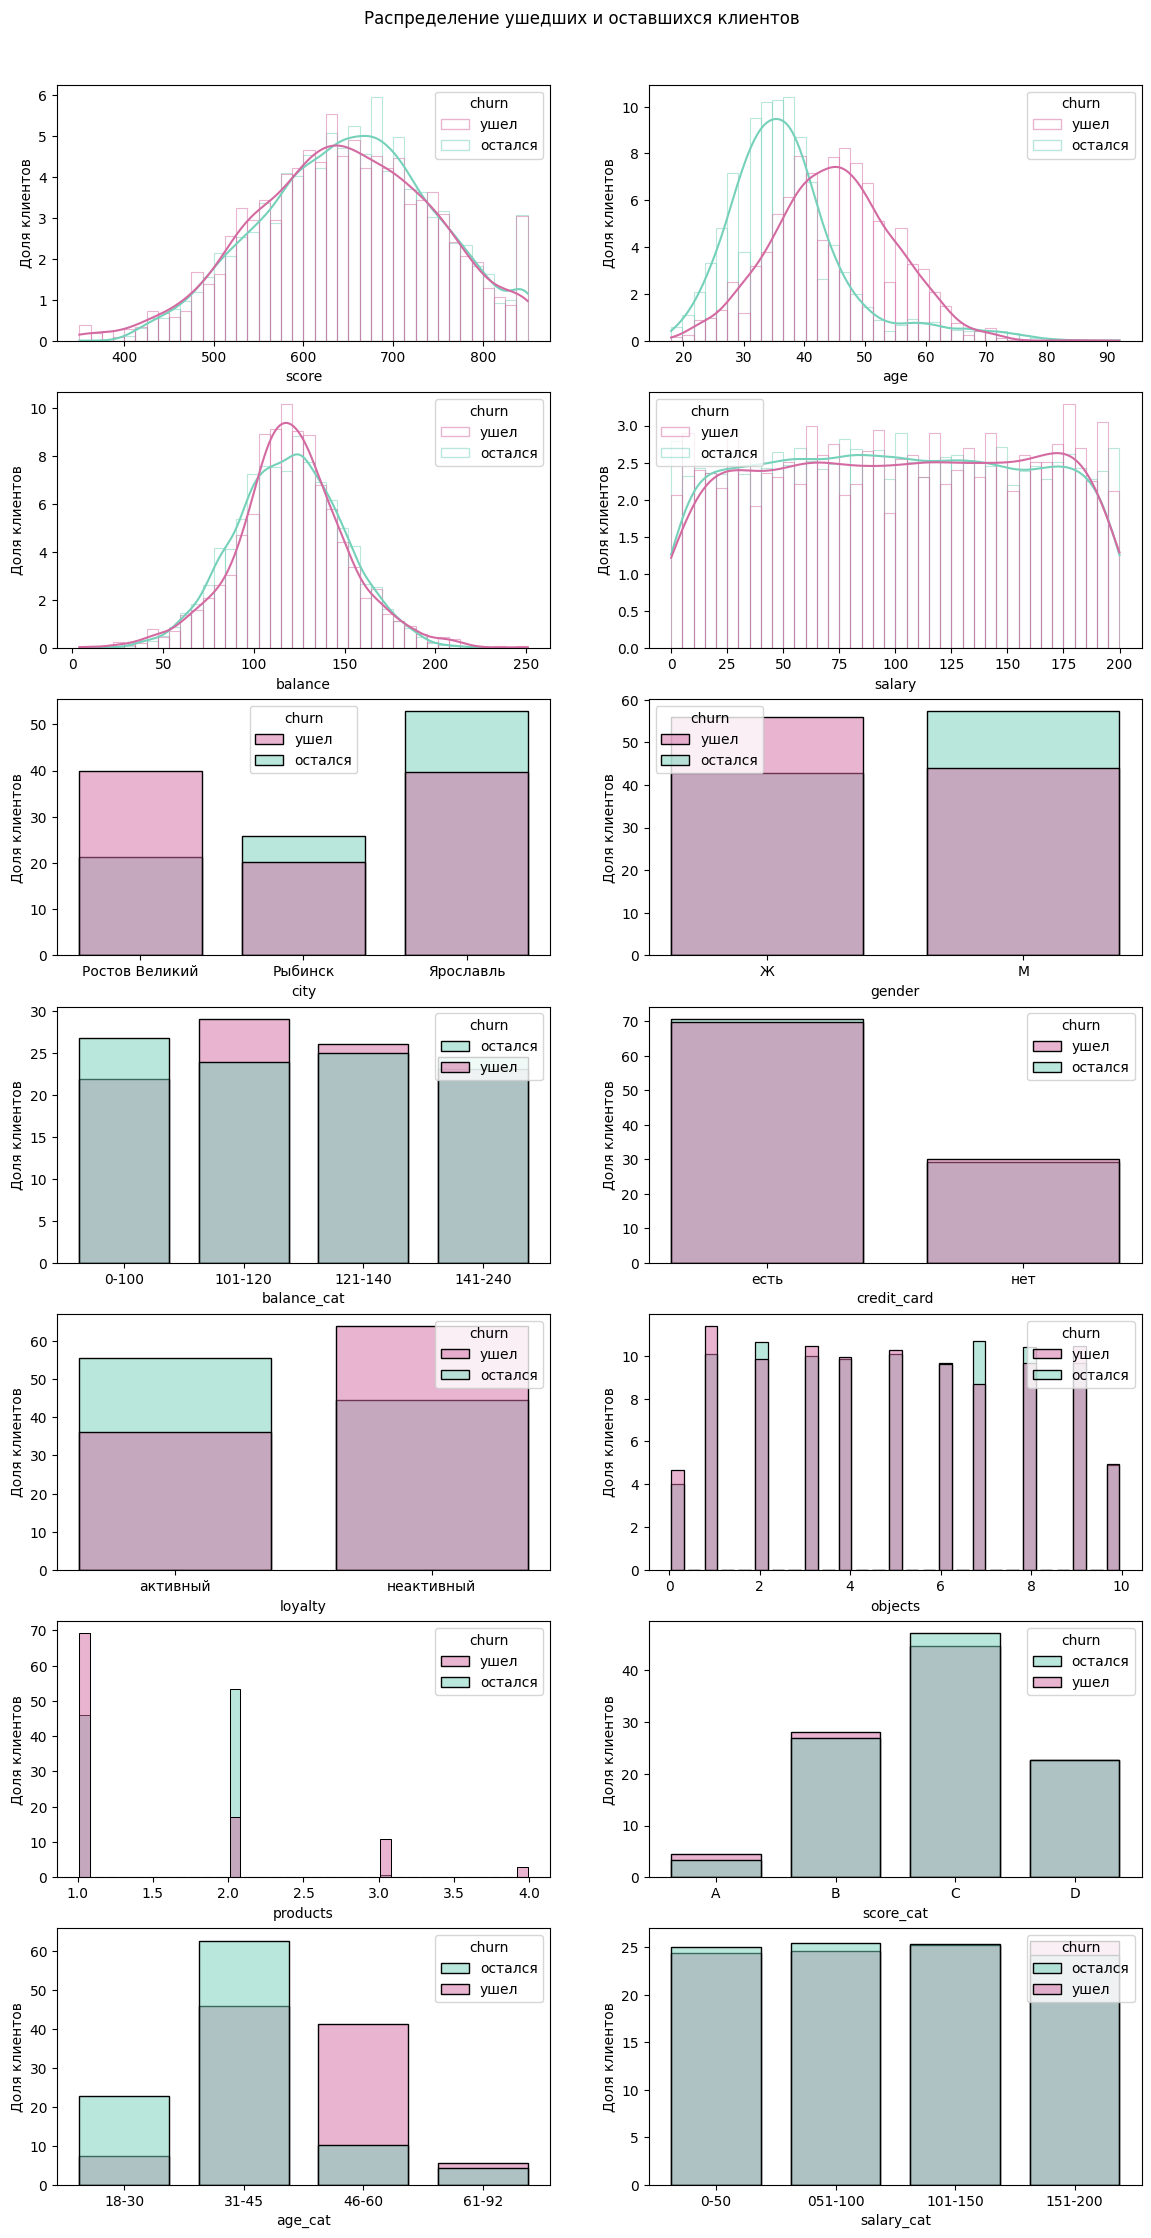

In [43]:
simple_draw()

Наиболее явные относительные расхождения при независимой нормализации распределений между оставшимися и ушедшими клиентами наблюдаются в следующих категориях:
* `age` - клиенты 38-65 лет более склонны к уходу, 
* `city`- в Ростове наблюдается наибольшая тенденция к уходу, 
* `products` - высокая тенденция к уходу у клиентов с 1, 3 и 4 продуктами.

Также, повышенное количество расхождений наблюдается в категориях `gender` (у женщин) и `loyalty` (неактивные клиенты).

Для клиентов с четырьмя банковскими продуктами в распределениях по остальным категориям также нельзя выделить ничего необычного.    Вероятно обслуживание не оправдало их ожиданий.

Таким образом, можно сделать вывод, что клиентов с 3 и 4 продуктами почти не осталось, и стоит уделить им внимание, разобраться почему они ушли. Возможно у них были проблемы в обслуживании, изменились условия пользования продуктом, либо возникали технические неполадки при использовании продуктом. Сделать вывод по имеющимся данным нельзя, но это определенно сегмент, склонный к уходу.

Для того, чтобы в дальнейшем поиске зависимостей не учитывать данных клиентов, сделаем срез по количеству продуктов и перезапишем функции.

In [44]:
bank= bank.query('products < 3')

In [45]:
def histplot_num(ax= None, df= bank, x= None, hue= None, 
               f= False, shr= 1, kde= True, c= None,
               s= 'count', cn= True, leg= False, b= 40
              ):
    p= {'ушел': '#d46aa2', 'остался': '#75d1ba'}
    plot= sns.histplot(ax= ax, data = df, x = x, hue = hue,
                       fill= f, shrink= shr, kde= kde, palette= p, color= c,
                       stat = s, common_norm= cn, legend = leg, bins= b, alpha= 0.5
                      )
    return plot

def histplot_cat(ax= None, df= bank, x= None, hue= None, 
                 f= True, shr= 0.75, kde= False, c= None,
                 s= 'count', cn= True, leg= False
                ):
    p= {'ушел': '#d46aa2', 'остался': '#75d1ba'}
    plot= sns.histplot(ax= ax, data = df.sort_values(by= x), x = x, hue = hue,
                       fill= f, shrink= shr, kde= kde, palette= p, color= c,
                       stat = s, common_norm= cn, legend = leg, alpha= 0.5
                      )
    return plot

После среза, распределение по продуктам будет выглядеть следующим образом.

<Axes: xlabel='products', ylabel='Percent'>

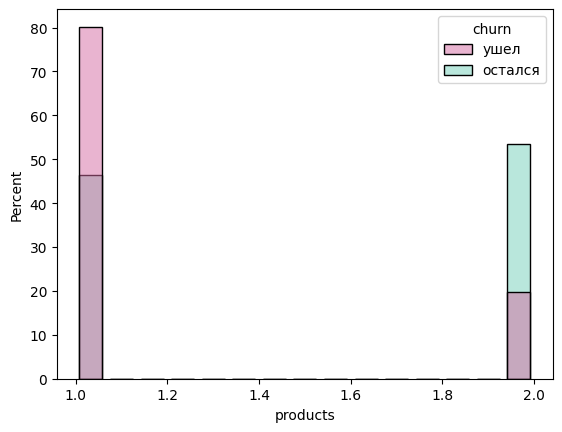

In [46]:
#products
histplot_cat(x= 'products', hue= 'churn', s= 'percent', cn= False, leg= True)

Среди ушедших, 80% пользовались всего одним продуктом. Среди оставшихся клиентов почти поровну - 45% - один продукт, 55% - два продукта.

#### Вывод

В рамках первого взгляда на ушедших и оставшихся клиентов можно сделать следующие выводы:

1. при значениях скоринга (столбец `score`) менее 405, нет ни одного оставшегося клиента. Вероятно, клиенты с низкими значениями скоринга более склонны к уходу, чем с высокими значениями   
    * *более 80% клиентов с низким скорингом пользуются кредитной картой, у 95% заработная плата выше 50 тыс.руб., 70% из них были неактивны в течение последнего месяца и 80% обладают всего одним банковским продуктом.*
    
    
2. в Ростове Великом наблюдается больше ушедших клиентов, чем в остальных городах;
3. ушедших женщин на 20% больше, чем мужчин;
4. ушедших неактивных клиентов на 30% больше, чем активных;
5. большое количество ушедших клиентов в возрасте от 38 до 65 лет;
6. клиентов с 3 и 4 продуктами почти не осталось (среди клиентов, использующих три банковских продукта всего 46 клиентов остались и 220 клиентов ушло, среди клиентов, использующих четыре банковских продукта нет ни одного оставшегося клиента). Стоит уделить им внимание, разобраться почему они ушли. Возможно у них были проблемы в обслуживании, изменились условия пользования продуктом, либо возникали технические неполадки при использовании продуктом. Сделать вывод по имеющимся данным нельзя, но это определенно сегмент, склонный к уходу;
7. по количеству используемых продуктов, среди ушедших, 80% пользовались всего одним продуктом. Среди оставшихся клиентов почти поровну - 45% - один продукт, 55% - два продукта.

Обобщая, **склонные к уходу сегменты** - клиенты с низким значениями скоринга, клиенты из Ростова, женщины, неактивные клиенты, клиенты в возрасте 38-65 лет, клиенты с 3 и 4 продуктами и, возможно, клиенты с 1 продуктом.

### Выделение сегментов

#### Описание методики

Этот этап заключается в попытке определить, является ли предполагаемый сегмент отточным и как он связан с другими категориями.

Исследование проводится следующим образом: 
* рассчитывается количество ушедших и оставшихся клиентов до и после среза значений в датасете по предполагаемому отточному сегменту.
* расчитывается на сколько процентов сократилось общее количество ушедших и оставшихся клиентов после среза.
* расчитывается на сколько процентов сократилось количество ушедших и оставшихся клиентов после среза внутри категорий.
* сравниваются общий процент ушедших(`dec_pct[1]`) и процент ушедших внутри категории(`left_dec_pct`):
    * если `dec_pct[1]` = `left_dec_pct`, то зависимости между сегментом и категорией нет,
    * если `dec_pct[1]` < `left_dec_pct`, то, вероятно, категория также склонна к уходу и на нее стоит обратить внимание,
    * если `dec_pct[1]` > `left_dec_pct`, то, категория не склонна к уходу.
* сравниваются общий процент оставшихся(`dec_pct[0]`) и процент оставшихся внутри категории(`stay_dec_pct`):
    * если `dec_pct[0]` = `stay_dec_pct`, то зависимости между сегментом и категорией нет, связь нейтральная,
    * если `dec_pct[0]` < `stay_dec_pct`, то, срезом затронуло слишком много оставшихся клиентов, связь положительная,
    * если `dec_pct[0]` > `stay_dec_pct`, - срезом затронуло меньше значений, чем в остальных категориях, значит оставшиеся клиенты этой категории не связаны со срезанным отточным сегментом, связь отрицательная.
* для индикации того, что сегмент по которому делается срез является отточным, рассчитывается коэффициент (`gen_churn_coeff`), показывающий во сколько раз увеличилось отношение оставшихся клиентов к ушедшим после среза:
    * если `gen_churn_coeff` > 1, значит в срез попало больше ушедших клиентов, чем оставшихся, то есть сегмент склонен к уходу
    * если `gen_churn_coeff` <= 1, значит в срез попало меньше или столько же ушедших клиентов, сколько оставшихся, то есть сегмент не склонен к уходу
* также, для анализа возможно связи между срезанным сегментом и исследуемой категорией, рассчитывается коэффициент (`churn_coeff`), показывающий во сколько раз увеличилось отношение оставшихся клиентов к ушедшим после среза в каждой категории. Если данный коэффициент значимо отличается от `gen_churn_coeff` в большую сторону, значит данная категория более склонна к уходу, если в меньшую - категория не зависит от сегмента.

**Функции расчета**

функция `dataset_decreased`:
* `df_dec_rate` - показывает во сколько раз уменьшилось количество значений в датасете после среза
* `df_dec_pct` - показывает на сколько процентов уменьшилось количество значений в датасете после среза
* `gen_churn_coeff` - показывает во сколько раз увеличилось отношение оставшихся клиентов к ушедшим после среза. Если коэффициент больше единицы, значит в срез попало больше ушедших клиентов, чем оставшихся. Если коэффициент значительно больше единицы, значит данная категория более склонна к уходу


In [47]:
def dataset_decreased(df_init, df_fin):
    # общее
    # на столько процентов уменьшилось количество значений в датасете
    values_decreased_pct = (
        round(1 - (df_fin["user_id"].count() / df_init["user_id"].count()), 2) * 100
    )

    # во столько раз уменьшилось количество значений в датасете
    values_decreased_rate = round(df_init["user_id"].count() / df_fin["user_id"].count(), 2)

    # коэффициент ухода общий
    general_churn_coeff = round(
        (
            df_fin.groupby("churn", as_index=False)
            .agg({"user_id": "count"})
            .sort_values(by="churn")["user_id"][0]
            / df_fin.groupby("churn", as_index=False)
            .agg({"user_id": "count"})
            .sort_values(by="churn")["user_id"][1]
        )
        / (
            df_init.groupby("churn", as_index=False)
            .agg({"user_id": "count"})
            .sort_values(by="churn")["user_id"][0]
            / df_init.groupby("churn", as_index=False)
            .agg({"user_id": "count"})
            .sort_values(by="churn")["user_id"][1]
        ),
        2,
    )
    
    dataset_values_decreased = pd.DataFrame({
        'df_dec_rate':values_decreased_rate,
        'df_dec_pct':values_decreased_pct,
        'gen_churn_coeff':general_churn_coeff
        }
        , index= ['values'])
    
    return dataset_values_decreased


функция `general_churn_decreased`:
* `dec_rate` - показывает во сколько раз уменьшилось количество клиентов в категориях `ушел` и `остался` после среза
* `dec_pct` - показывает на сколько процентов уменьшилось количество клиентов в категориях `ушел` и `остался` после среза

In [48]:
def general_churn_decreased(df_init, df_fin):
    # во столько раз уменьшилось количество значений по категориям ушел/ остался
    churn_values_dec_rate = (
        df_init.groupby("churn")
        .agg({"user_id": "count"})
        .div(df_fin.groupby("churn").agg({"user_id": "count"}))
        .reset_index()
        .round(2)
        .rename(columns= {'user_id':'dec_rate'})
    )

    # на столько процентов уменьшилось количество значений по категориям ушел/ остался
    churn_values_dec_pct = (
        1
        - (
            df_fin.groupby("churn")
            .agg({"user_id": "count"})
            .div(df_init.groupby("churn").agg({"user_id": "count"}))
            .round(2)
        )
    ) * 100
    churn_values_dec_pct= churn_values_dec_pct.reset_index().rename(columns= {'user_id':'dec_pct'})
    
    general_churn_values= churn_values_dec_rate.merge(churn_values_dec_pct,on= 'churn', how= 'left')
    
    return general_churn_values


функция `category_churn_decreased`:
* ушедшие клиенты:
    * `left_b4_qry` - количество ушедших клиентов в исходном датасете в разбивке по категориям
    * `left_aft_qry` - количество ушедших клиентов в датасете после среза в разбивке по категориям
    * `left_dec_pct` - показывает на сколько процентов уменьшилось количество ушедших клиентов в каждой категории после среза
    * `left_dec_rate` - показывает во сколько раз уменьшилось количество ушедших клиентов в каждой категории после среза
* оставшиеся клиенты:
    * `stay_b4_qry` - количество оставшихся клиентов в исходном датасете в разбивке по категориям
    * `stay_aft_qry` - количество оставшихся клиентов в датасете после среза в разбивке по категориям
    * `stay_dec_pct` - показывает на сколько процентов уменьшилось количество оставшихся клиентов в каждой категории после среза
    * `stay_dec_rate` - показывает во сколько раз уменьшилось количество оставшихся клиентов в каждой категории после среза
* `churn_coeff` - показывает во сколько раз увеличилось отношение оставшихся клиентов к ушедшим после среза в каждой категории. Если данный коэффициент значимо отличается от `gen_churn_coeff` в большую сторону, значит данная подкатегория более склонна к уходу.

In [49]:
def category_churn_decreased(df_init, df_fin, x):

    tab1 = (
        df_init.query('churn == "ушел"')
        .groupby(x, as_index=False)
        .agg({"user_id": "count"})
        .rename(columns={"user_id": "left_b4_qry"})
    )
    tab1 = tab1.merge(
        df_fin.query('churn == "ушел"')
        .groupby(x, as_index=False)
        .agg({"user_id": "count"})
        .rename(columns={"user_id": "left_aft_qry"}),
        on=x,
        how="left",
    )

    tab1["left_dec_pct"] = round(1 - (tab1["left_aft_qry"] / tab1["left_b4_qry"]), 2) * 100
    tab1["left_dec_rate"] = round(tab1["left_b4_qry"] / tab1["left_aft_qry"], 2)


    tab2 = (
        df_init.query('churn != "ушел"')
        .groupby(x, as_index=False)
        .agg({"user_id": "count"})
        .rename(columns={"user_id": "stay_b4_qry"})
    )
    tab2 = tab2.merge(
        df_fin.query('churn != "ушел"')
        .groupby(x, as_index=False)
        .agg({"user_id": "count"})
        .rename(columns={"user_id": "stay_aft_qry"}),
        on=x,
        how="left",
    )
    tab2["stay_dec_pct"] = round(1 - (tab2["stay_aft_qry"] / tab2["stay_b4_qry"]), 2) * 100
    tab2["stay_dec_rate"] = round(tab2["stay_b4_qry"] / tab2["stay_aft_qry"], 2)


    tab1 = tab1.merge(tab2, on=x, how="left")
    
    tab1["churn_coeff"] = (
        (tab1["stay_aft_qry"] / tab1["left_aft_qry"])
        / (tab1["stay_b4_qry"] / tab1["left_b4_qry"])
    ).round(2)
    
    return tab1


**Функции подграфиков**

In [50]:
def subplots_num(df,x,f= False, b= 40, leg= False):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes= axes.flatten()
    histplot_num(ax= axes[0], x= x, hue= 'churn', f=f, b=b, leg= True)
    histplot_num(ax= axes[1], x= x, hue= 'churn', df= df, f=f, b=b, leg=leg)
    histplot_num(ax= axes[2], x= x, hue= 'churn', s= 'percent', cn= False
                 , f=f, b=b, leg=leg)
    histplot_num(ax= axes[3], x= x, hue= 'churn', s= 'percent', cn= False
                 , df= df, f=f, b=b, leg=leg)
    axes[1].sharey(axes[0])
    if x== 'salary':
        axes[2].sharey(axes[3])
    else:
        axes[3].sharey(axes[2])
    axes[0].title.set_text('абс. количества до среза')
    axes[1].title.set_text('абс. количества после среза')
    axes[2].title.set_text('отн. количества до среза')
    axes[3].title.set_text('отн. количества после среза')

In [51]:
def subplots_cat(df,x, leg=False):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes= axes.flatten()
    histplot_cat(ax= axes[0], x= x, hue= 'churn', leg= leg)
    histplot_cat(ax= axes[1], x= x, hue= 'churn', df= df, leg=True)
    histplot_cat(ax= axes[2], x= x, hue= 'churn', s= 'percent', cn= False, leg=leg)
    histplot_cat(ax= axes[3], x= x, hue= 'churn', s= 'percent', cn= False, df= df, leg=leg)
    axes[1].sharey(axes[0])
    if x== 'products' or x == 'salary_cat' or x== 'balance_cat':
        axes[2].sharey(axes[3])
    else:
        axes[3].sharey(axes[2])
    axes[0].title.set_text('абс. количества до среза')
    axes[1].title.set_text('абс. количества после среза')
    axes[2].title.set_text('отн. количества до среза')
    axes[3].title.set_text('отн. количества после среза')

#### Возраст

Проверим возрастной сегмент - срежем клиентов с возрастом в интервале 38-65 лет.

In [52]:
bank_age = bank.query('age <=38 or age>= 65')
bank_age.age.unique()

array([27, 31, 24, 34, 25, 35, 32, 38, 36, 29, 33, 37, 19, 66, 26, 21, 75,
       22, 30, 28, 65, 73, 72, 20, 67, 79, 80, 68, 23, 70, 18, 82, 69, 74,
       71, 76, 77, 88, 85, 84, 78, 81, 92, 83])

In [53]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

Убрав клиентов, чей возраст в интервале 38-65 лет, мы сократили количество ушедших на 72%, то есть в интервалах 18-38 и 65-90 лет содержится 28% ушедших клиентов. Количество активных клиентов сократилось всего на 34%. Общий коэффициент ухода составляет 2.36, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 2.36 раза. Это дает основания полагать, что сегмент склонен к уходу.

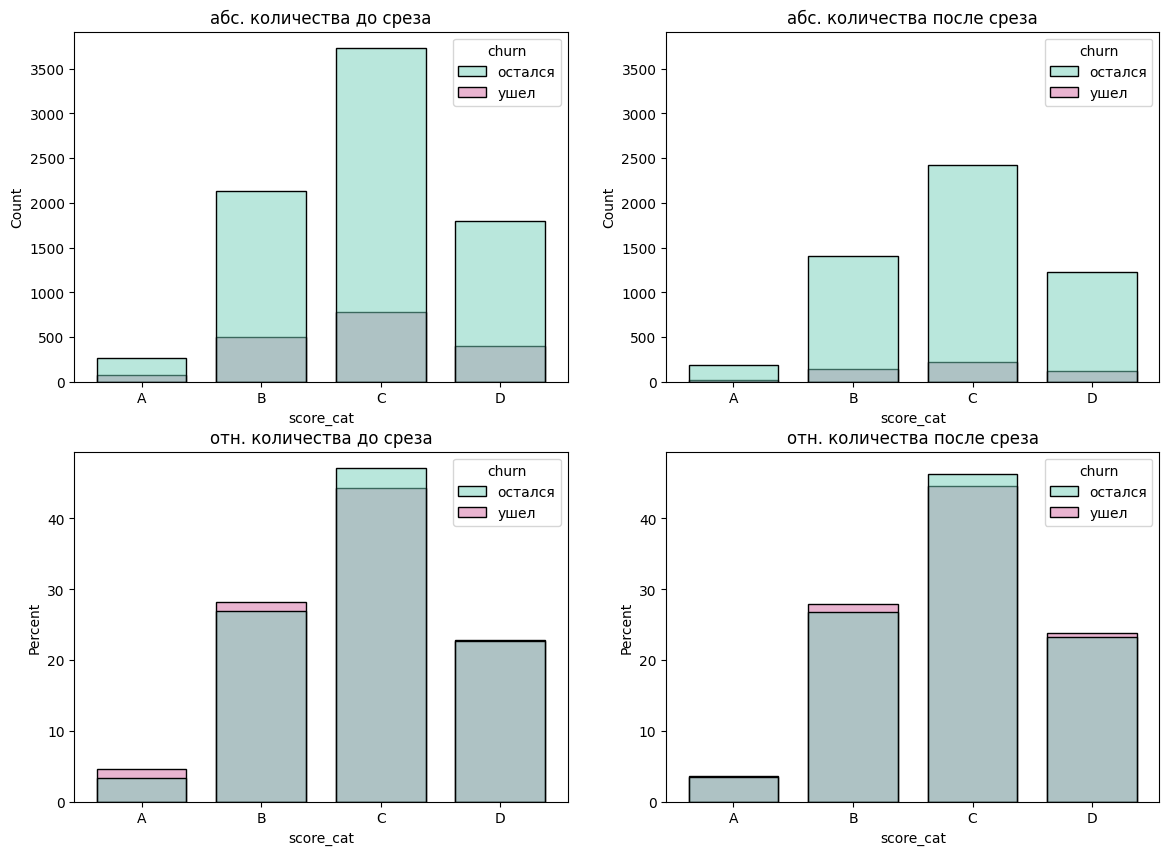

In [54]:
subplots_cat(bank_age, 'score_cat', leg=True)

Разница в относительных величинах несущественна. Разницу в абсолютных величинах рассмотрим применив расчетные функции.

In [55]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'score_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

score_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         A           80            18          78.0           4.44   
1         B          496           138          72.0           3.59   
2         C          779           220          72.0           3.54   
3         D          402           118          71.0           3.41   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          264           185          30.0           1.43         3.11  
1         2128          1408          34.0           1.51         2.38  
2         3727          2428          35.0           1.54         2.31  
3         1798          1222          32.0           1.47         2.32

Среди скоринговых категорий больше всего склонны к уходу клиенты из группы А (350-475 очков) и это логично, тк в интервале от 350 до 404 очков скоринга нет ни одного клиента, который бы остался.

Остальные группы распределены равномерно.

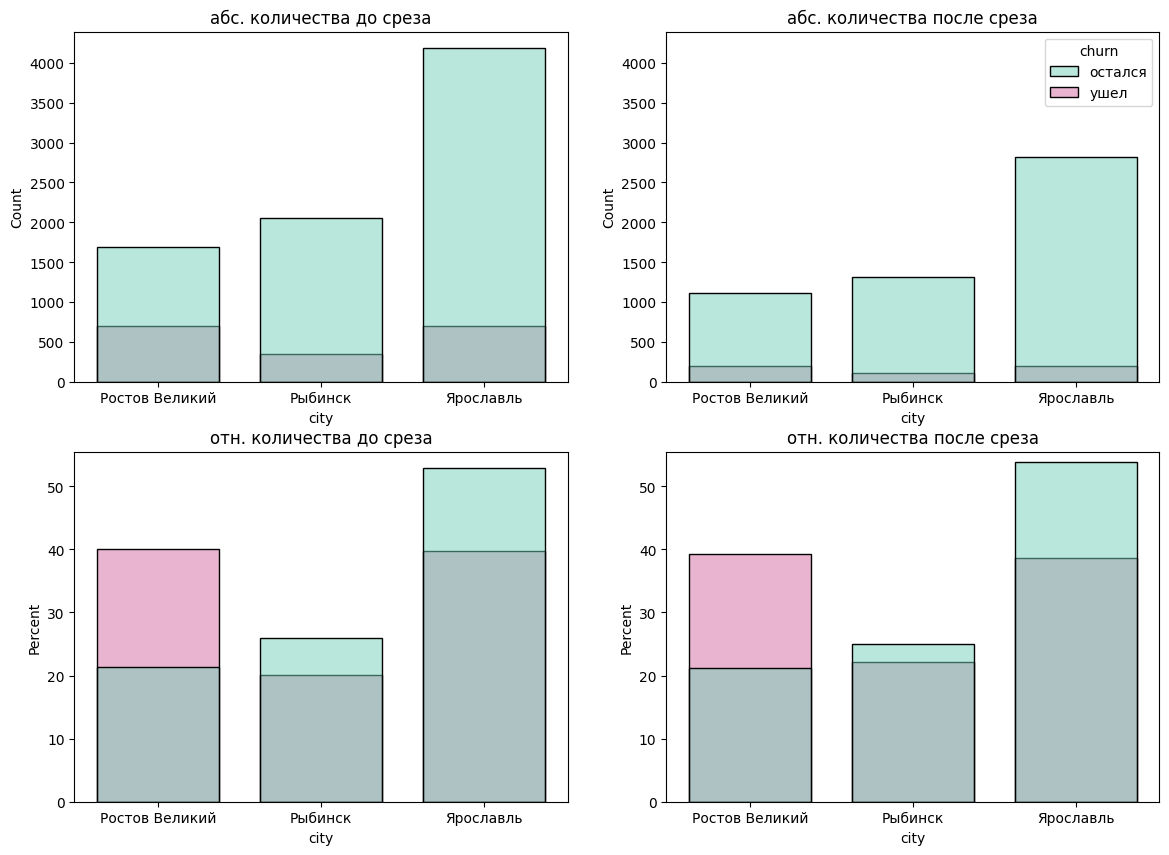

In [56]:
subplots_cat(bank_age, 'city')

Среди городов наиболее склонны к уходу клиенты из Ростова (отдельный сегмент) - в относительных величинах оттуда уходят на 50% больше,чем остаются, в сравнении с другими городами. Срез по возрасту на это распределение почти не повлиял.

In [57]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'city'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

city  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0  Ростов Великий          704           194          72.0           3.63   
1         Рыбинск          354           109          69.0           3.25   
2       Ярославль          699           191          73.0           3.66   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1685          1111          34.0           1.52         2.39  
1         2050          1312          36.0           1.56         2.08  
2         4182          2820          33.0           1.48         2.47

Различия между группами незначительны, но ушедших клиентов из Ярославля и Ростова немногим больше, чем ушедших клиентов их Рыбинска.

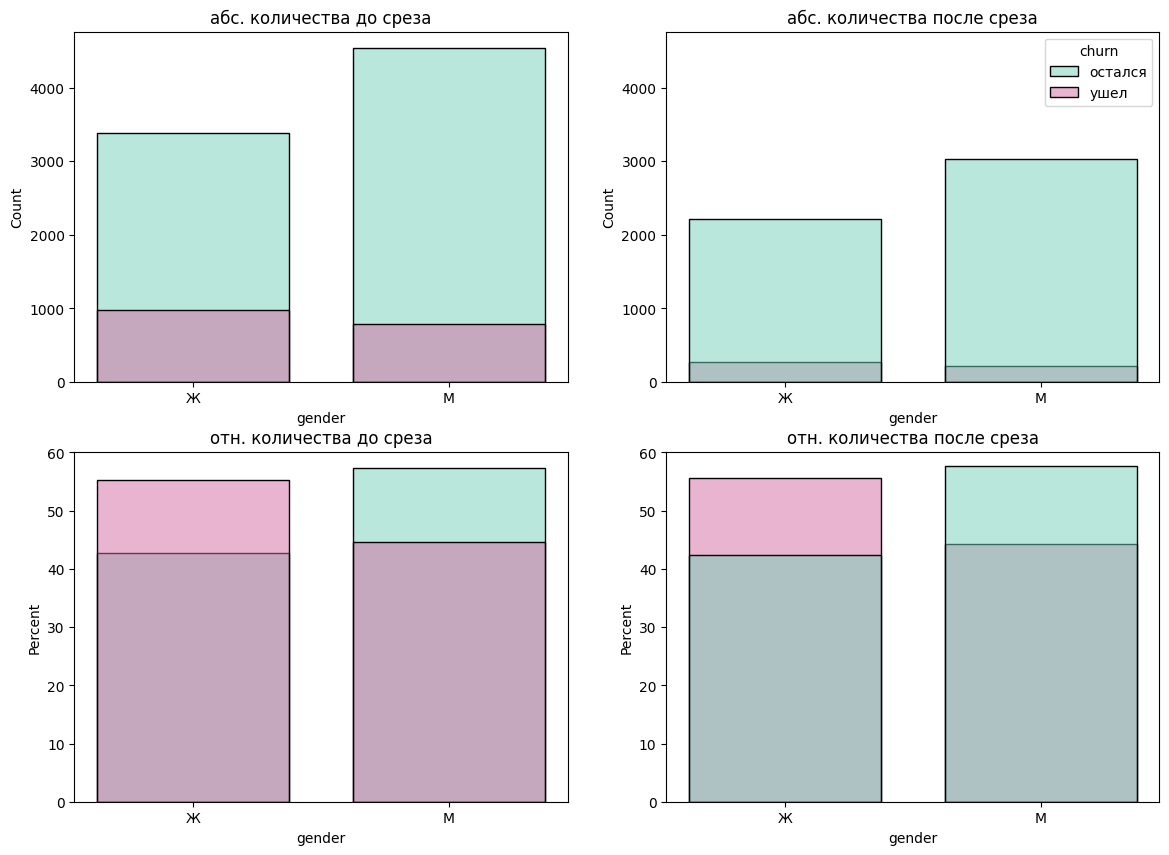

In [58]:
subplots_cat(bank_age, 'gender')

В относительных величинах различий не наблюдается 

In [59]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'gender'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

gender  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  stay_b4_qry  \
0      Ж          972           275          72.0           3.53         3384   
1      М          785           219          72.0           3.58         4533   

   stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          2219          34.0           1.53         2.32  
1          3024          33.0           1.50         2.39

Срез по возрасту сократил и мужчин, и женщин равномерно. Это дает основания полагать, что более высокие значения ухода женщин, как отдельного сегмента, нежели мужчин, не зависит от возраста.

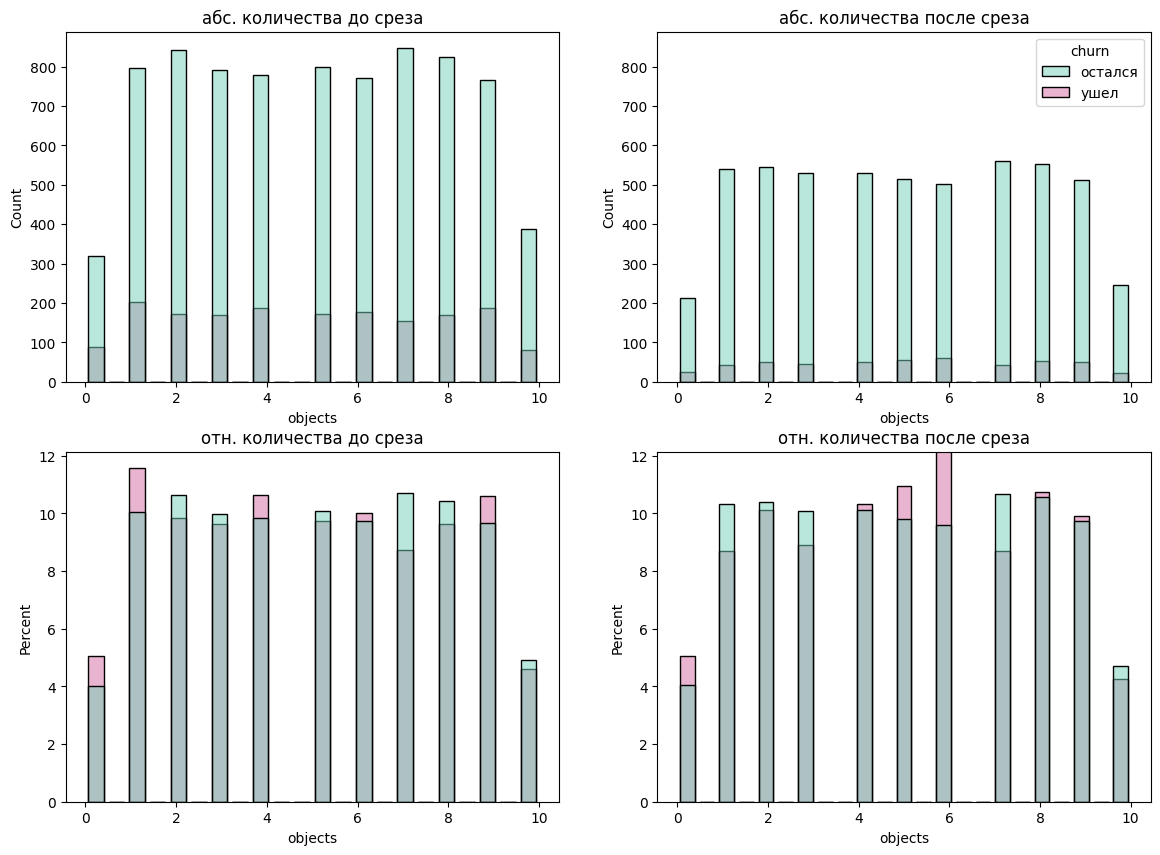

In [60]:
subplots_cat(bank_age, 'objects')

По количеству объектов в собственности, все значения, кроме 5 и 6 объектов сократились более-менее равномерно. Клиенты у которых от 5 до 6 объектов в собственности менее склонны к уходу.

In [61]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'objects'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

objects  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         0           89            25          72.0           3.56   
1         1          203            43          79.0           4.72   
2         2          173            50          71.0           3.46   
3         3          169            44          74.0           3.84   
4         4          187            51          73.0           3.67   
5         5          171            54          68.0           3.17   
6         6          176            61          65.0           2.89   
7         7          153            43          72.0           3.56   
8         8          169            53          69.0           3.19   
9         9          186            49          74.0           3.80   
10       10           81            21          74.0           3.86   

    stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0           318           212          33.0           1.50         2.37  
1           796           541          32.0           1.47         3.21  
2           843           545          35.0           1.55         2.24  
3           790           529          33.0           1.49         2.57  
4           779           530          32.0           1.47         2.49  
5           798           514          36.0           1.55         2.04  
6           770           502          35.0           1.53         1.88  
7           846           560          34.0           1.51         2.36  
8           824           553          33.0           1.49         2.14  
9           765           511          33.0           1.50         2.54  
10          388           246          37.0           1.58         2.45

Полученные значения повторяют вывод выше - клиенты у которых от 5 до 6 объектов в собственности менее склонны к уходу. Но за кономерности здесь не наблюдается.

Если рассматривать значения по принципу есть/нет объект в собственности, то различий так же не видно.

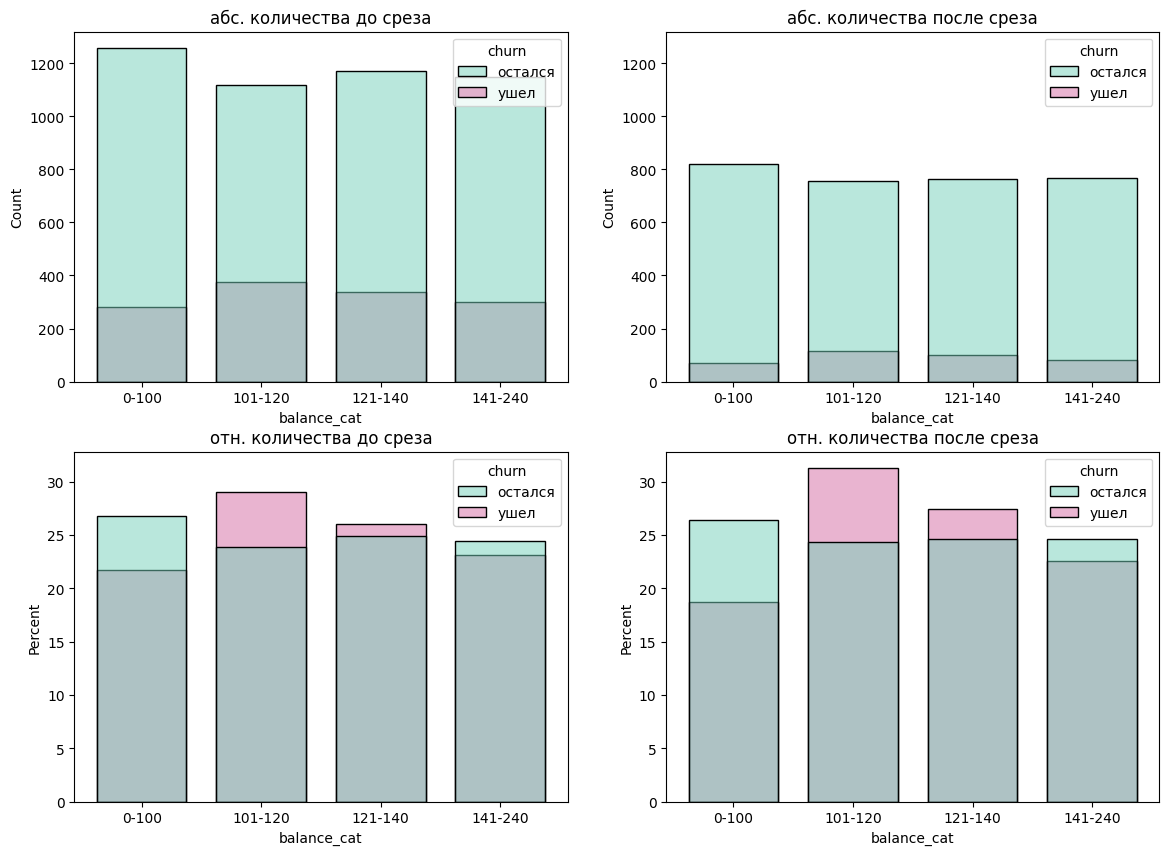

In [62]:
subplots_cat(bank_age, 'balance_cat', leg= True)

Срез по возрасту в большей степени повлиял на группу 0-100 и немного на 141-200 - их доля уменьшилась на несколько процентов, доля остальных немного выросла. 

In [63]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'balance_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

balance_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-100          282            69          76.0           4.09   
1     101-120          377           115          69.0           3.28   
2     121-140          338           101          70.0           3.35   
3     141-240          300            83          72.0           3.61   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1256           821          35.0           1.53         2.67  
1         1119           757          32.0           1.48         2.22  
2         1170           765          35.0           1.53         2.19  
3         1147           766          33.0           1.50         2.41

Доля ушедших в группе 0-100 уменьшилась чуть больше (на 4% больше общего процента), чем остальные.

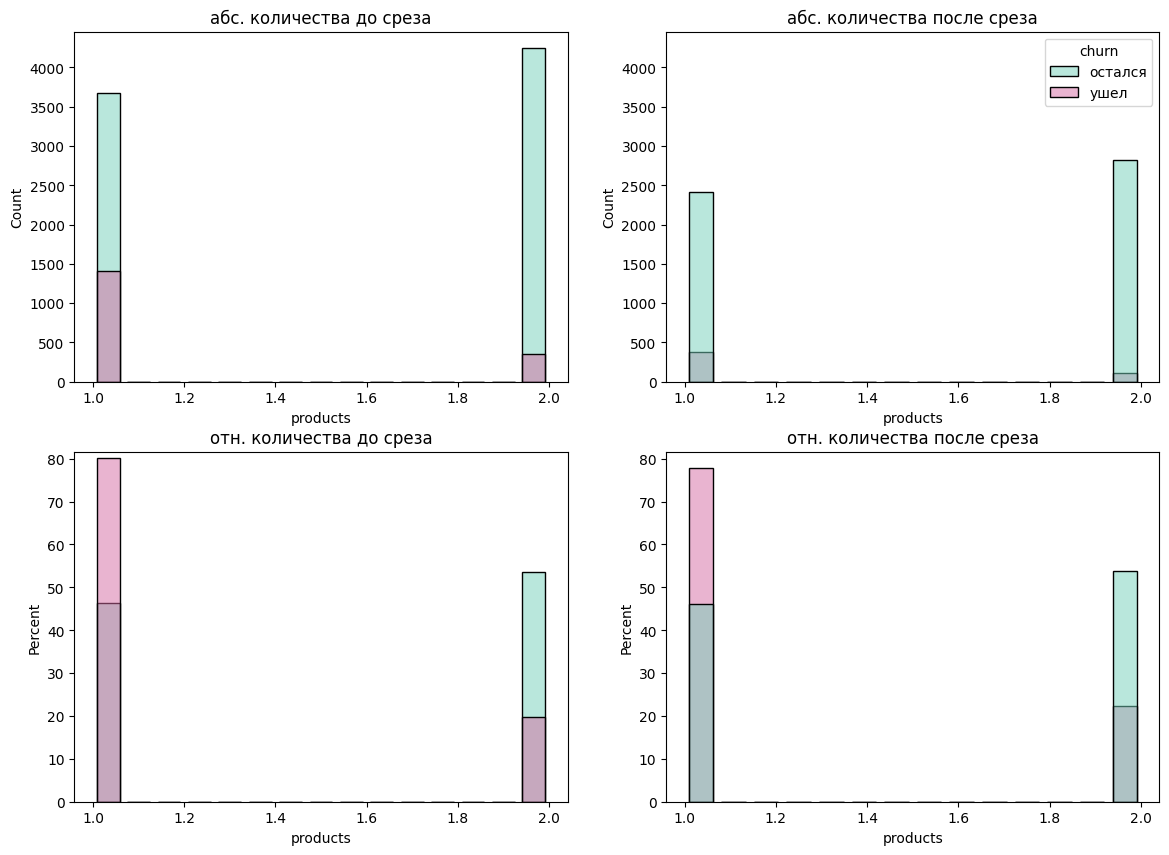

In [64]:
subplots_cat(bank_age, 'products')

По количеству продуктов, значения сократились равномерно

In [65]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'products'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

products  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         1         1409           384          73.0           3.67   
1         2          348           110          68.0           3.16   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         3675          2416          34.0           1.52         2.41  
1         4242          2827          33.0           1.50         2.11

В срез по возрасту вошло чуть больше владельцев одного продукта, чем владельцев двух (73% против 68%).

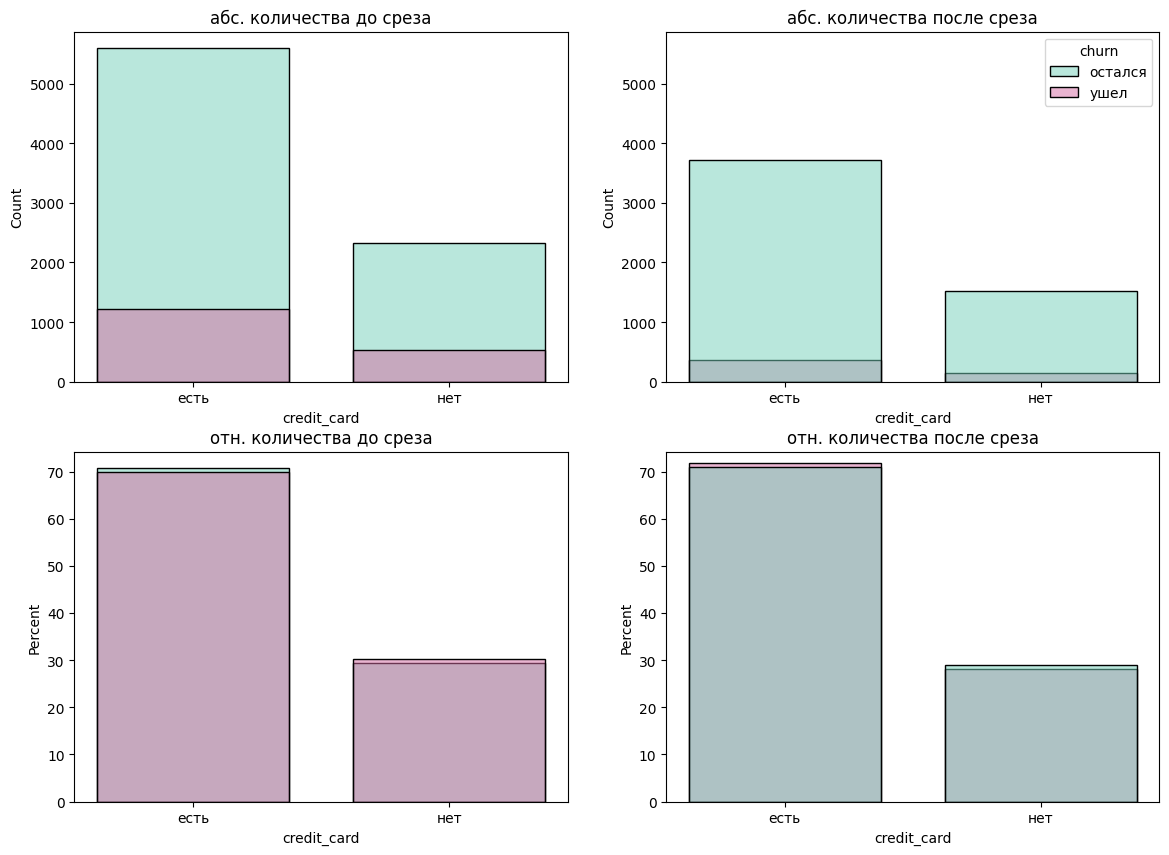

In [66]:
subplots_cat(bank_age, 'credit_card')

Ушедших и оставшихся среди имеющих и не имеющих кредитные карты - 50 на 50. Вероятно, такое соотношение сохранится независимо от последующих срезов.

In [67]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'credit_card'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

credit_card  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0        есть         1227           355          71.0           3.46   
1         нет          530           139          74.0           3.81   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         5597          3721          34.0           1.50          2.3  
1         2320          1522          34.0           1.52          2.5

Ушедших клиентов без кредтной карты на 3% больше, чем с ней.

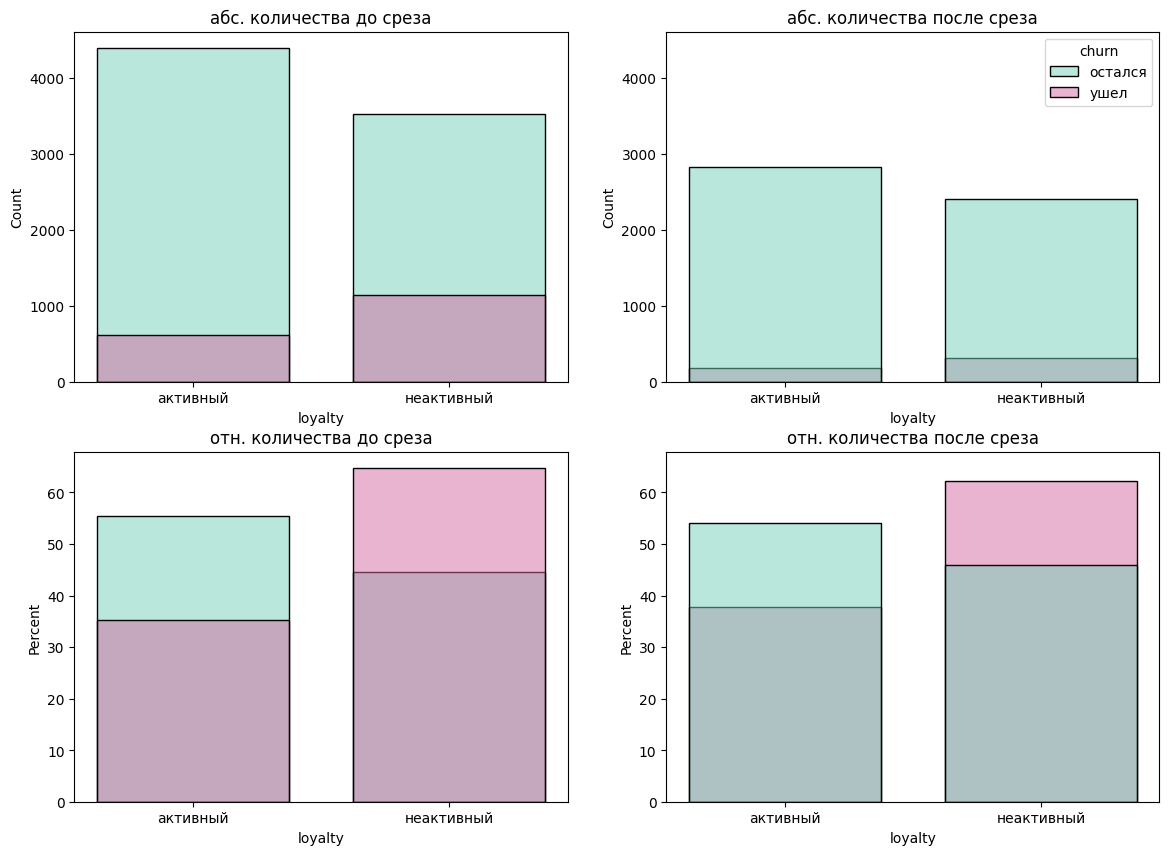

In [68]:
subplots_cat(bank_age, 'loyalty')

Значимых различий не обнаружено.

In [69]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'loyalty'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

loyalty  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0    активный          621           187          70.0           3.32   
1  неактивный         1136           307          73.0           3.70   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         4388          2832          35.0           1.55         2.14  
1         3529          2411          32.0           1.46         2.53

Срез неактивных пользователей на 3% больше, чем активных.

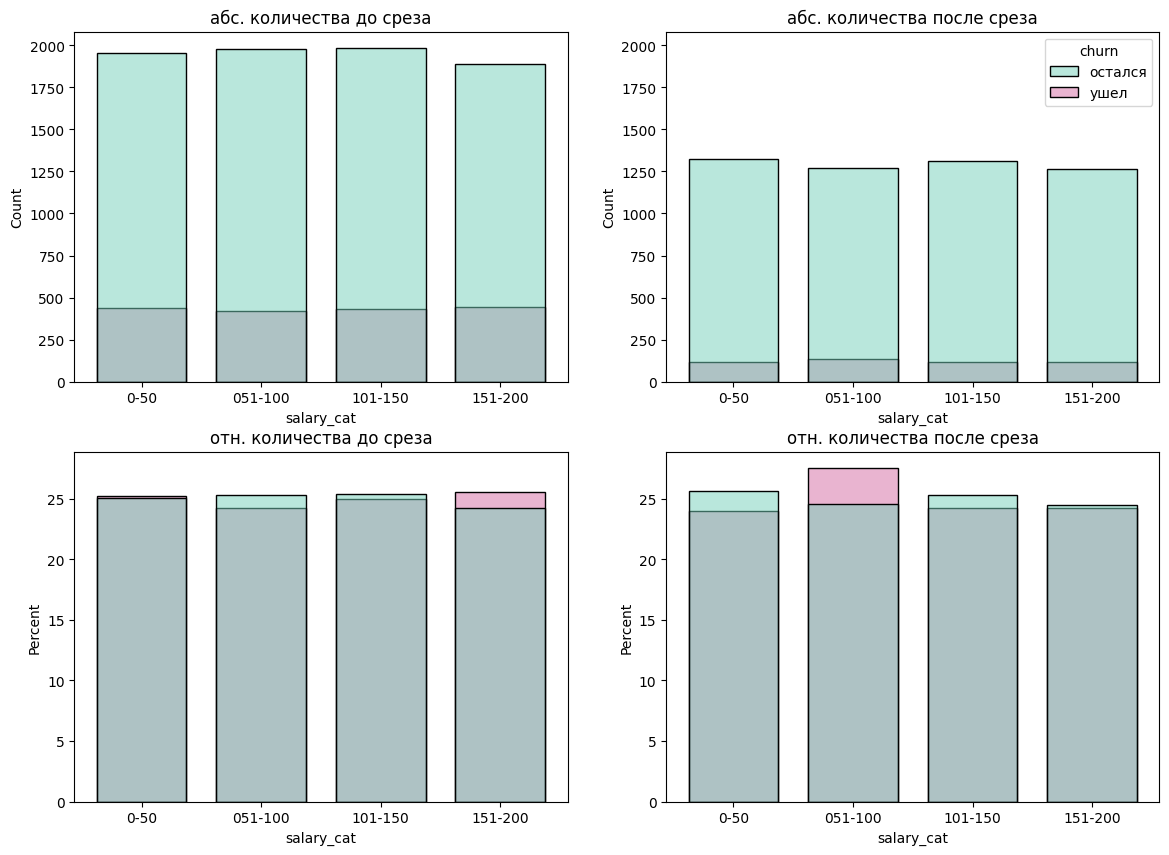

In [70]:
subplots_cat(bank_age, 'salary_cat')

В разбивке зарплат по категориям, также наблюдается отклонение в интервале 51-100 тыс.рублей.

In [71]:
display(dataset_decreased(bank, bank_age))
display(general_churn_decreased(bank,bank_age))
display(category_churn_decreased(bank, bank_age, 'salary_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.69        41.0             2.36

churn  dec_rate  dec_pct
0  остался      1.51     34.0
1     ушел      3.56     72.0

salary_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-50          436           117          73.0           3.73   
1    051-100          419           134          68.0           3.13   
2    101-150          431           118          73.0           3.65   
3    151-200          441           118          73.0           3.74   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1955          1325          32.0           1.48         2.53  
1         1978          1272          36.0           1.56         2.01  
2         1983          1310          34.0           1.51         2.41  
3         1890          1267          33.0           1.49         2.51

При срезе, ушедших клиентов из категории 051-100 сократилось на 5% меньше, чем клиентов в остальных категориях. Значимыхразличий не наблюдается

**Вывод**

Убрав клиентов, чей возраст в интервале 38-65 лет, мы сократили количество ушедших на 72%, то есть в интервалах 18-38 и 65-90 лет содержится 28% ушедших клиентов. Количество активных клиентов сократилось всего на 34%. Общий коэффициент ухода составляет 2.36, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 2.36 раза. Это дает основания полагать, что данный сегмент склонен к уходу.

Внутри данного сегмента более всего склонны к уходу следующие категории:
* клиенты с низким скорингом,
* клиенты из Ярославля и Ростова,
* клиенты с балансом на счету от 0 до 100 тыс.руб.,
* клиенты, владеющие одним банковским продуктом,
* клиенты без кредитной карты,
* неактивные клиенты

#### Города

Проверим городской сегмент - срежем из Ростова Великого.

In [72]:
bank_not_rostov = bank.query('city != "Ростов Великий"')
bank_not_rostov.city.unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

In [73]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

Срезав Ростов, количество оставшихся сократилось на 21%, а ушедших на 40%.
Коэффициент ухода меньше, чем в срезе по возрасту, но он так же больше единицы, что говорит о том, что клиенты из Ростова склонны к уходу.

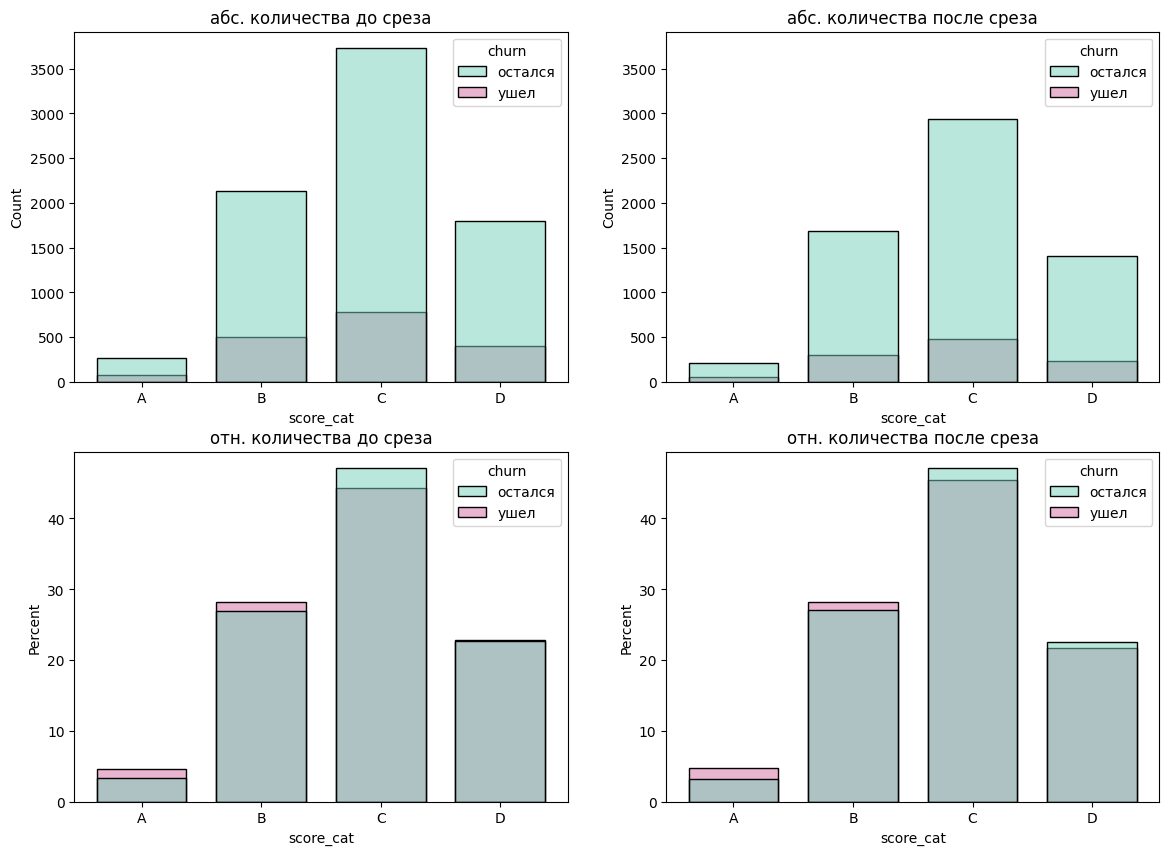

In [74]:
subplots_cat(bank_not_rostov, 'score_cat', leg=True)

Значимых различий не наблюдается

In [75]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'score_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

score_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         A           80            50          38.0           1.60   
1         B          496           297          40.0           1.67   
2         C          779           478          39.0           1.63   
3         D          402           228          43.0           1.76   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          264           204          23.0           1.29         1.24  
1         2128          1688          21.0           1.26         1.32  
2         3727          2938          21.0           1.27         1.28  
3         1798          1402          22.0           1.28         1.37

Из Ростова немногим больше (на 3% больше общего) уходят клиенты с высокими значениями скоринга и меньше (на 2% от общего) клиенты с низким значениями скоринга.

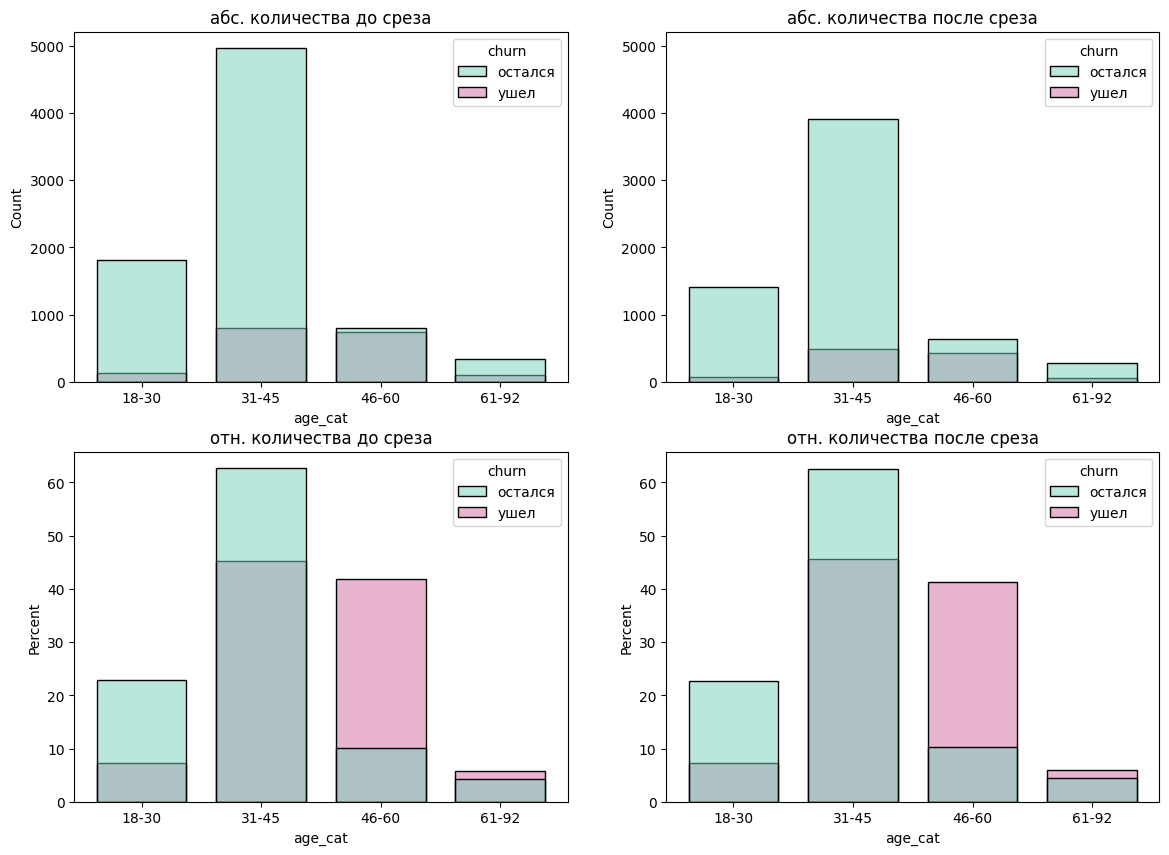

In [76]:
subplots_cat(bank_not_rostov, 'age_cat', leg=True)

Здесь можно увидеть то самое множество пропущенных значений, по которому делался срез в предыдущем пункте.

In [77]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'age_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

age_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0   18-30          127            77          39.0           1.65   
1   31-45          796           480          40.0           1.66   
2   46-60          734           434          41.0           1.69   
3   61-92          100            62          38.0           1.61   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1808          1413          22.0           1.28         1.29  
1         4960          3903          21.0           1.27         1.30  
2          804           640          20.0           1.26         1.35  
3          345           276          20.0           1.25         1.29

Значимых различий не обнаружено.

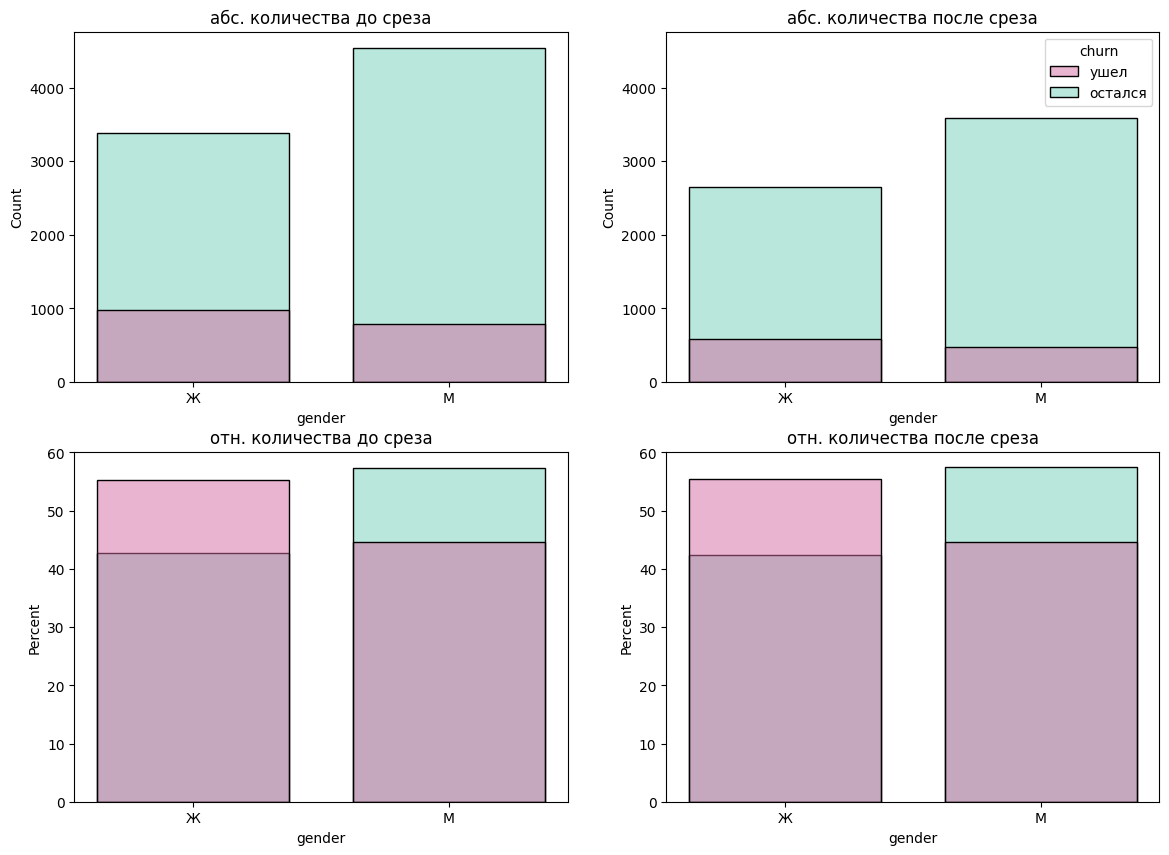

In [78]:
subplots_cat(bank_not_rostov, 'gender')

Различий нет.

In [79]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'gender'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

gender  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  stay_b4_qry  \
0      Ж          972           584          40.0           1.66         3384   
1      М          785           469          40.0           1.67         4533   

   stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          2646          22.0           1.28         1.30  
1          3586          21.0           1.26         1.32

Категорию гендера срез не затронул, ушедшие сократились равномерно.

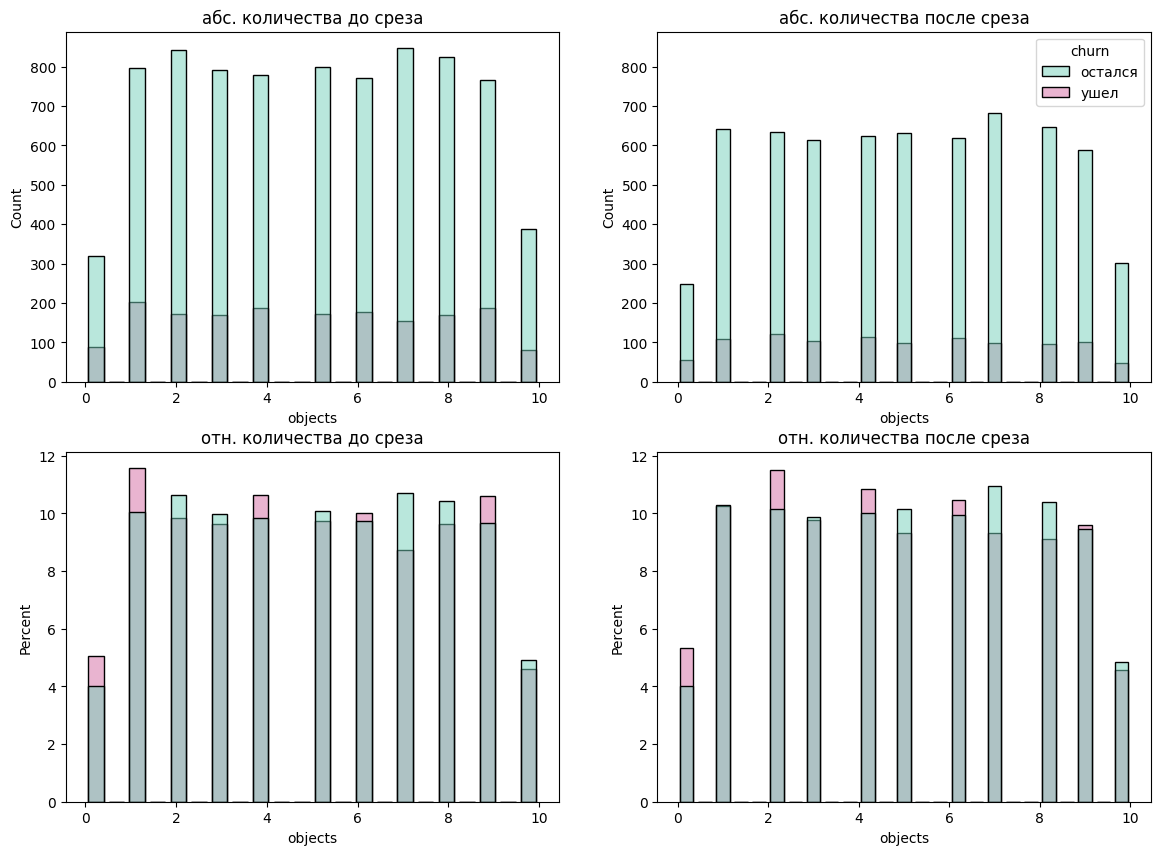

In [80]:
subplots_cat(bank_not_rostov, 'objects')

После среза, доля ушедших клиентов с двумя объектами во владении увеличилась на 4%. Среди остальных подкатегорий, значимых различий нет.

In [81]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'objects').sort_values(by= 'left_dec_pct'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

objects  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
2         2          173           121          30.0           1.43   
7         7          153            98          36.0           1.56   
0         0           89            56          37.0           1.59   
6         6          176           110          38.0           1.60   
3         3          169           103          39.0           1.64   
4         4          187           114          39.0           1.64   
10       10           81            48          41.0           1.69   
5         5          171            98          43.0           1.74   
8         8          169            96          43.0           1.76   
9         9          186           101          46.0           1.84   
1         1          203           108          47.0           1.88   

    stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
2           843           633          25.0           1.33         1.07  
7           846           683          19.0           1.24         1.26  
0           318           249          22.0           1.28         1.24  
6           770           619          20.0           1.24         1.29  
3           790           614          22.0           1.29         1.28  
4           779           623          20.0           1.25         1.31  
10          388           302          22.0           1.28         1.31  
5           798           632          21.0           1.26         1.38  
8           824           647          21.0           1.27         1.38  
9           765           589          23.0           1.30         1.42  
1           796           641          19.0           1.24         1.51

Расчеты говорят, что менее склонны к уходу клиенты с 2 объектами, более склонны - с 1 и 9 объектами, но закономерностей не наблюдается.    
Если рассматривать значения по принципу есть/нет объект в собственности, то значимых различий не видно.

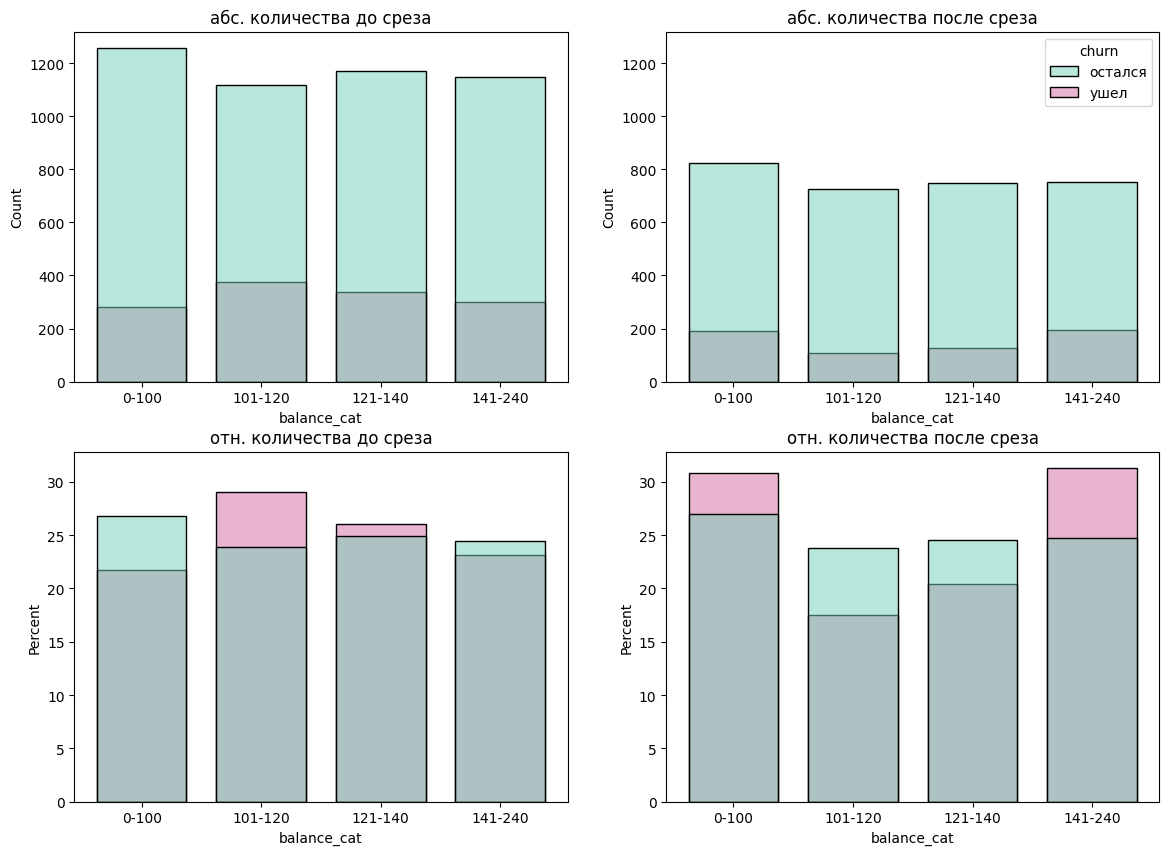

In [82]:
subplots_cat(bank_not_rostov, 'balance_cat')

Срезав Ростов, резко понизилась доля клиентов с балансом 100-140 тыс.руб и соответственно возросла доля остальных клиентов. То есть в Ростове к уходу более склонны клиенты с балансом 100-140 тыс. рублей.

In [83]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'balance_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

balance_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-100          282           190          33.0           1.48   
1     101-120          377           108          71.0           3.49   
2     121-140          338           126          63.0           2.68   
3     141-240          300           193          36.0           1.55   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1256           823          34.0           1.53         0.97  
1         1119           725          35.0           1.54         2.26  
2         1170           747          36.0           1.57         1.71  
3         1147           753          34.0           1.52         1.02

Расчеты подтверждают вывод сделанный выше - ушедших клиентов из Ростова с балансом 0-100 и 141-200 тыс.руб. всего 33% и 36%, в то время как клиентов  балансом 101-120 и 121-140 тыс.руб - 71% и 63% соответственно.

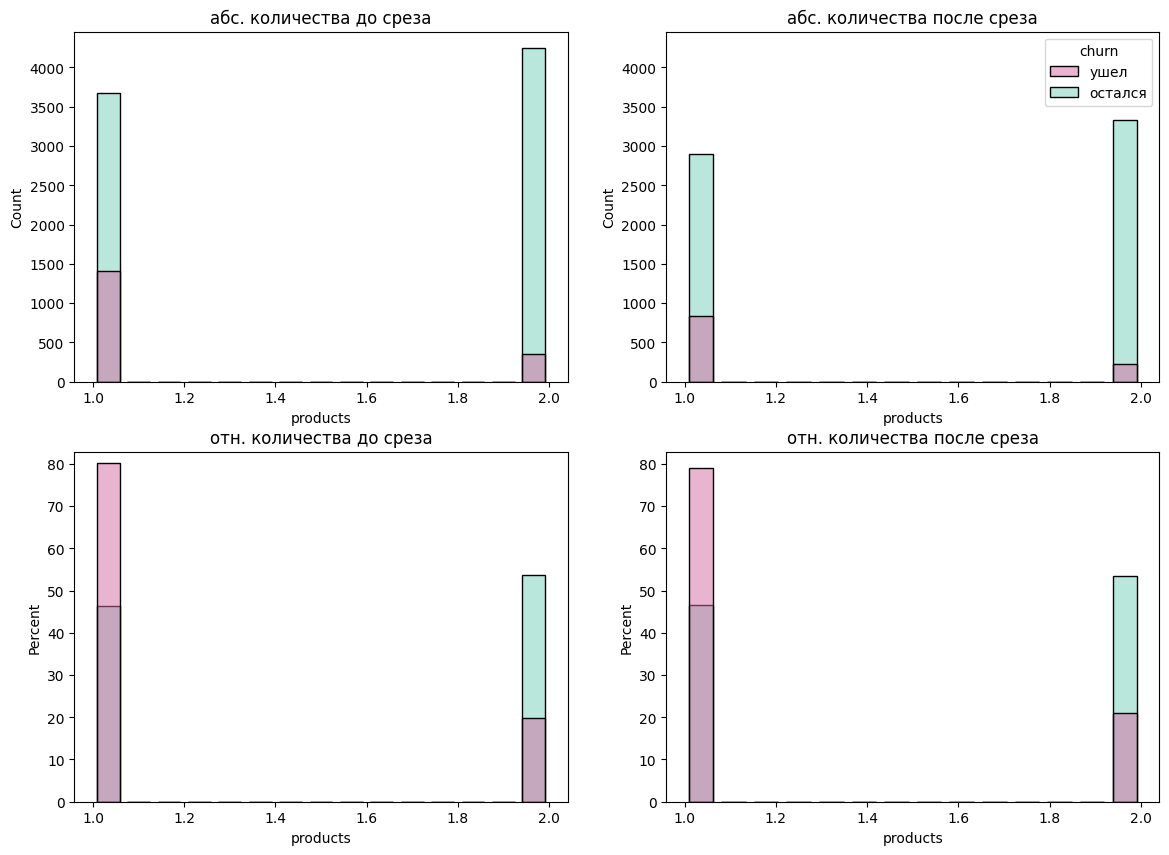

In [84]:
subplots_cat(bank_not_rostov, 'products')

Значения сократились равномерно.

In [85]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'products'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

products  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         1         1409           831          41.0           1.70   
1         2          348           222          36.0           1.57   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         3675          2904          21.0           1.27         1.34  
1         4242          3328          22.0           1.27         1.23

Более склонны к уходу клиенты с одним продуктом (разница 4% от общего).

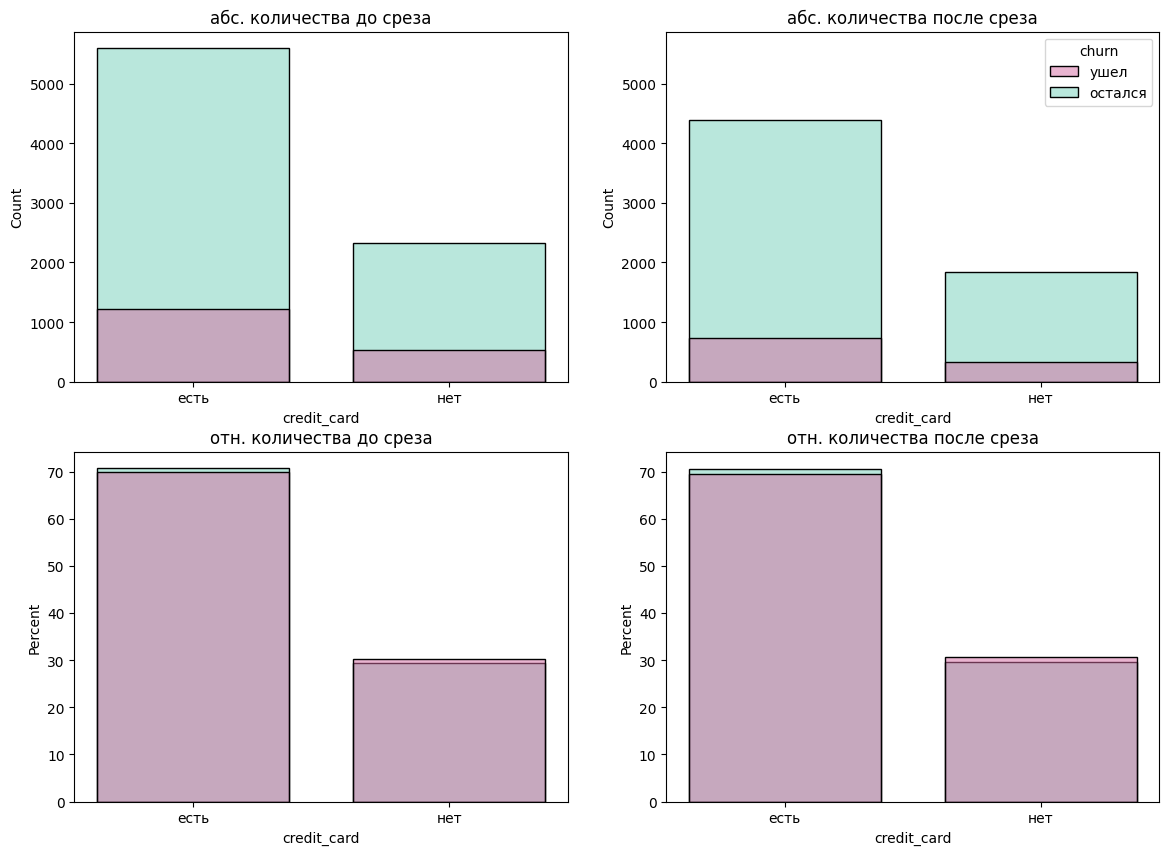

In [86]:
subplots_cat(bank_not_rostov, 'credit_card')

Значения сократились равномерно.

In [87]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'credit_card'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

credit_card  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0        есть         1227           731          40.0           1.68   
1         нет          530           322          39.0           1.65   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         5597          4392          22.0           1.27         1.32  
1         2320          1840          21.0           1.26         1.31

Значения сократились без значимых различий.

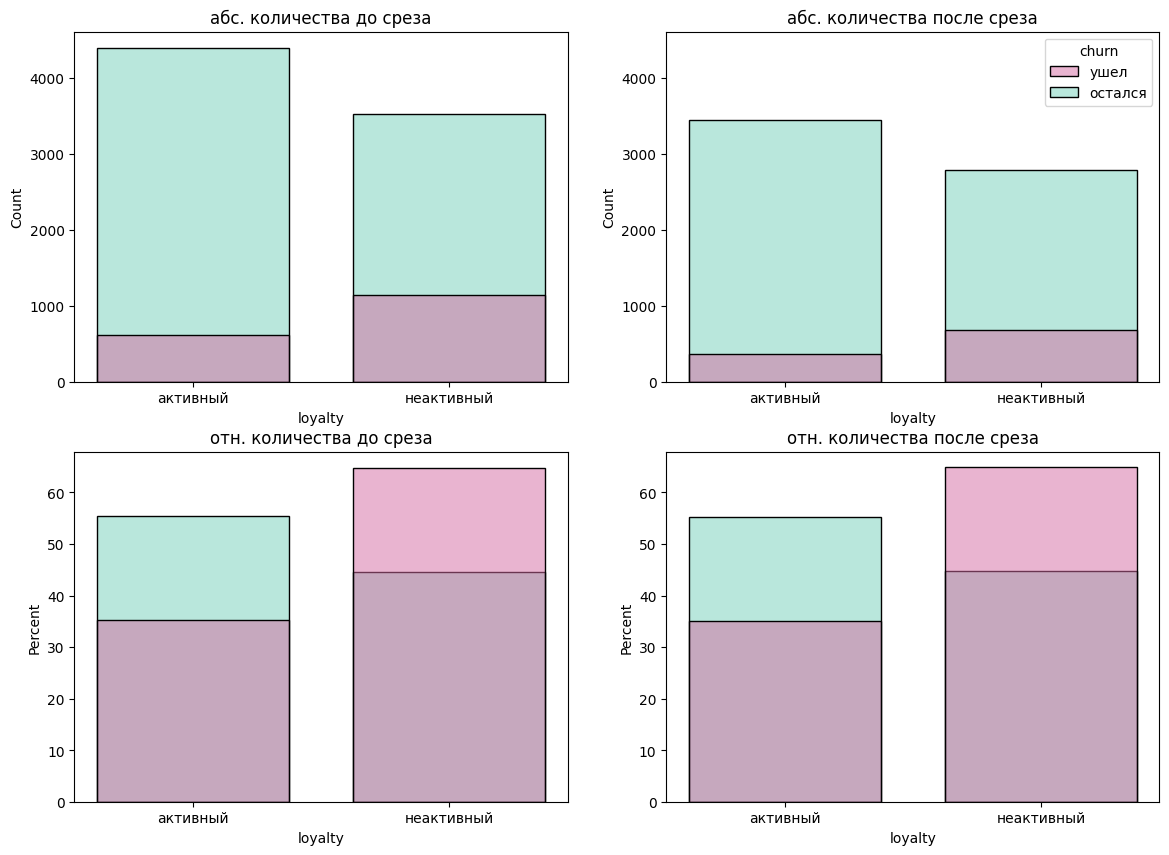

In [88]:
subplots_cat(bank_not_rostov, 'loyalty')

Значения сократились равномерно.

In [89]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'loyalty'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

loyalty  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0    активный          621           370          40.0           1.68   
1  неактивный         1136           683          40.0           1.66   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         4388          3442          22.0           1.27         1.32  
1         3529          2790          21.0           1.26         1.31

Значения сократились равномерно.

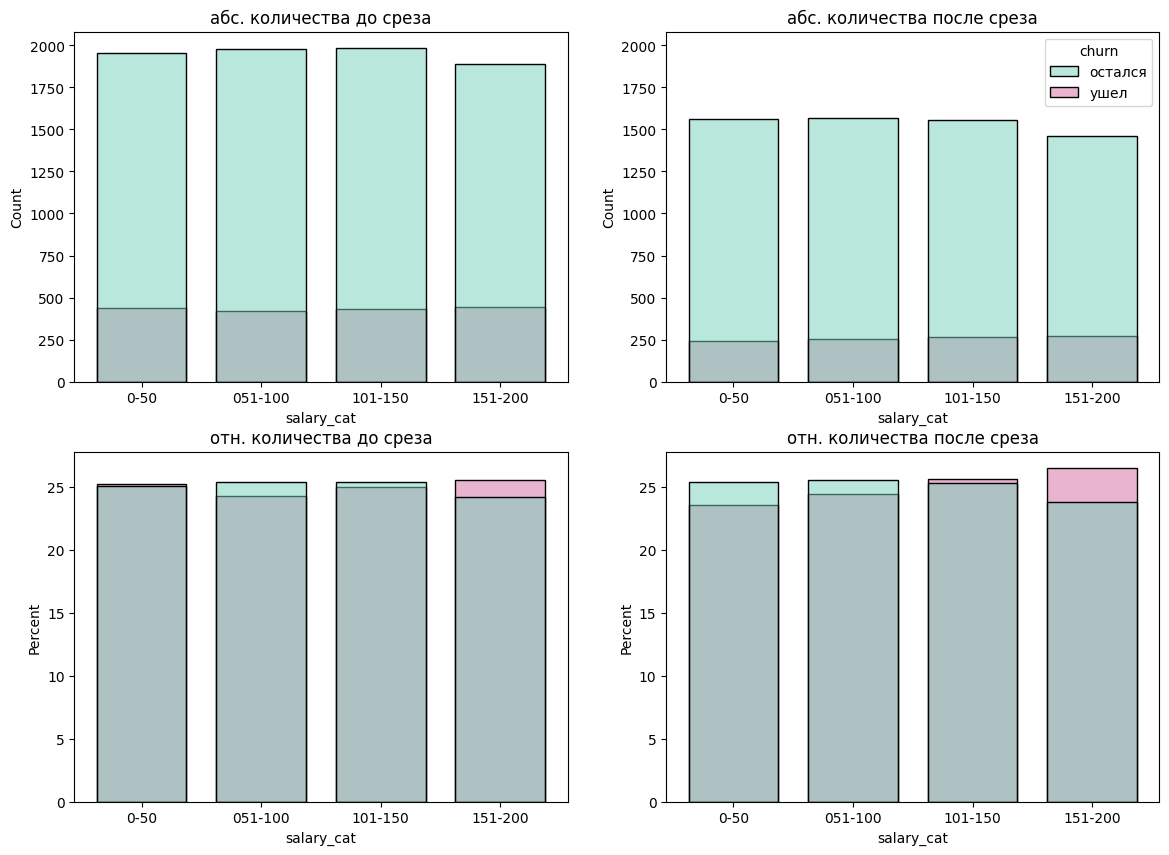

In [90]:
subplots_cat(bank_not_rostov, 'salary_cat')

Значения сократились относително равномерно, клиентов с зарплатой 0-50 тыс.руб. срез коснулся чуть больше, чем остальных

In [91]:
display(dataset_decreased(bank, bank_not_rostov))
display(general_churn_decreased(bank,bank_not_rostov))
display(category_churn_decreased(bank, bank_not_rostov, 'salary_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.33        25.0             1.31

churn  dec_rate  dec_pct
0  остался      1.27     21.0
1     ушел      1.67     40.0

salary_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-50          436           242          44.0           1.80   
1    051-100          419           251          40.0           1.67   
2    101-150          431           263          39.0           1.64   
3    151-200          441           272          38.0           1.62   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1955          1560          20.0           1.25         1.44  
1         1978          1568          21.0           1.26         1.32  
2         1983          1554          22.0           1.28         1.28  
3         1890          1460          23.0           1.29         1.25

Согласно расчетам, в Ростове более склонны к уходу клиенты с з/п 0-100 тыс.руб.

 **Вывод**

Срезав Ростов, количество оставшихся сократилось на 21%, а ушедших на 40%.
Коэффициент ухода меньше, чем в срезе по возрасту, но он так же больше единицы, что говорит о том, что клиенты из Ростова склонны к уходу.

Внутри данного сегмента больше всего склонны к уходу:
* клиенты с высокими значениями скоринга (более 725),
* клиенты с балансом на счету в интервале 101-140 тыс. рублей,
* клиенты обладающие одним банковским продуктом,
* клиенты с зарплатой в интервале 0-100 тыс.рублей.

#### Гендер

Проверим гендерный сегмент - срежем клиентов женского пола.

In [92]:
bank_not_women = bank.query('gender != "Ж"')
bank_not_women.gender.unique()

array(['М'], dtype=object)

In [93]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

Срезав женщин, количество оставшихся сократилось на 43% , а ушедших на 55%.
Коэффициент ухода меньше, чем в срезе по возрасту, но он так же больше единицы (1.28), что говорит о том, что женщины более склонны к уходу, чем мужчины.

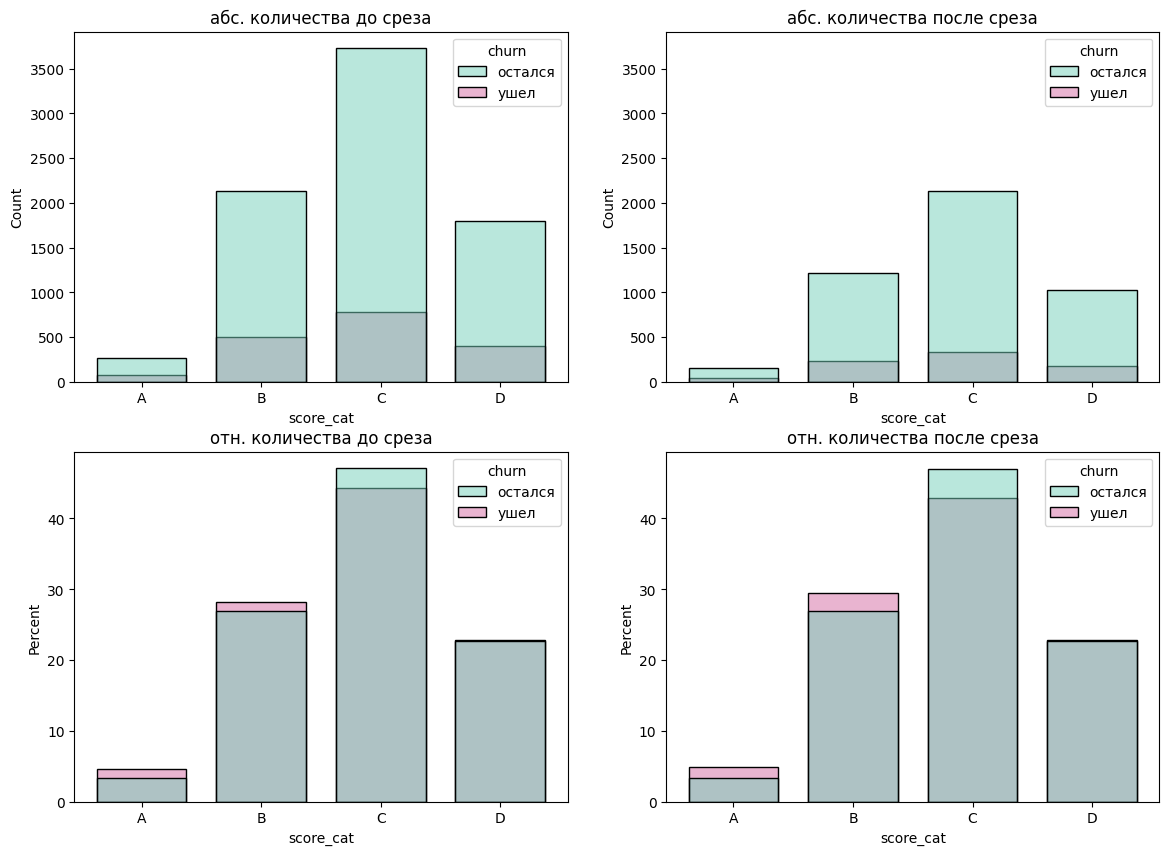

In [94]:
subplots_cat(bank_not_women, 'score_cat', leg=True)

Значения сократились равномерно.

In [95]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'score_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

score_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         A           80            38          52.0           2.11   
1         B          496           231          53.0           2.15   
2         C          779           337          57.0           2.31   
3         D          402           179          55.0           2.25   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          264           151          43.0           1.75         1.20  
1         2128          1221          43.0           1.74         1.23  
2         3727          2132          43.0           1.75         1.32  
3         1798          1029          43.0           1.75         1.29

Значимых различий нет, но женщины из групп высокими значениями скоринга чуть чаще уходят из банка, чем женщины с низкими значениями.

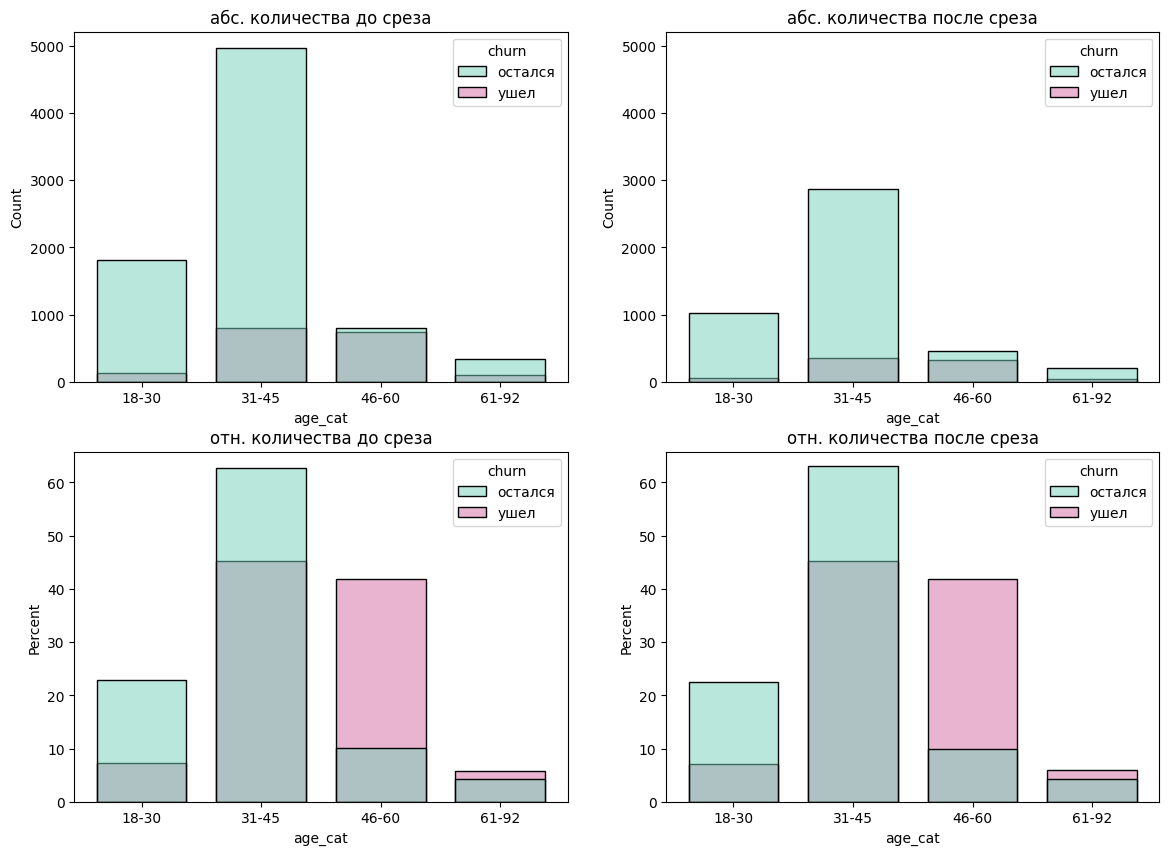

In [96]:
subplots_cat(bank_not_women, 'age_cat', leg=True)

Значения сократились равномерно.

In [97]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'age_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

age_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0   18-30          127            55          57.0           2.31   
1   31-45          796           355          55.0           2.24   
2   46-60          734           328          55.0           2.24   
3   61-92          100            47          53.0           2.13   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1808          1020          44.0           1.77         1.30  
1         4960          2863          42.0           1.73         1.29  
2          804           453          44.0           1.77         1.26  
3          345           197          43.0           1.75         1.21

Значимых различий в катагориях нет,но прослеживается небольшая закономерность - чем старше женщина, тем меньше вероятность, что она уйдет. (18-30 лет - 57% ушедших, 61-92 - 53% ушедших)

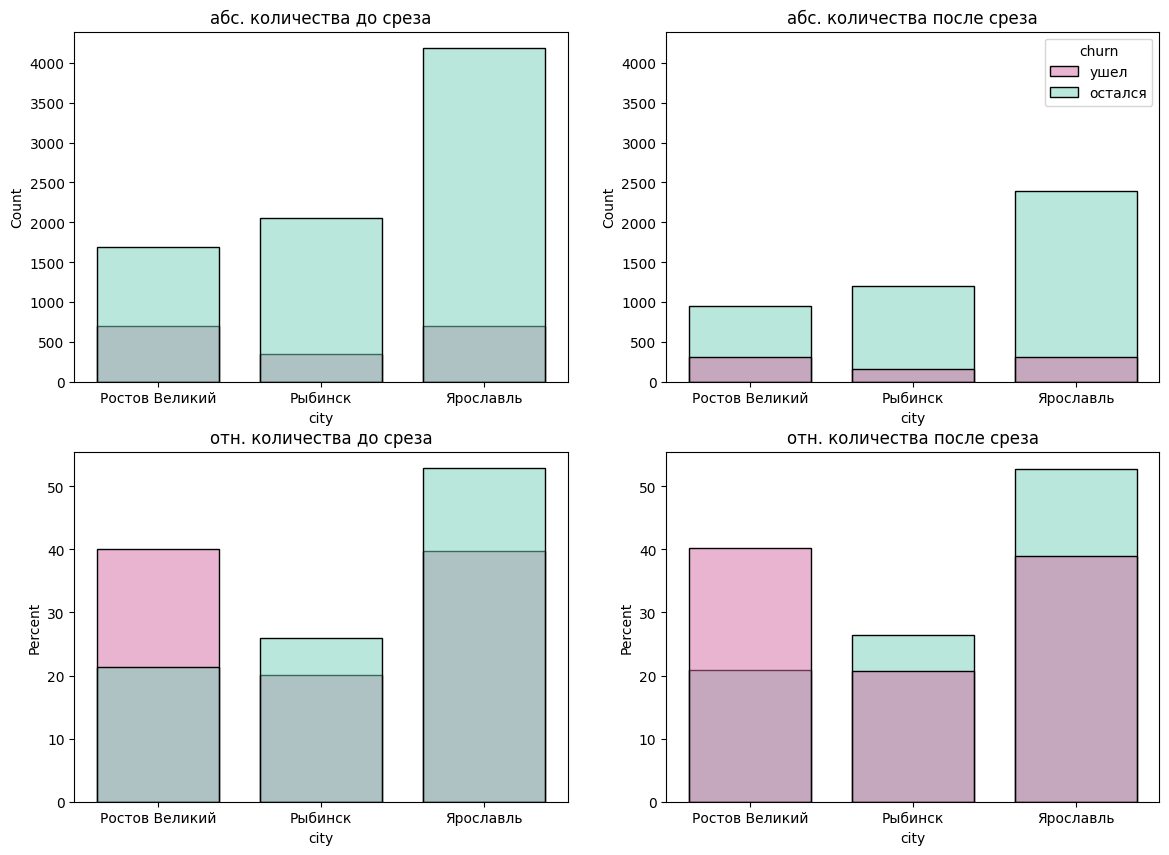

In [98]:
subplots_cat(bank_not_women, 'city')

Значения сократились равномерно.

In [99]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'city'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

city  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0  Ростов Великий          704           316          55.0           2.23   
1         Рыбинск          354           163          54.0           2.17   
2       Ярославль          699           306          56.0           2.28   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1685           947          44.0           1.78         1.25  
1         2050          1198          42.0           1.71         1.27  
2         4182          2388          43.0           1.75         1.30

Разница в значениях небольшая, но женщины из Ярославля чуть более склонны к уходу (разница 1% от общего), чем женщины из остальных городов.

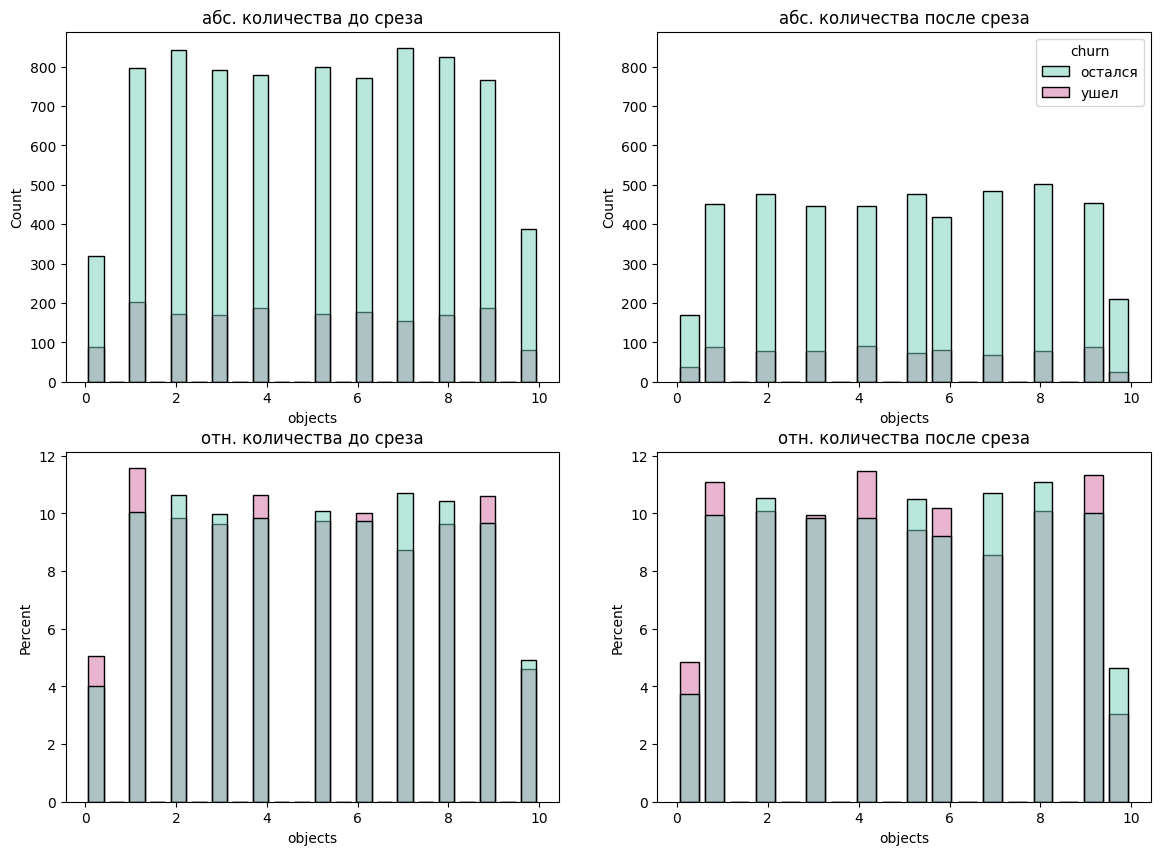

In [100]:
subplots_cat(bank_not_women, 'objects')

По количеству объектов в собственности, все значения, кроме 4, 6 и 10 объектов сократились более-менее равномерно. Женщины у которых от 4 - 6 объектов в собственности менее склонны к уходу, у которых 10 - более.

In [101]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'objects'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

objects  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         0           89            38          57.0           2.34   
1         1          203            87          57.0           2.33   
2         2          173            79          54.0           2.19   
3         3          169            78          54.0           2.17   
4         4          187            90          52.0           2.08   
5         5          171            74          57.0           2.31   
6         6          176            80          55.0           2.20   
7         7          153            67          56.0           2.28   
8         8          169            79          53.0           2.14   
9         9          186            89          52.0           2.09   
10       10           81            24          70.0           3.38   

    stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0           318           169          47.0           1.88         1.24  
1           796           451          43.0           1.76         1.32  
2           843           477          43.0           1.77         1.24  
3           790           445          44.0           1.78         1.22  
4           779           446          43.0           1.75         1.19  
5           798           476          40.0           1.68         1.38  
6           770           418          46.0           1.84         1.19  
7           846           485          43.0           1.74         1.31  
8           824           502          39.0           1.64         1.30  
9           765           454          41.0           1.69         1.24  
10          388           210          46.0           1.85         1.83

Полученные значения повторяют вывод выше - женщины у которых 4 и 6 объектов в собственности менее склонны к уходу, у которых 10 объектов - более склонны к уходу. Но закономерности здесь не наблюдается.

Если рассматривать значения по принципу есть/нет объект в собственности, то принципиальных различий не видно.

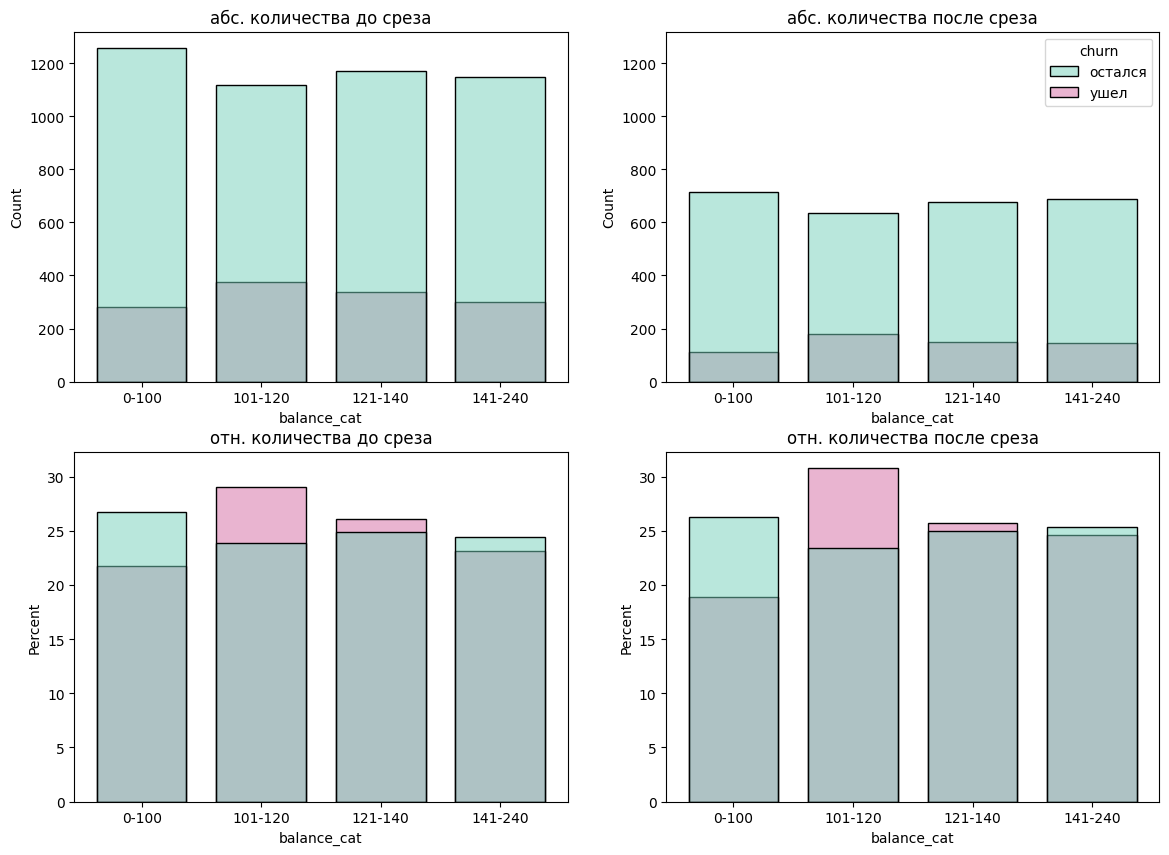

In [102]:
subplots_cat(bank_not_women, 'balance_cat')

Женщины с балансом 0-100 более склонны к уходу, после среза их доля заметно сократилась

In [103]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'balance_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

balance_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-100          282           111          61.0           2.54   
1     101-120          377           181          52.0           2.08   
2     121-140          338           151          55.0           2.24   
3     141-240          300           145          52.0           2.07   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1256           713          43.0           1.76         1.44  
1         1119           636          43.0           1.76         1.18  
2         1170           677          42.0           1.73         1.30  
3         1147           687          40.0           1.67         1.24

Расчеты повторяют вывод сделанный выше - женщины с балансом 0-100 более склонны к уходу

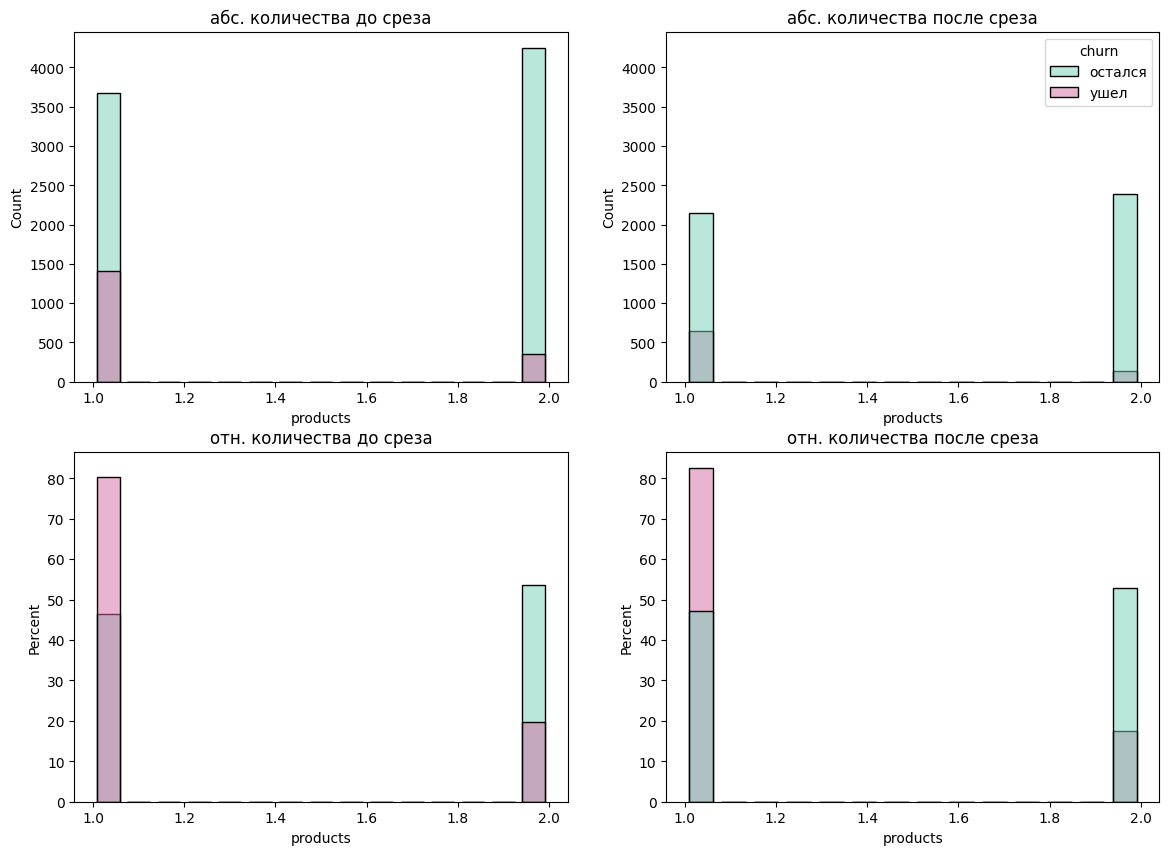

In [104]:
subplots_cat(bank_not_women, 'products')

Значения сократились приблизительно равномерно

In [105]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'products'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

products  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         1         1409           647          54.0           2.18   
1         2          348           138          60.0           2.52   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         3675          2141          42.0           1.72         1.27  
1         4242          2392          44.0           1.77         1.42

Женщины с двумя продуктами более склонны к уходу (60%), чем женщины с одним банковским продуктом (54%).

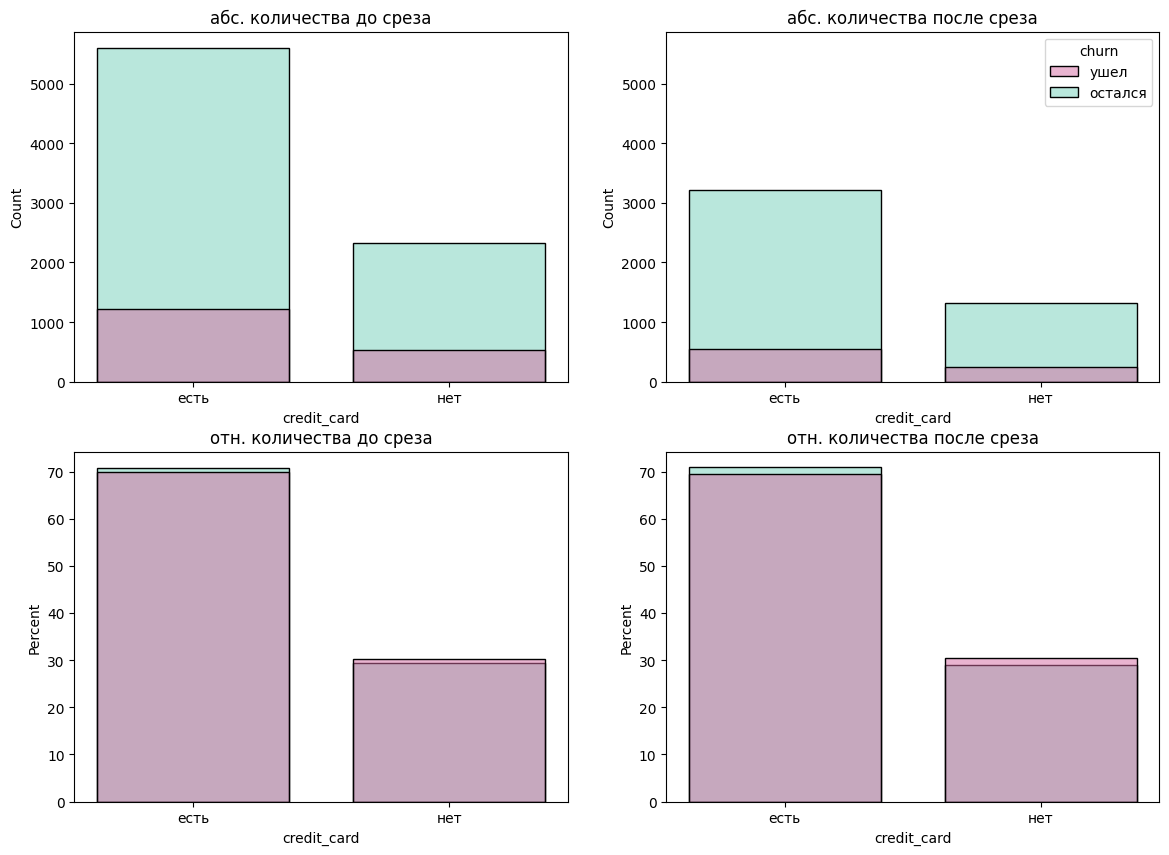

In [106]:
subplots_cat(bank_not_women, 'credit_card')

Значения сократились равномерно.

In [107]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'credit_card'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

credit_card  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0        есть         1227           546          56.0           2.25   
1         нет          530           239          55.0           2.22   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         5597          3216          43.0           1.74         1.29  
1         2320          1317          43.0           1.76         1.26

Значимых различий не обнаружено.

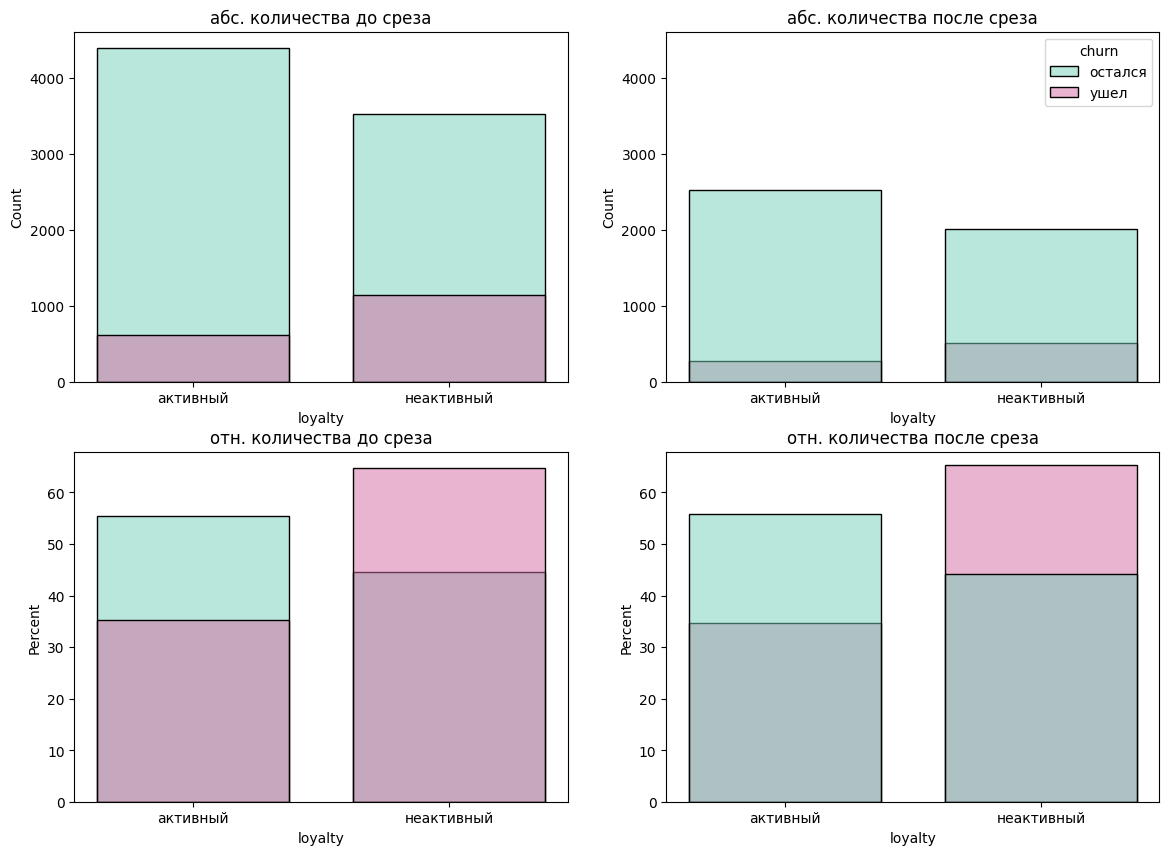

In [108]:
subplots_cat(bank_not_women, 'loyalty')

Значения сократились равномерно.

In [109]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'loyalty'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

loyalty  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0    активный          621           272          56.0           2.28   
1  неактивный         1136           513          55.0           2.21   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         4388          2529          42.0           1.74         1.32  
1         3529          2004          43.0           1.76         1.26

Значимых различий не обнаружено.

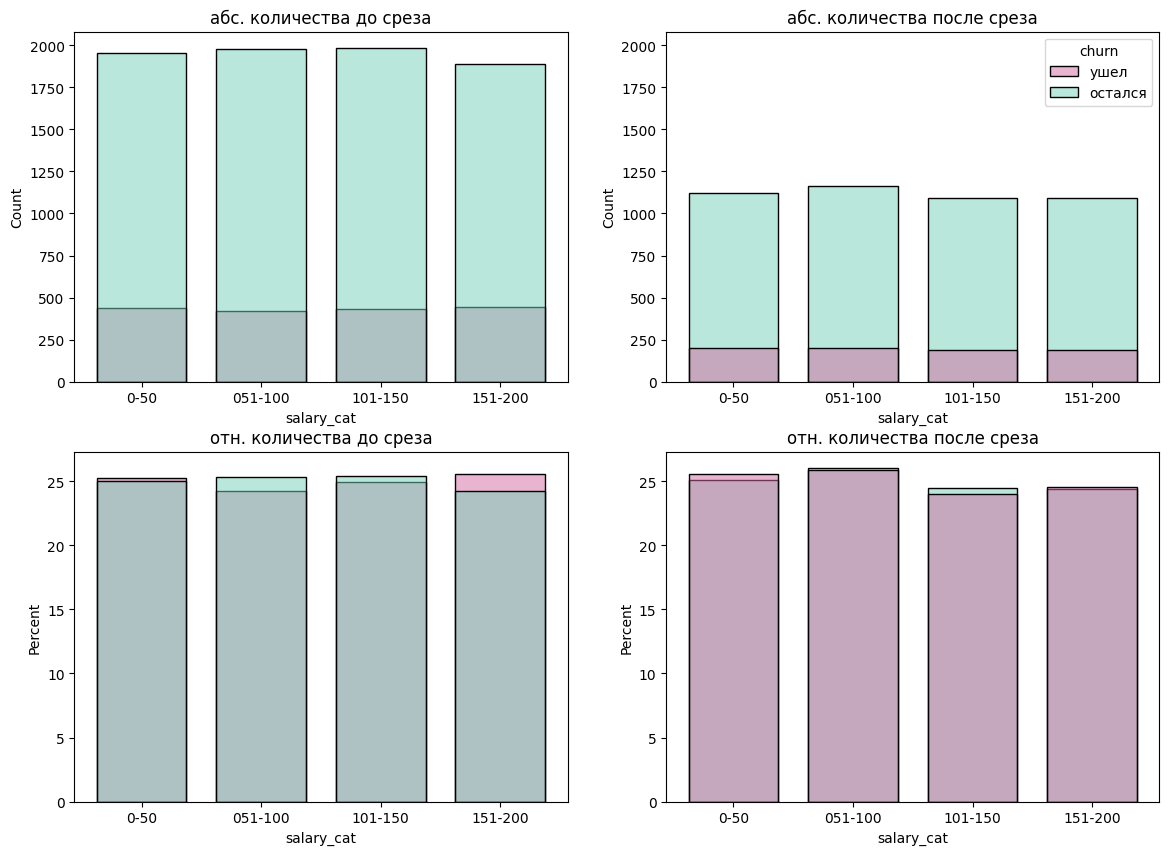

In [110]:
subplots_cat(bank_not_women, 'salary_cat')

Значения сократились равномерно.

In [111]:
display(dataset_decreased(bank, bank_not_women))
display(general_churn_decreased(bank,bank_not_women))
display(category_churn_decreased(bank, bank_not_women, 'salary_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.82        45.0             1.28

churn  dec_rate  dec_pct
0  остался      1.75     43.0
1     ушел      2.24     55.0

salary_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-50          436           197          55.0           2.21   
1    051-100          419           199          53.0           2.11   
2    101-150          431           185          57.0           2.33   
3    151-200          441           189          57.0           2.33   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1955          1123          43.0           1.74         1.27  
1         1978          1164          41.0           1.70         1.24  
2         1983          1095          45.0           1.81         1.29  
3         1890          1093          42.0           1.73         1.35

Женщины с зарплатой от 101 тыс.руб более склонны к уходу (57% ушедших), чем женщины с меньшей зарплатой (54% ушедших).

**Вывод**

Срезав женщин, количество оставшихся сократилось на 43% , а ушедших на 55%.
Коэффициент ухода меньше, чем в срезе по возрасту, но он так же больше единицы (1.28), что говорит о том, что женщины более склонны к уходу, чем мужчины.

Внутри данного сегмента больше всего склонны к уходу:
* женщины с высокими значениями банковского скоринга (больше 600),
* женщины возраста 18-30 лет,
* женщины из Ярославля,
* женщины с балансом на счету в интеовале 0-100 тыс. рублей,
* женщины, обладающие двумя банковскими продуктами,
* женщины с зарплатой более 100 тысяч рублей.

#### Продукты

Проверим продуктовый сегмент - срежем клиентов с одним банковским продуктом.

In [112]:
bank_prod_2 = bank.query('products == 2').sort_values(by= 'churn')
bank_prod_2.products.unique()

array([2])

In [113]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

Убрав клиентов, с одним продуктом, мы сократили количество ушедших на 80%, то есть с двумя банковскими продуктами всего 20% ушедших клиентов. Количество оставшихся клиентов сократилось на 46%. Общий коэффициент ухода составляет 2.71, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 2.71 раз. Это дает основания полагать, что клиенты с одним пролуктом более склонны к уходу.

Рассмотрим кто из клиентов с одним продуктом чаще уходит.

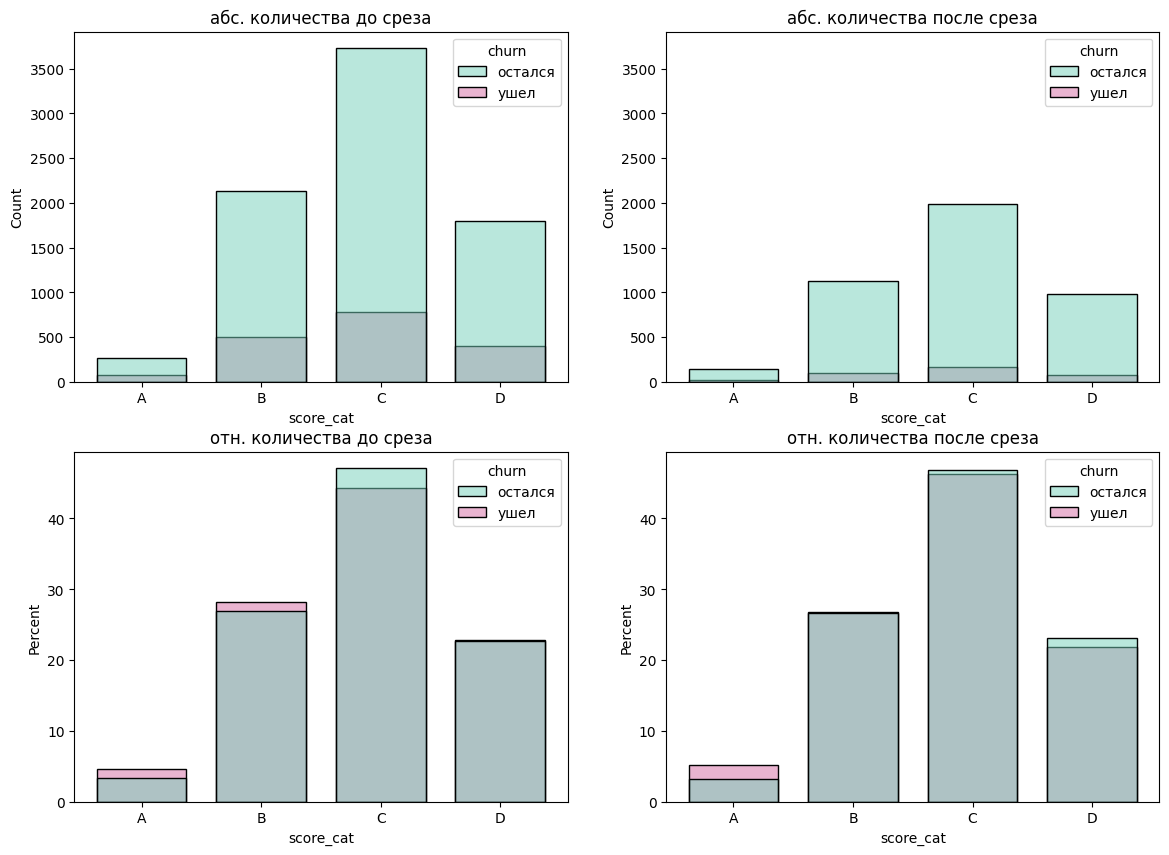

In [114]:
subplots_cat(bank_prod_2, 'score_cat', leg=True)

Значимых различий не видно.

In [115]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'score_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

score_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         A           80            18          78.0           4.44   
1         B          496            93          81.0           5.33   
2         C          779           161          79.0           4.84   
3         D          402            76          81.0           5.29   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          264           139          47.0           1.90         2.34  
1         2128          1131          47.0           1.88         2.83  
2         3727          1990          47.0           1.87         2.58  
3         1798           982          45.0           1.83         2.89

Разница в значениях небольшая, но клиенты с низкими значениями скоринга менее склонны к уходу.

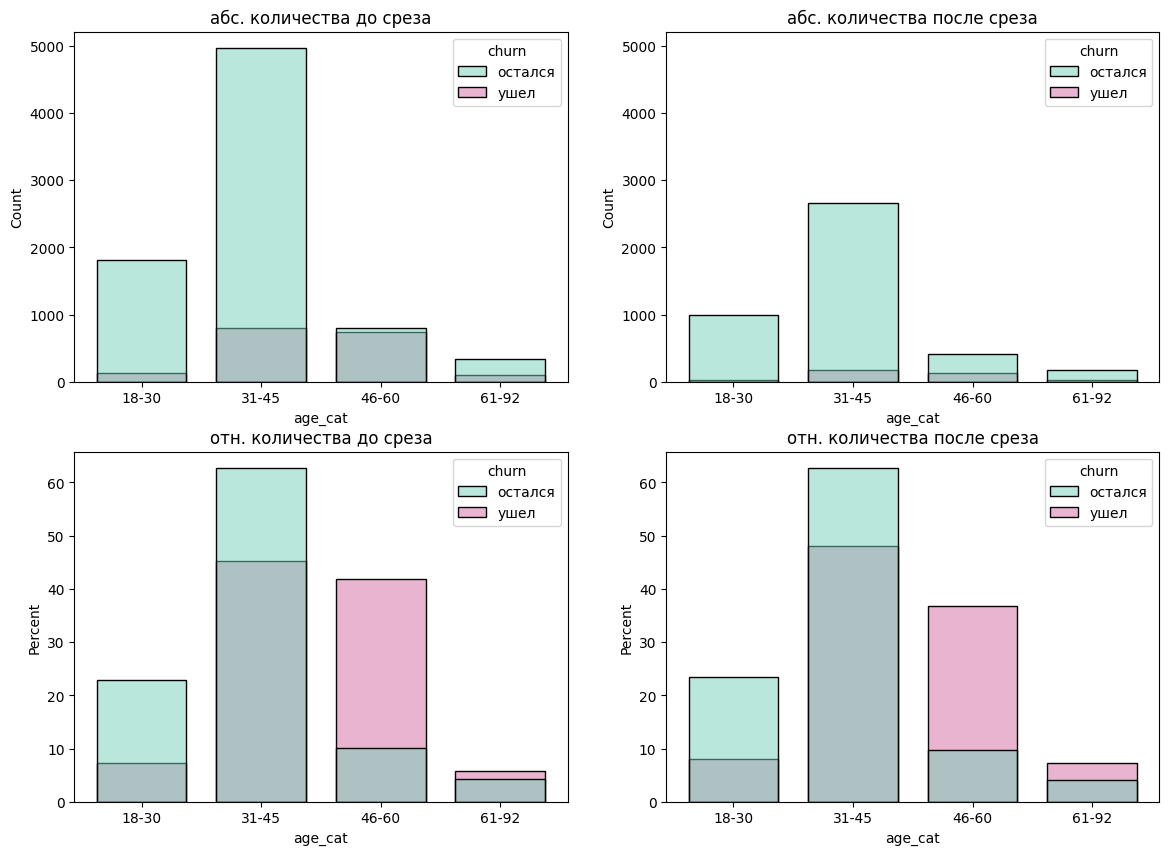

In [116]:
subplots_cat(bank_prod_2, 'age_cat', leg=True)

Видно, что после среза снизилась доля ушедших клиентов возраста 46-60 и повысилась доля ушедших клиентов возраста 61-90 - первых срез затронул больше, вторых меньше.

In [117]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'age_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

age_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0   18-30          127            28          78.0           4.54   
1   31-45          796           167          79.0           4.77   
2   46-60          734           128          83.0           5.73   
3   61-92          100            25          75.0           4.00   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1808           997          45.0           1.81         2.50  
1         4960          2659          46.0           1.87         2.56  
2          804           415          48.0           1.94         2.96  
3          345           171          50.0           2.02         1.98

Согласно расчетам больше всего склонны к уходу клиенты возраста 46-60 (83% ушедших), чуть менее склонны клиенты возраста 18-45 лет (78-79%) и еще менее склонны клиенты возраста 61-92 года (75%).

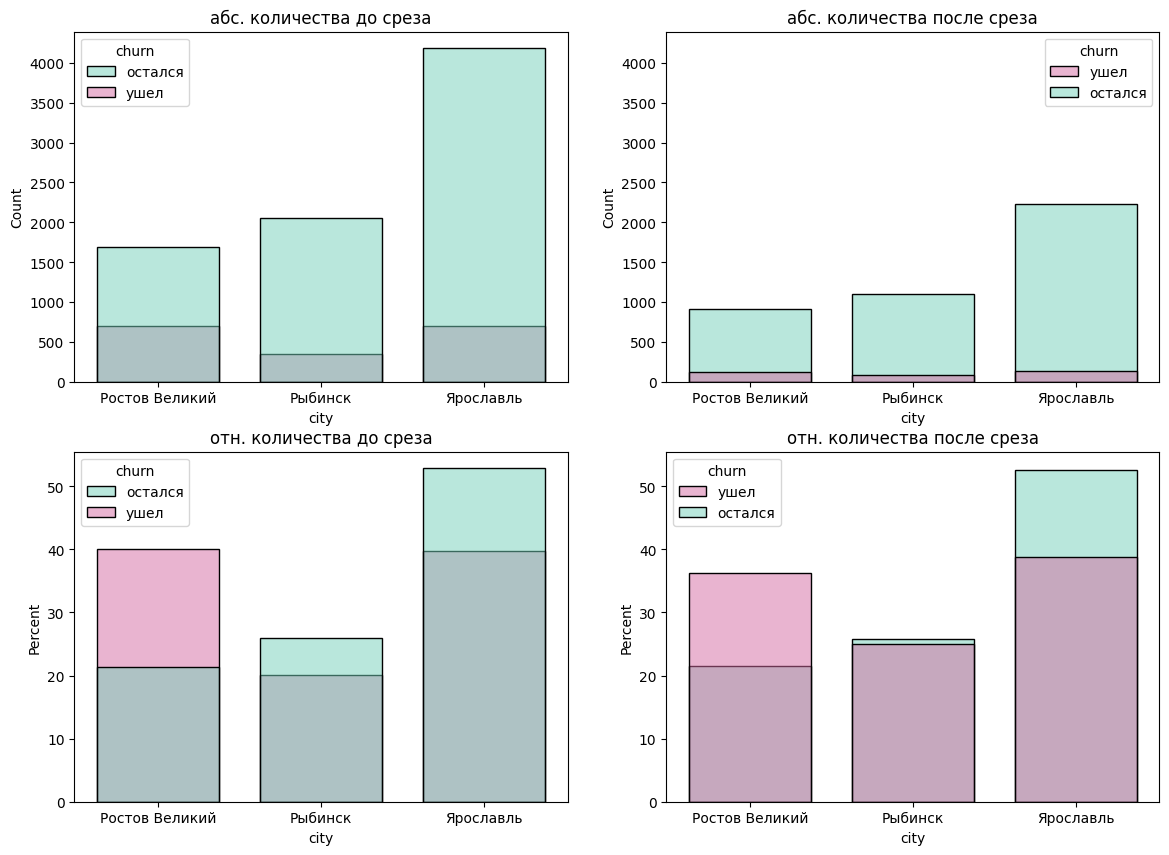

In [118]:
subplots_cat(bank_prod_2, 'city', leg= True)

После среза, доля ушедших снизилась в Ростове и в Ярославле. В Рыбинске доля наоборот, повысилась.

In [119]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'city'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

city  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0  Ростов Великий          704           126          82.0           5.59   
1         Рыбинск          354            87          75.0           4.07   
2       Ярославль          699           135          81.0           5.18   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1685           914          46.0           1.84         3.03  
1         2050          1096          47.0           1.87         2.18  
2         4182          2232          47.0           1.87         2.76

Расчеты говорят, что клиенты с одним продуктом чаще уходят из Ростова и Ярославля (82 и 81%), чем из Рыбинска (75%).

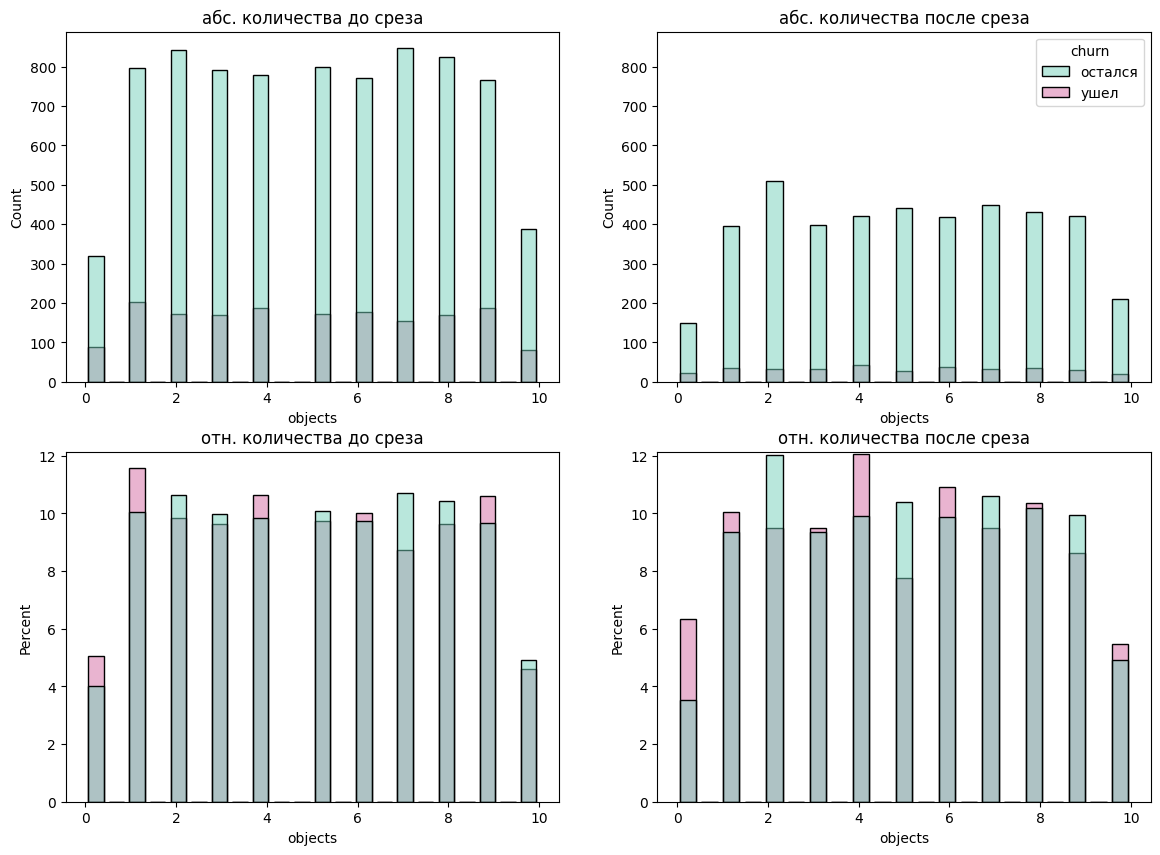

In [120]:
subplots_cat(bank_prod_2, 'objects')

По количеству объектов в собственности, все значения, кроме 0, 2, 5 и 9 объектов сократились более-менее равномерно. Клиенты у которых нет объектов в собственности менее склонны к уходу, у которых 2, 5 и 9 - более.

In [121]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'objects'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

objects  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         0           89            22          75.0           4.05   
1         1          203            35          83.0           5.80   
2         2          173            33          81.0           5.24   
3         3          169            33          80.0           5.12   
4         4          187            42          78.0           4.45   
5         5          171            27          84.0           6.33   
6         6          176            38          78.0           4.63   
7         7          153            33          78.0           4.64   
8         8          169            36          79.0           4.69   
9         9          186            30          84.0           6.20   
10       10           81            19          77.0           4.26   

    stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0           318           149          53.0           2.13         1.90  
1           796           396          50.0           2.01         2.89  
2           843           510          40.0           1.65         3.17  
3           790           397          50.0           1.99         2.57  
4           779           420          46.0           1.85         2.40  
5           798           441          45.0           1.81         3.50  
6           770           418          46.0           1.84         2.51  
7           846           449          47.0           1.88         2.46  
8           824           432          48.0           1.91         2.46  
9           765           421          45.0           1.82         3.41  
10          388           209          46.0           1.86         2.30

Полученные значения повторяют вывод выше - по количеству объектов в собственности, все значения, кроме 0, 2, 5 и 9 объектов сократились более-менее равномерно. Клиенты у которых от нет объектов в собственности менее склонны к уходу, у которых 2, 5 и 9 - более.

Если рассматривать значения по принципу есть/нет объект в собственности, то клиенты с одним продуктом и без собственности менее склонны к уходу.

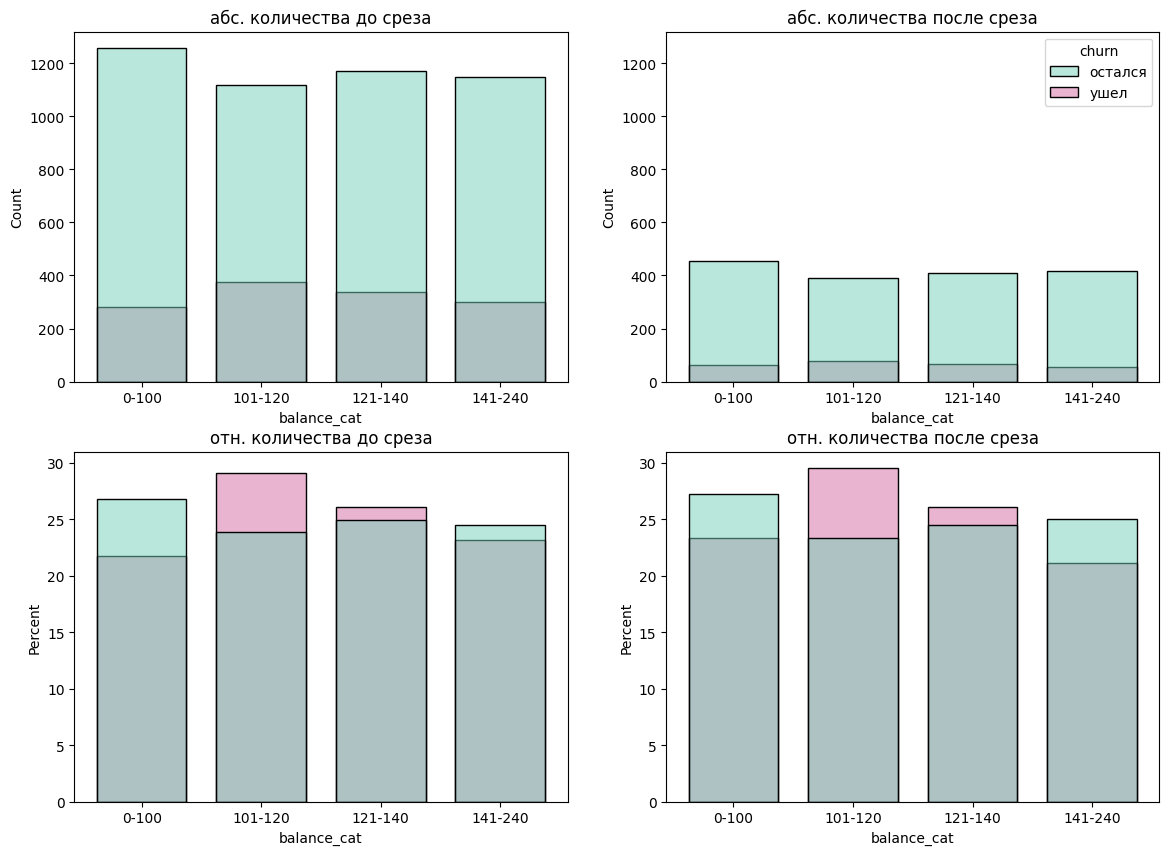

In [122]:
subplots_cat(bank_prod_2, 'balance_cat')

Принципиальных различий по графику не видно.

In [123]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'balance_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

balance_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-100          282            61          78.0           4.62   
1     101-120          377            77          80.0           4.90   
2     121-140          338            68          80.0           4.97   
3     141-240          300            55          82.0           5.45   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1256           455          64.0           2.76         1.67  
1         1119           390          65.0           2.87         1.71  
2         1170           410          65.0           2.85         1.74  
3         1147           418          64.0           2.74         1.99

Расчеты показывают, что срезом убрало от 78 до 82% ушедших клиентов в зависимости от подкатегории, что сопоставимо с 80% ушедших в общем расчете по категориям ушел/остался.

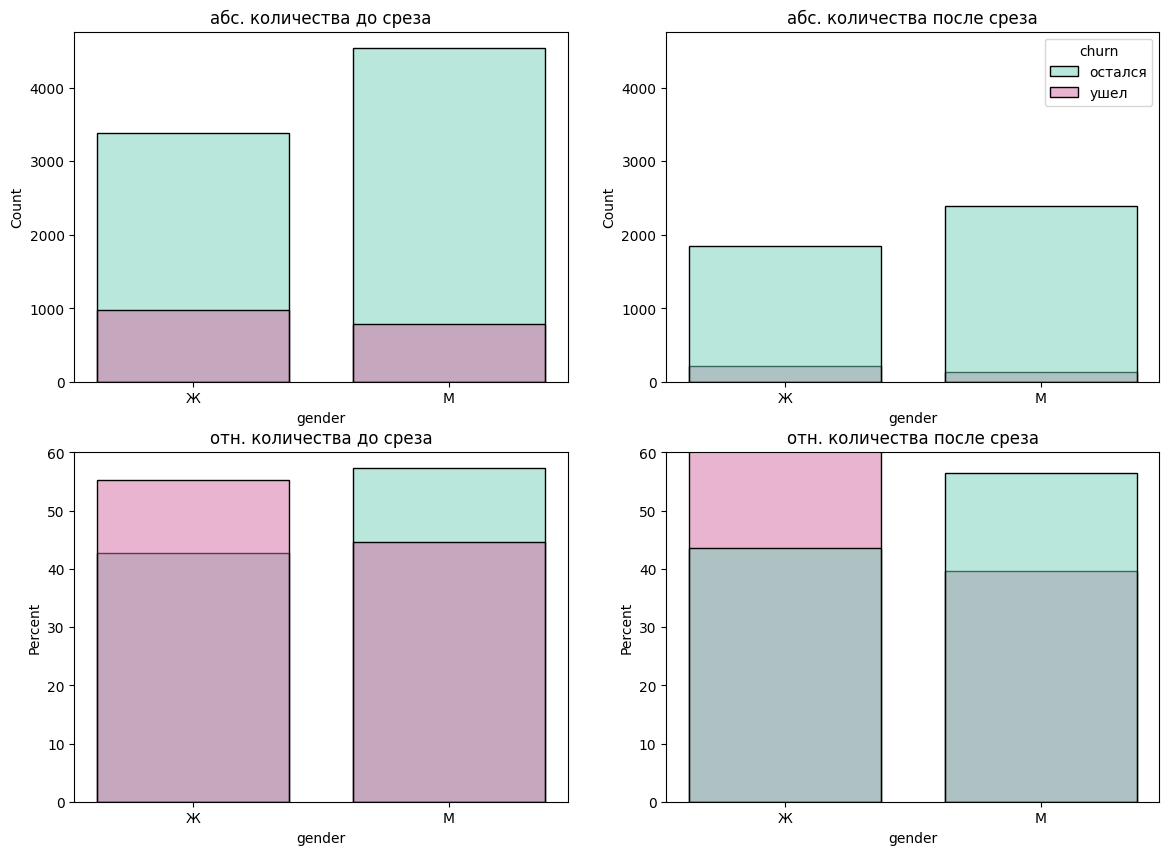

In [124]:
subplots_cat(bank_prod_2, 'gender')

После среза, доля ушедших мужчин понизилась, а женщин повысилась - значит мужчин с одним банковским продуктом уходит больше, чем женщин.

In [125]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'gender'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

gender  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  stay_b4_qry  \
0      Ж          972           210          78.0           4.63         3384   
1      М          785           138          82.0           5.69         4533   

   stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          1850          45.0           1.83         2.53  
1          2392          47.0           1.90         3.00

Расчеты подтверждают вывод сделанный выше - ушедших с одним продуктом мужчин на 4%больше, чем женщин.

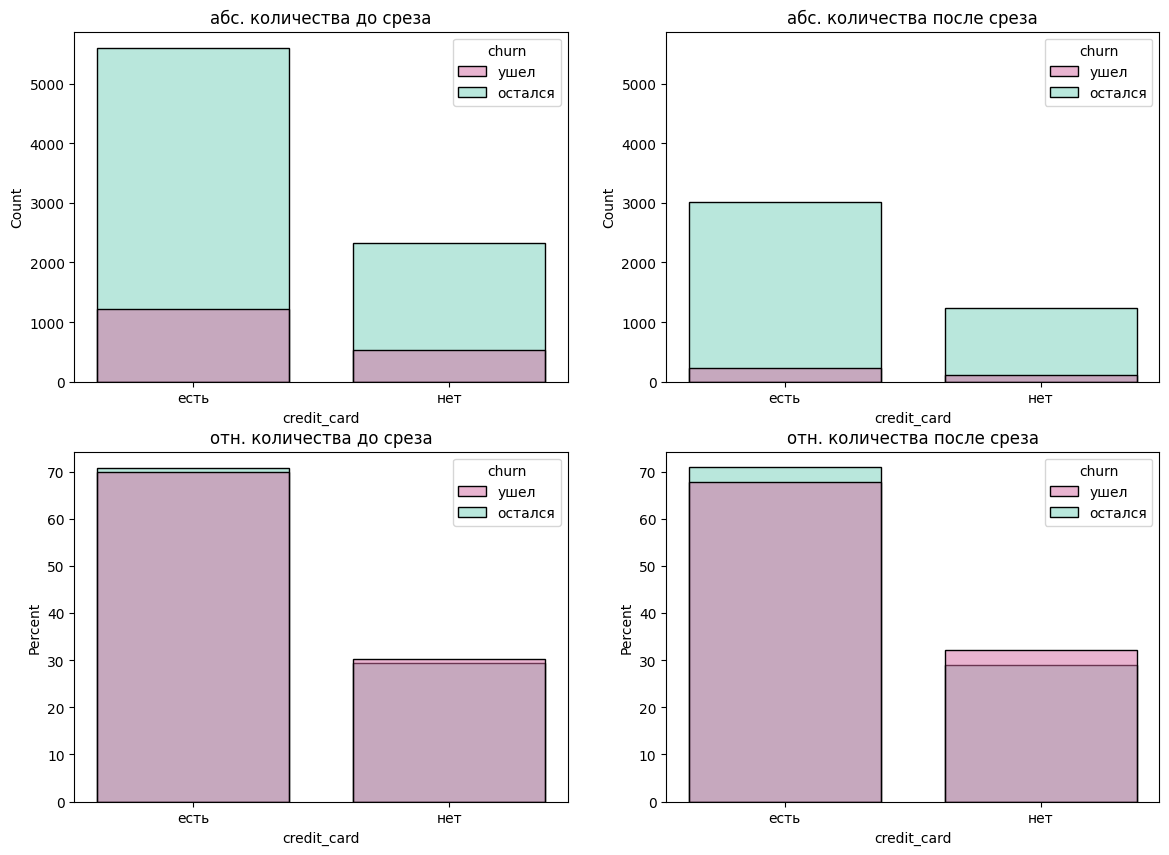

In [126]:
subplots_cat(bank_prod_2, 'credit_card', leg= True)

После среза, доля ушедших клиентов с кредитной картой понизилась, а клиентов без нее повысилась - значит клиентов с кредитной картой уходит больше, чем без нее.

In [127]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'credit_card'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

credit_card  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0        есть         1227           236          81.0           5.20   
1         нет          530           112          79.0           4.73   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         5597          3010          46.0           1.86         2.80  
1         2320          1232          47.0           1.88         2.51

Разница в между подкатегориями небольшая, но, ушедших клиентов с кредитной картой на 2% больше, чем ушедших без нее.

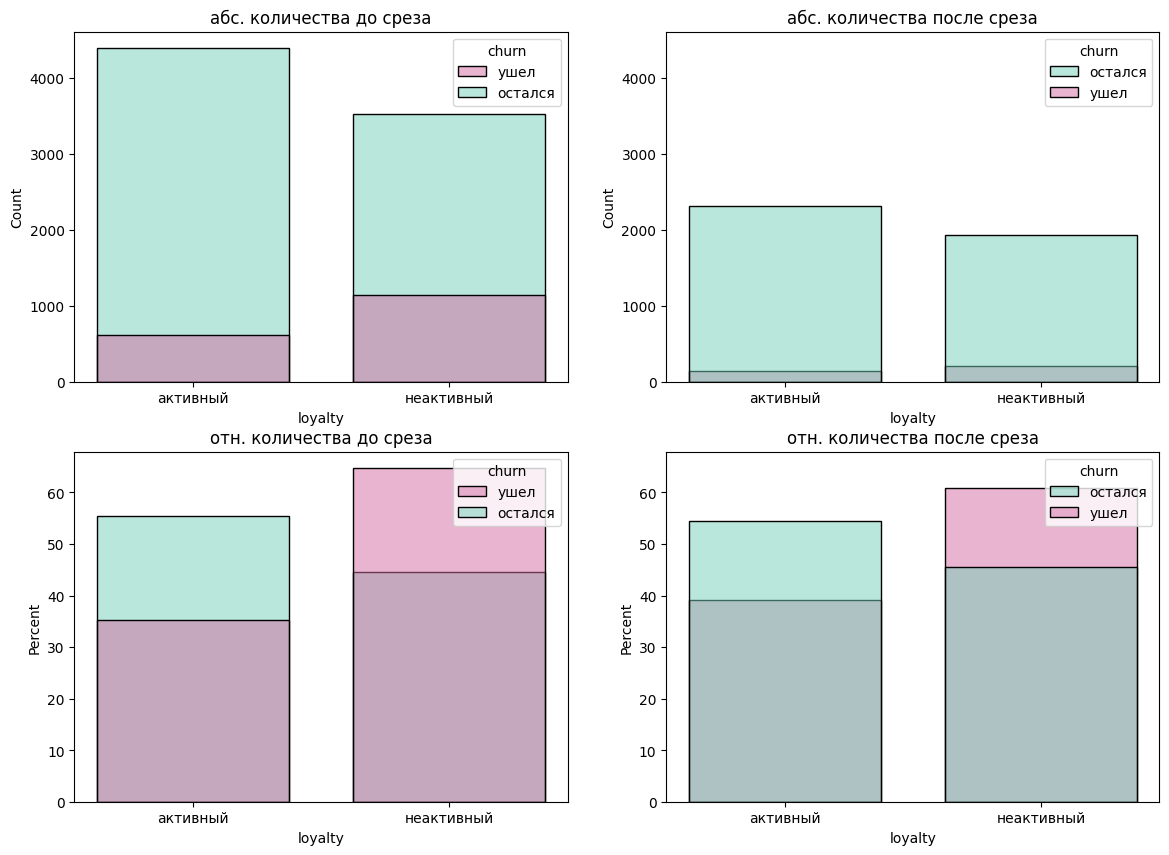

In [128]:
subplots_cat(bank_prod_2, 'loyalty', leg= True)

После среза, доля ушедших неакивных клиентов понизилась, а активных клиентов повысилась - значит неактивных клиентов уходит больше, чем активных.

In [129]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'loyalty'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

loyalty  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0    активный          621           136          78.0           4.57   
1  неактивный         1136           212          81.0           5.36   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         4388          2310          47.0           1.90         2.40  
1         3529          1932          45.0           1.83         2.93

Разница в между подкатегориями небольшая, но, ушедших неактивных клиентов на 3% больше, чем активных.

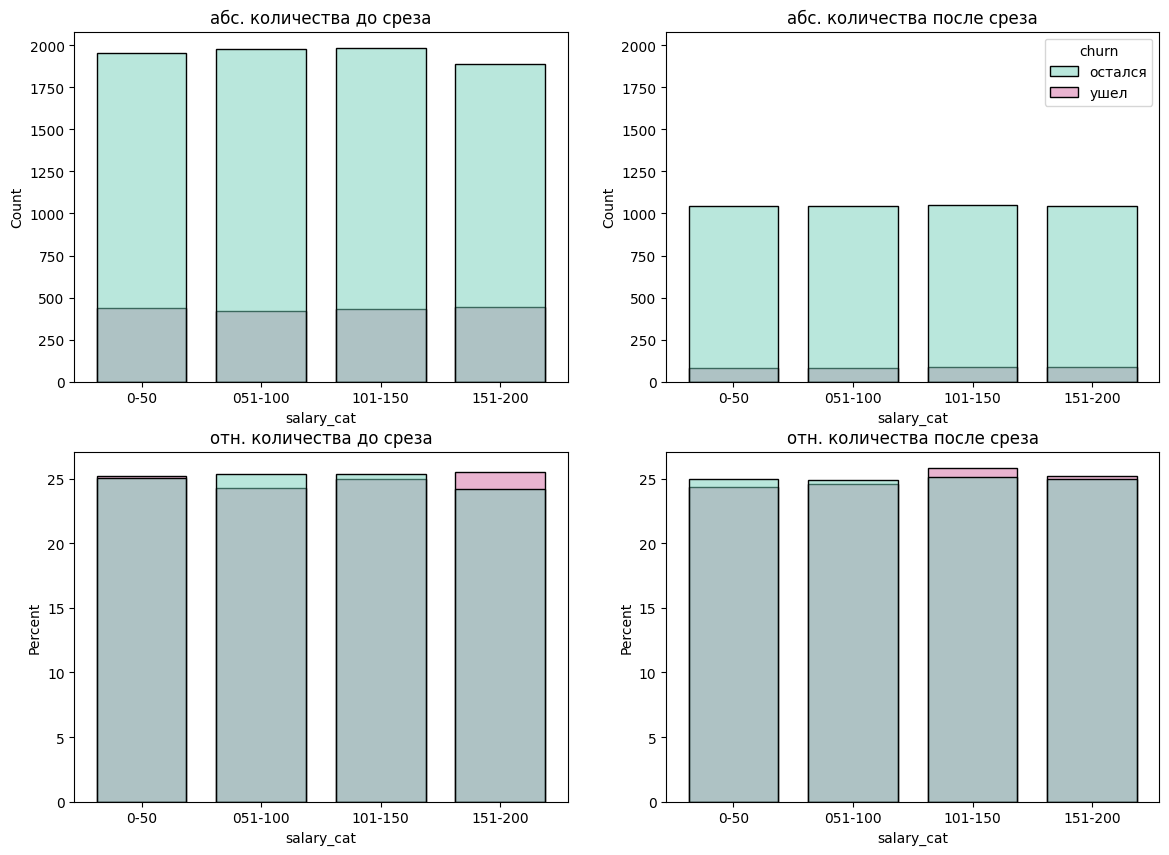

In [130]:
subplots_cat(bank_prod_2, 'salary_cat')

Значения сократились относително равномерно, клиентов с зарплатой 0-50 и 151-200 тыс.руб. срез коснулся чуть больше, чем остальных

In [131]:
display(dataset_decreased(bank, bank_prod_2))
display(general_churn_decreased(bank,bank_prod_2))
display(category_churn_decreased(bank, bank_prod_2, 'salary_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         2.11        53.0             2.71

churn  dec_rate  dec_pct
0  остался      1.87     46.0
1     ушел      5.05     80.0

salary_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-50          436            82          81.0           5.32   
1    051-100          419            83          80.0           5.05   
2    101-150          431            87          80.0           4.95   
3    151-200          441            85          81.0           5.19   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1955          1045          47.0           1.87         2.84  
1         1978          1043          47.0           1.90         2.66  
2         1983          1050          47.0           1.89         2.62  
3         1890          1045          45.0           1.81         2.87

Значимых различий не наблюдается

**Вывод**

Убрав клиентов, с одним продуктом, мы сократили количество ушедших на 80%, то есть с двумя банковскими продуктами всего 20% ушедших клиентов. Количество оставшихся клиентов сократилось на 46%. Общий коэффициент ухода составляет 2.71, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 2.71 раз. Это дает основания полагать, что клиенты с одним пролуктом более склонны к уходу.

Внутри данного сегмента больше всего склонны к уходу:
* клиенты в возрасте 46-60 лет,
* клиенты из Ростова и Ярославля,
* мужчины,
* клиенты с кредитной картой,
* неактивные клиенты,
* клиенты с зарплатой в интервале 0-50 тыс.рублей и 151-200 тыс.рублей.

#### Активность

Рассмотрим распределение ушедших и оставшихся клиентов в разрезе по активности.

In [132]:
bank_loyal = bank.query('loyalty != "неактивный"')
bank_loyal.loyalty.unique()

array(['активный'], dtype=object)

In [133]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

Убрав неактивных клиентов, мы сократили количество ушедших на 65%, то есть среди активных клиентов 35% ушедших. Количество оставшихся клиентов сократилось на 45%. Общий коэффициент ухода составляет 1.57, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 1.57 раз. Это дает основания полагать, что неактивные клиенты более склонны к уходу.

Рассмотрим кто из неактивных клиентов уходит чаще.

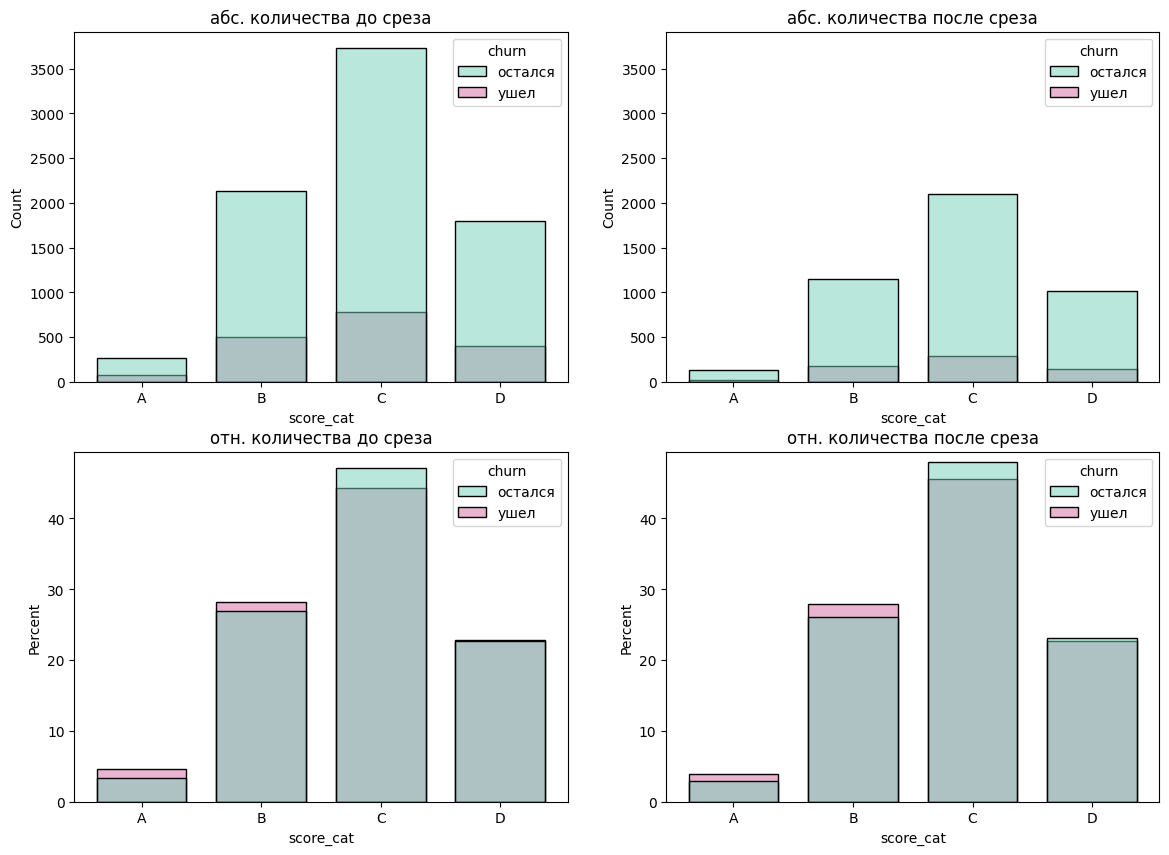

In [134]:
subplots_cat(bank_loyal, 'score_cat', leg=True)

Принципиальных различий не видно.

In [135]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'score_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

score_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         A           80            24          70.0           3.33   
1         B          496           173          65.0           2.87   
2         C          779           283          64.0           2.75   
3         D          402           141          65.0           2.85   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          264           127          52.0           2.08         1.60  
1         2128          1144          46.0           1.86         1.54  
2         3727          2104          44.0           1.77         1.55  
3         1798          1013          44.0           1.77         1.61

Среди неактивных клиентов чаще уходят клиенты с низким значением банковского скоринга (на 5% больше остальных).

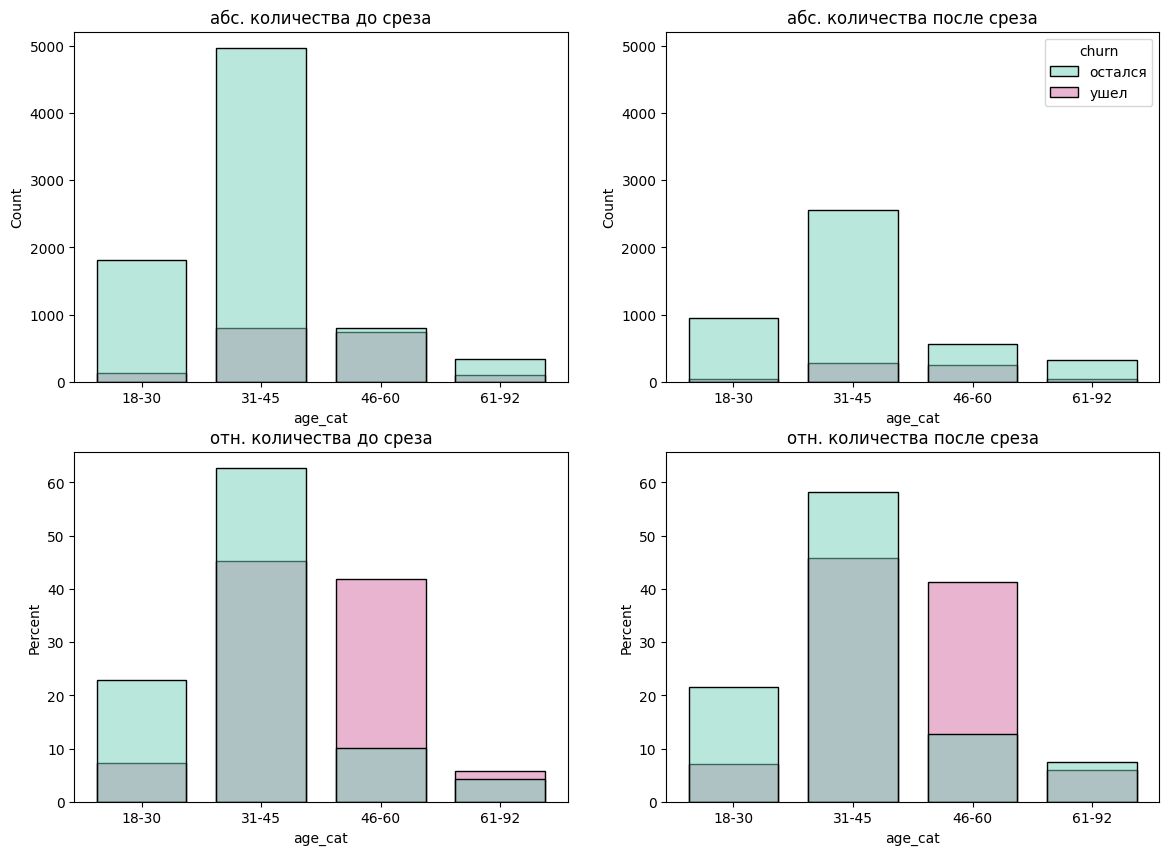

In [136]:
subplots_cat(bank_loyal, 'age_cat')

Видимых различий не наблюдается.

In [137]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'age_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

age_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0   18-30          127            44          65.0           2.89   
1   31-45          796           284          64.0           2.80   
2   46-60          734           256          65.0           2.87   
3   61-92          100            37          63.0           2.70   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1808           948          48.0           1.91         1.51  
1         4960          2556          48.0           1.94         1.44  
2          804           555          31.0           1.45         1.98  
3          345           329           5.0           1.05         2.58

Расчеты показывают, что процент ушедших во всех категориях приблизительно одинаковый (63-65%), однако оставшихся клиентов подкатегорий 46-60 и 61-92 очень низкий (31% и 5%), то есть среди них почти не было неактивных клиентов. Значит, если клиенты возраста 46-92 становятся неактивными, то с большой вероятностью они уйдут.

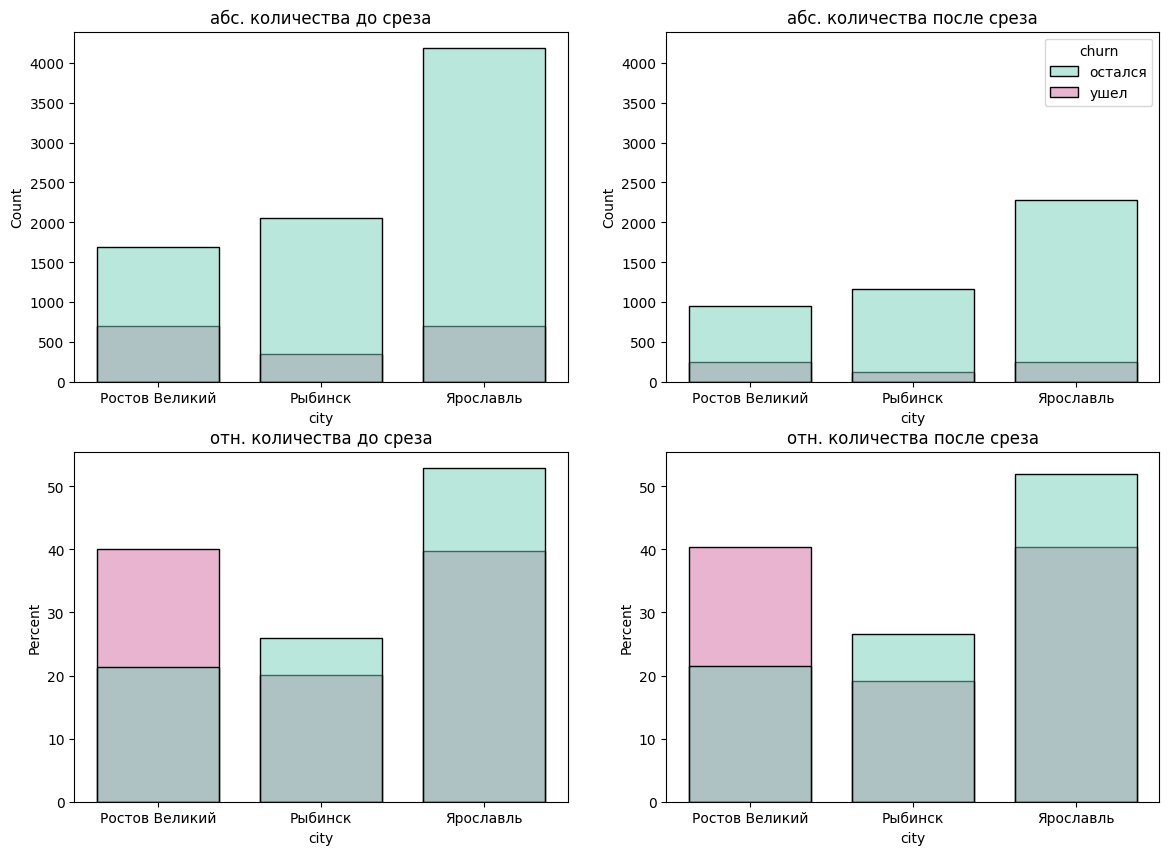

In [138]:
subplots_cat(bank_loyal, 'city')

Видимых различий не наблюдается.

In [139]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'city'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

city  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0  Ростов Великий          704           251          64.0           2.80   
1         Рыбинск          354           119          66.0           2.97   
2       Ярославль          699           251          64.0           2.78   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1685           946          44.0           1.78         1.57  
1         2050          1163          43.0           1.76         1.69  
2         4182          2279          46.0           1.84         1.52

Значимых различий нет.

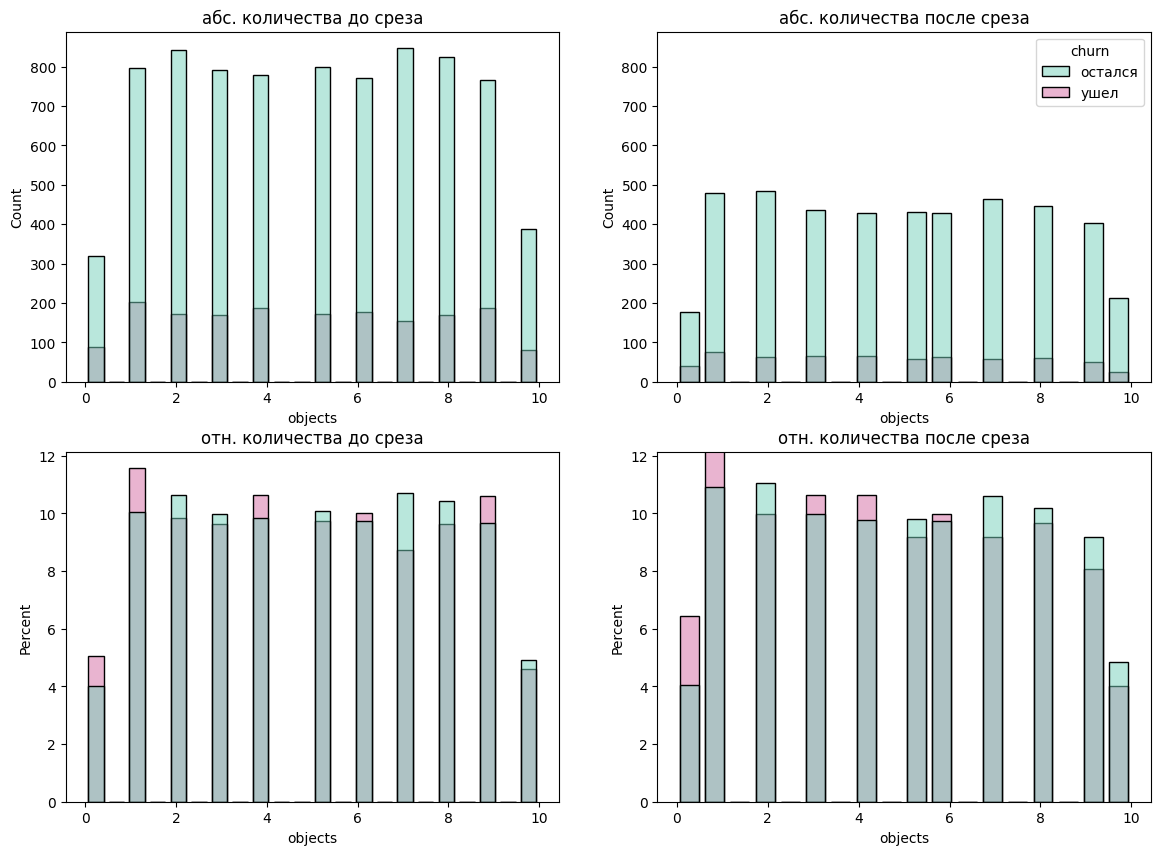

In [140]:
subplots_cat(bank_loyal, 'objects')

По количеству объектов в собственности, все значения, кроме 0 и 9 объектов сократились более-менее равномерно. Клиенты у которых  нет объектов в собственности менее склонны к уходу, у которых 9 объектов - более.

In [141]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'objects'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

objects  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         0           89            40          55.0           2.22   
1         1          203            76          63.0           2.67   
2         2          173            62          64.0           2.79   
3         3          169            66          61.0           2.56   
4         4          187            66          65.0           2.83   
5         5          171            57          67.0           3.00   
6         6          176            62          65.0           2.84   
7         7          153            57          63.0           2.68   
8         8          169            60          64.0           2.82   
9         9          186            50          73.0           3.72   
10       10           81            25          69.0           3.24   

    stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0           318           178          44.0           1.79         1.25  
1           796           478          40.0           1.67         1.60  
2           843           484          43.0           1.74         1.60  
3           790           437          45.0           1.81         1.42  
4           779           428          45.0           1.82         1.56  
5           798           430          46.0           1.86         1.62  
6           770           427          45.0           1.80         1.57  
7           846           465          45.0           1.82         1.48  
8           824           446          46.0           1.85         1.52  
9           765           402          47.0           1.90         1.95  
10          388           213          45.0           1.82         1.78

Полученные значения повторяют вывод выше - клиенты у которых нет объектов в собственности менее склонны к уходу, у которых 9 объектов - более склонны к уходу. Но закономерности здесь не наблюдается.

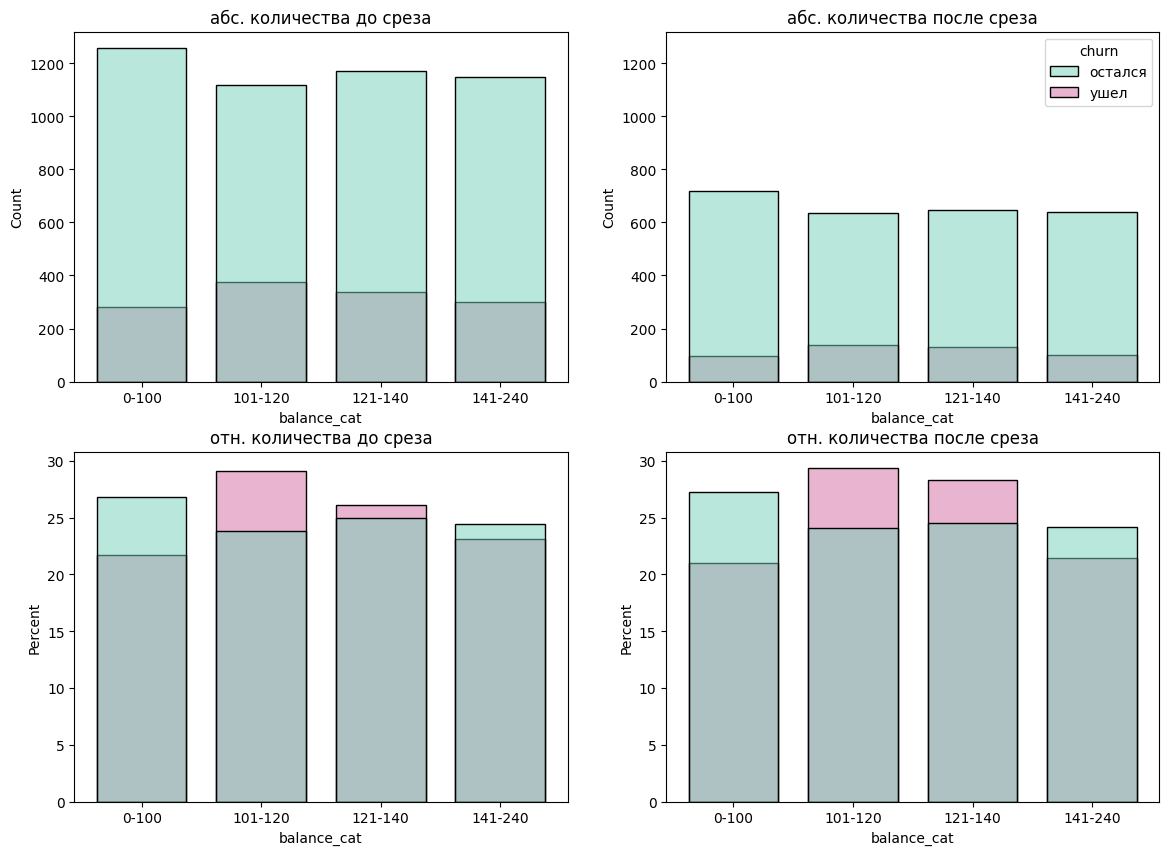

In [142]:
subplots_cat(bank_loyal, 'balance_cat')

Неактивные клиенты с балансом 0-100 и 141-240 более склонны к уходу, после среза их доля немного сократилась.

In [143]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'balance_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

balance_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-100          282            98          65.0           2.88   
1     101-120          377           137          64.0           2.75   
2     121-140          338           132          61.0           2.56   
3     141-240          300           100          67.0           3.00   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1256           718          43.0           1.75         1.64  
1         1119           636          43.0           1.76         1.56  
2         1170           646          45.0           1.81         1.41  
3         1147           638          44.0           1.80         1.67

Дополняя вывод написанный выше, неактивные клиенты с балансом 0-100 и 141-240 более склонны к уходу, с балансом 121-140 - менее.

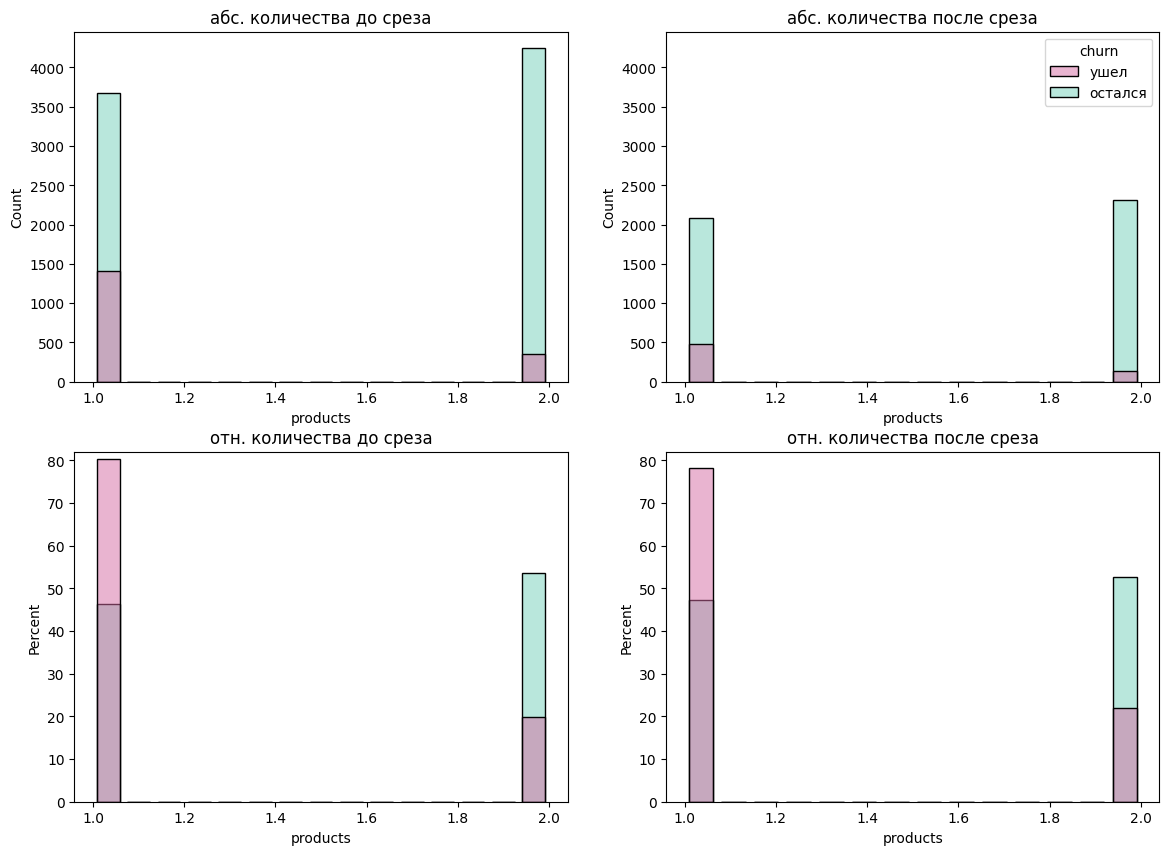

In [144]:
subplots_cat(bank_loyal, 'products')

Явнвх различий не видно, значения сократились равномерно.

In [145]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'products'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

products  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0         1         1409           485          66.0           2.91   
1         2          348           136          61.0           2.56   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         3675          2078          43.0           1.77         1.64  
1         4242          2310          46.0           1.84         1.39

Неактивные клиенты с двумя банковскими продуктами менее склонны к уходу - их ушло на 5% меньше чем неактивных клиентов с одним продуктом.

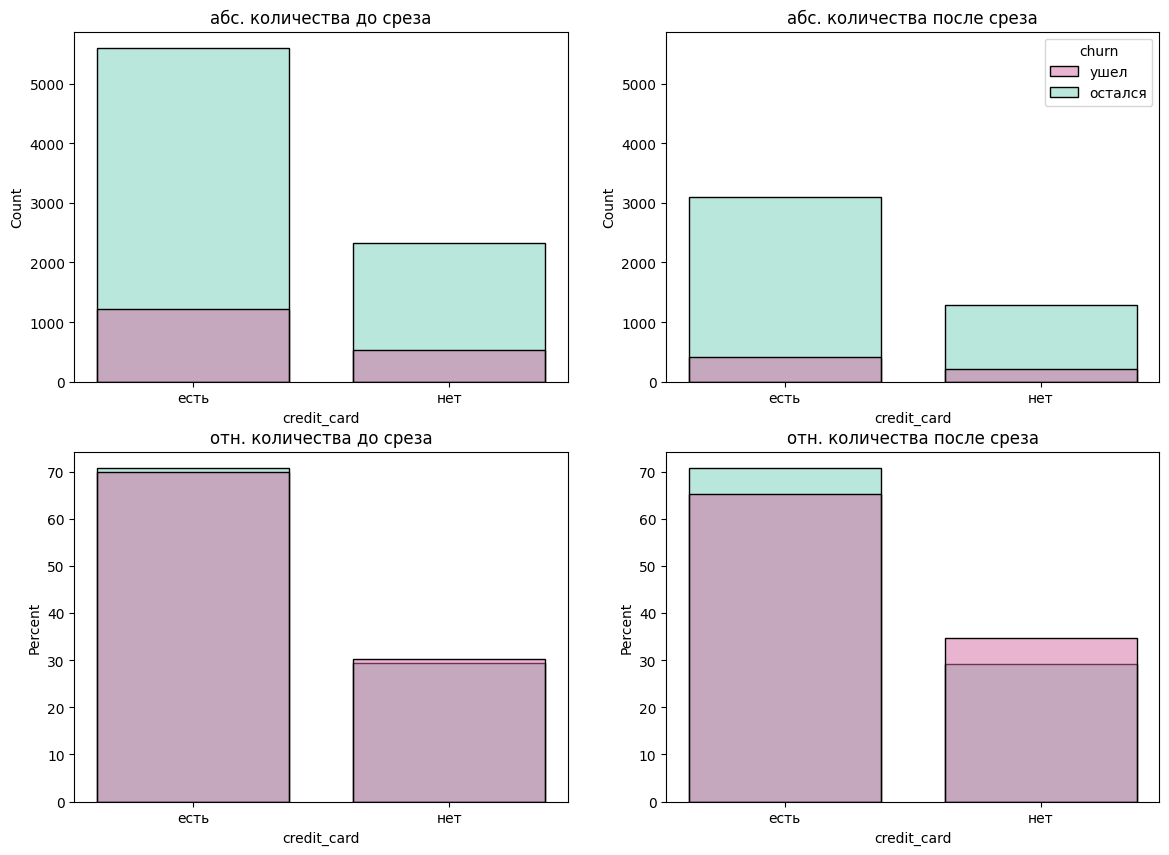

In [146]:
subplots_cat(bank_loyal, 'credit_card')

После среза доля ушедших клиентов обладающих кредитными картами снизилась, то есть эти клиенты более предрасположены к уходу, чем неактивные клиенты без кредитной карты.

In [147]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'credit_card'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

credit_card  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0        есть         1227           405          67.0           3.03   
1         нет          530           216          59.0           2.45   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         5597          3105          45.0           1.80         1.68  
1         2320          1283          45.0           1.81         1.36

Неактивные клиенты без кредитной карты менее склонны к уходу - их ушло на 8% меньше, чем неактивных клиентов с кредитной картой.

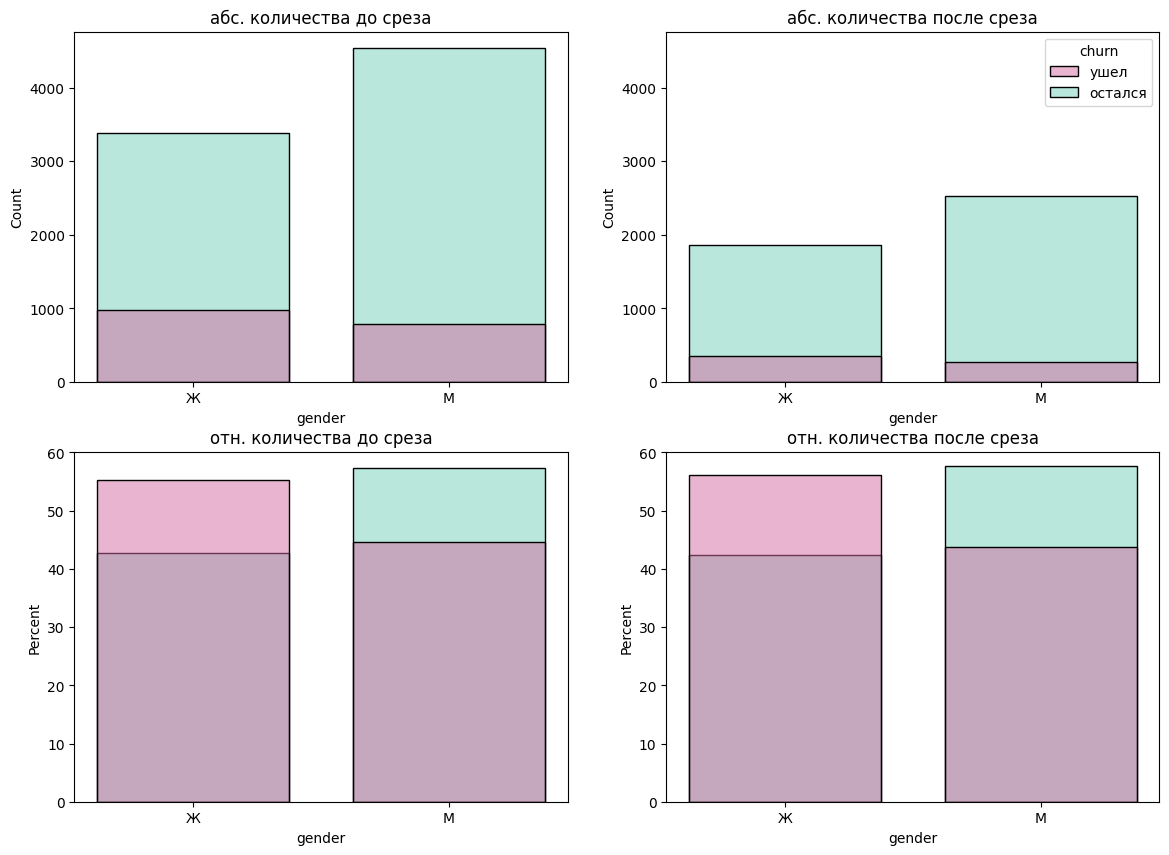

In [148]:
subplots_cat(bank_loyal, 'gender')

Значимых различий не наблюдается

In [149]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'gender'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

gender  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  stay_b4_qry  \
0      Ж          972           349          64.0           2.79         3384   
1      М          785           272          65.0           2.89         4533   

   stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0          1859          45.0           1.82         1.53  
1          2529          44.0           1.79         1.61

Значимой разницы в значениях не наблюдается, неактивные женщины и мужчины уходят равномерно.

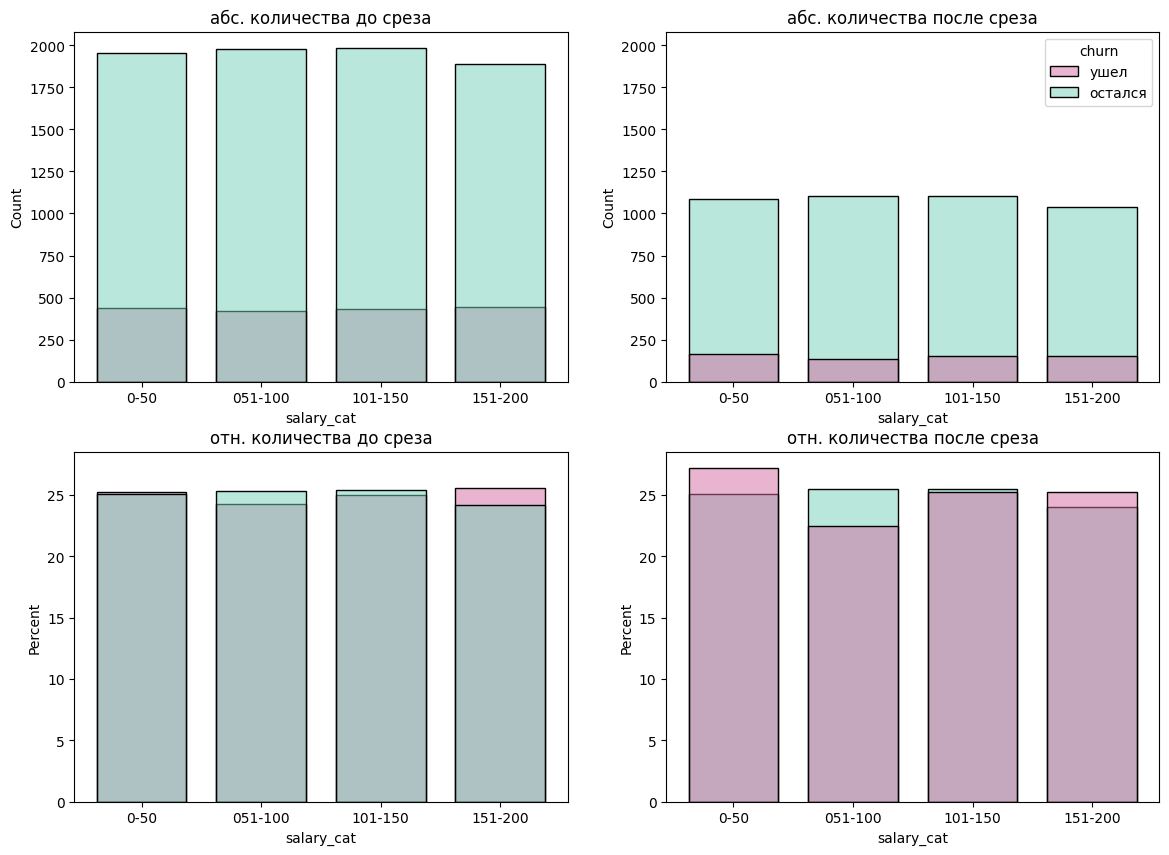

In [150]:
subplots_cat(bank_loyal, 'salary_cat')

После среза, доля клиентов с зп 0-50 повысилась (срез по активности клиентов мало на них повлиял), доля клиентов с зп 51-100 понизилась (срез по активности клиентов повлиял на них в большей мере), у остальных значимых изменений не видно.

In [151]:
display(dataset_decreased(bank, bank_loyal))
display(general_churn_decreased(bank,bank_loyal))
display(category_churn_decreased(bank, bank_loyal, 'salary_cat'))

df_dec_rate  df_dec_pct  gen_churn_coeff
values         1.93        48.0             1.57

churn  dec_rate  dec_pct
0  остался      1.80     45.0
1     ушел      2.83     65.0

salary_cat  left_b4_qry  left_aft_qry  left_dec_pct  left_dec_rate  \
0       0-50          436           166          62.0           2.63   
1    051-100          419           137          67.0           3.06   
2    101-150          431           154          64.0           2.80   
3    151-200          441           154          65.0           2.86   

   stay_b4_qry  stay_aft_qry  stay_dec_pct  stay_dec_rate  churn_coeff  
0         1955          1084          45.0           1.80         1.46  
1         1978          1102          44.0           1.79         1.70  
2         1983          1103          44.0           1.80         1.56  
3         1890          1041          45.0           1.82         1.58

Неактивные клиенты с з/п 0-50 тыс.рублей менее склонны к уходу (62% ушедших), с з/п 051-100 - более (67% ушедших).

**Вывод**

Убрав неактивных клиентов, мы сократили количество ушедших на 65%, то есть среди активных клиентов 35% ушедших. Количество оставшихся клиентов сократилось на 45%. Общий коэффициент ухода составляет 1.57, то есть отношение количества оставшихся клиентов к количеству ушедших после среза увеличилось 1.57 раз. Это дает основания полагать, что неактивные клиенты более склонны к уходу.

Внутри данного сегмента больше всего склонны к уходу:
* клиенты с низким значением скоринга (менее 475),
* клиенты возрастом от 46 до 92 лет,
* клиенты с балансом на карте 0-100 тыс.рублей и 141-200 тыс.рублей,
* клиенты с кредитной картой,
* клиенты с зарплатой 51-100 тысяч рублей.

## Формулировка и проверка гипотез

Согласно результатам полученным в исследованиях можно сформулировать следующие нулевые и альтернативные гипотезы:
1. Гипотезы о доходе:
    * H0= средний доход ушедших и оставшихся клиентов одинаковый,
    * H1= средний доход ушедших и оставшихся клиентов различный
2. Гипотезы о банковском скоринге:
    * H0= средний скоринг ушедших и оставшихся клиентов одинаковый,
    * H1= средний скоринг ушедших и оставшихся клиентов различный
3. Гипотезы о возрасте:
    * H0= доля ушедших клиентов возраста 38-65 равна доле ушедших клиентов остальных возрастов,
    * H1= доля ушедших клиентов возраста 38-65 не равна доле ушедших клиентов остальных возрастов
4. Гипотезы о гендере:
    * H0= доля ушедших женщин равна доле ушедших мужчин,
    * H1= доля ушедших женщин и доля ушедших мужчин различны
5. Гипотезы о городах:
    * H0= доля ушедших клиентов из Ростова равна доле ушедших клиентов из остальных городов,
    * H1= доля ушедших клиентов из Ростова и доля ушедших клиентов из остальных городов различны
6. Гипотезы о продуктах:
    * H0= доля ушедших клиентов с одним банковским продуктом равна доле клиентов с двумя банковскими продутами,
    * H1= доля ушедших клиентов с одним банковским продуктом и доля клиентов с двумя банковскими продутами различны
7. Гипотезы об активности:
    * H0= доля ушедших активных клиентов равна доле ушедших неактивных клиентов,
    * H1= доля ушедших активных клиентов и доля ушедших неактивных клиентов различны.

Превую и вторую гипотезы будем проверять t-тестом, сравнивая средние значения, остальные z-тестом, сравнивая доли. Напишем для этого функции

In [152]:
def t_test(x,alpha):
    
    results = st.ttest_ind(
        bank.query('churn == "остался"')[x],
        bank.query('churn == "ушел"')[x]
    )
    
    alpha = alpha
    print('p-value = ', results.pvalue)
    if results.pvalue > alpha:
        print('Не получилось отвергнуть нулевую гипотезу')
    else:
        print('Отвергаем нулевую гипотезу')

In [153]:
def z_test (x, a, alpha):

    alpha = alpha
    total_users = np.array([bank[bank[x]== a][x].count(),
                            bank[bank[x]!= a][x].count()])
    
    churn_users = np.array([bank[(bank[x]== a) & (bank['churn'] != 'ушел')][x].count(),
                            bank[(bank[x]!= a) & (bank['churn'] != 'ушел')][x].count()])

    # доля пользователей, ушедших из первой группы:
    p1 = churn_users[0]/total_users[0]

    # доля пользователей, ушедших из второй группы:
    p2 = churn_users[1]/total_users[1]

    # доля ушедших пользователей из двух групп:
    p_combined = (churn_users[0] + churn_users[1]) / (total_users[0] + total_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

**Проверка гипотез**

In [154]:
t_test('salary', 0.05)

p-value =  0.5497966808450632
Не получилось отвергнуть нулевую гипотезу


Гипотезу о равенстве дохода отвергнуть не получилось - средний доход ушедших и оставшихся клиентов одинаковый.

In [155]:
t_test('score', 0.05)

p-value =  0.011430774409005869
Отвергаем нулевую гипотезу


Гипотезу о равенстве банковского скоринга пришлось отвергнуть - средний скоринг ушедших и оставшихся клиентов различный

In [156]:
z_test('gender', 'Ж', 0.05)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезу о равенстве долей гендеров пришлось отвергнуть - доля ушедших женщин и доля ушедших мужчин различны

In [157]:
alpha= .05
total_users = np.array([bank.query('age >38 and age< 65')['user_id'].count(),
                        bank.query('age <=38 or age>= 65')['user_id'].count()])

churn_users = np.array([bank.query('(age >38 or age< 65) and churn == "ушел"')['user_id'].count(),
                        bank.query('(age <=38 or age>= 65) and churn == "ушел"')['user_id'].count()])

# доля пользователей, ушедших из первой группы:
p1 = churn_users[0]/total_users[0]

# доля пользователей, ушедших из второй группы:
p2 = churn_users[1]/total_users[1]

# доля ушедших пользователей из двух групп:
p_combined = (churn_users[0] + churn_users[1]) / (total_users[0] + total_users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезу о равенстве долей возрастных категорий пришлось отвергнуть - доля ушедших клиентов возраста 38-65 не равна доле ушедших клиентов остальных возрастов

In [158]:
z_test('city', 'Ростов Великий', 0.05)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезу о равенстве долей ушедших клиентов из различных городов пришлось отвергнуть - доля ушедших клиентов из Ростова и доля ушедших клиентов из остальных городов различны

In [159]:
z_test('products', 1, 0.05)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезу о равенстве долей ушедших клиентов с различными бановскими продуктами пришлось отвергнуть - доля ушедших клиентов с одним банковским продуктом и доля клиентов с двумя банковскими продутами различны

In [160]:
z_test('loyalty', 'активный', 0.05)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезу о равенстве долей ушедших клиентов с различной активностью пришлось отвергнуть - доля ушедших активных клиентов и доля ушедших неактивных клиентов различны.

## Выводы

По результатам исследования ушедших и оставшихся клиентов можно сделать следующие выводы:

1. при значениях скоринга (столбец `score`) менее 405, нет ни одного оставшегося клиента. Вероятно, клиенты с низкими значениями скоринга более склонны к уходу, чем с высокими значениями   
    * *более 80% клиентов с низким скорингом пользуются кредитной картой, у 95% заработная плата выше 50 тыс.руб., 70% из них были неактивны в течение последнего месяца и 80% обладают всего одним банковским продуктом.*
    
    
2. в Ростове Великом наблюдается больше ушедших клиентов, чем в остальных городах;
3. ушедших женщин на 20% больше, чем мужчин;
4. ушедших неактивных клиентов на 30% больше, чем активных;
5. большое количество ушедших клиентов в возрасте от 38 до 65 лет;
6. клиентов с 3 и 4 продуктами почти не осталось (среди клиентов, использующих три банковских продукта всего 46 клиентов остались и 220 клиентов ушло, среди клиентов, использующих четыре банковских продукта нет ни одного оставшегося клиента). Стоит уделить им внимание, разобраться почему они ушли. Возможно у них были проблемы в обслуживании, изменились условия пользования продуктом, либо возникали технические неполадки при использовании продуктом. Сделать вывод по имеющимся данным нельзя, но это определенно сегмент, склонный к уходу;
7. по количеству используемых продуктов, среди ушедших, 80% пользовались всего одним продуктом. Среди оставшихся клиентов почти поровну - 45% - один продукт, 55% - два продукта.

Обобщая, **склонные к уходу сегменты** - клиенты с низкими значениями скоринга, клиенты с 3 и 4 банковскими продуктами. **Предполагаемые сегменты, склонные к уходу** - клиенты из Ростова, женщины, неактивные клиенты, клиенты в возрасте 38-65 лет,  и, клиенты с 1 банковским продуктом.

Расчетная проверка, является ли предполагаемый сегмент отточным и как он связан с другими категориями, показала следующие результаты:

1. Клиенты, чей возраст находится в интервале **38-65 лет**, является отточным сегментом (72% ушедших от общего количества, 34% оставшихся от общего количества). Внутри данного сегмента более всего склонны к уходу следующие категории:   
    * клиенты с низким скорингом,
    * клиенты из Ярославля и Ростова,
    * клиенты с балансом на счету от 0 до 100 тыс.руб.,
    * клиенты, владеющие одним банковским продуктом,
    * клиенты без кредитной карты,
    * неактивные клиенты


2. Клиенты из **Ростова Великого** (количество ушедших сократилось на 40%, оставшихся на 21%). Внутри данного сегмента больше всего склонны к уходу:
    * клиенты с высокими значениями скоринга (более 725),
    * клиенты с балансом на счету в интервале 101-140 тыс. рублей,
    * клиенты обладающие одним банковским продуктом,
    * клиенты с зарплатой в интервале 0-100 тыс.рублей.


3. **Женщины** (количество оставшихся сократилось на 43% , а ушедших на 55%). Внутри данного сегмента больше всего склонны к уходу:
    * женщины с высокими значениями банковского скоринга (больше 600),
    * женщины возраста 18-30 лет,
    * женщины из Ярославля,
    * женщины с балансом на счету в интеовале 0-100 тыс. рублей,
    * женщины, обладающие двумя банковскими продуктами,
    * женщины с зарплатой более 100 тысяч рублей.


4. Клиенты с **одним банковским продуктом** (количество ушедших сократилось на 80%, оставшихся на 46%). Внутри данного сегмента больше всего склонны к уходу:
    * клиенты в возрасте 46-60 лет,
    * клиенты из Ростова и Ярославля,
    * мужчины,
    * клиенты с кредитной картой,
    * неактивные клиенты,
    * клиенты с зарплатой в интервале 0-50 тыс.рублей и 151-200 тыс.рублей.
    
    
5. **Неактивные** клиенты (количество ушедших сократилось на 65%, оставшихся на 45%). Внутри данного сегмента больше всего склонны к уходу:
    * клиенты с низким значением скоринга (менее 475),
    * клиенты возрастом от 46 до 92 лет,
    * клиенты с балансом на карте 0-100 тыс.рублей и 141-200 тыс.рублей,
    * клиенты с кредитной картой,
    * клиенты с зарплатой 51-100 тысяч рублей.


Проверка стастистических гипотез показала следующее:
* Гипотезу о равенстве дохода отвергнуть не получилось - средний доход ушедших и оставшихся клиентов одинаковый.
* Гипотезу о равенстве банковского скоринга пришлось отвергнуть - средний скоринг ушедших и оставшихся клиентов различный
* Гипотезу о равенстве долей гендеров пришлось отвергнуть - доля ушедших женщин и доля ушедших мужчин различны
* Гипотезу о равенстве долей возрастных категорий пришлось отвергнуть - доля ушедших клиентов возраста 38-65 не равна доле ушедших клиентов остальных возрастов
* Гипотезу о равенстве долей ушедших клиентов из различных городов пришлось отвергнуть - доля ушедших клиентов из Ростова и доля ушедших клиентов из остальных городов различны
* Гипотезу о равенстве долей ушедших клиентов с различными бановскими продуктами пришлось отвергнуть - доля ушедших клиентов с одним банковским продуктом и доля клиентов с двумя банковскими продутами различны
* Гипотезу о равенстве долей ушедших клиентов с различной активностью пришлось отвергнуть - доля ушедших активных клиентов и доля ушедших неактивных клиентов различны.

Рекомендации:
* **Разобраться с пропущенными значениями в балансе на счету клиента**. 
     * Недоступный баланс есть только в городах Рыбинск и Ярославль, клиенты с недоступным балансом распределены равномерно по всем категориям, кроме количества продуктов (среди клиентов с одним продуктом - у 25% баланс неизвестен, с двумя продуктами - у 75%), то, вероятнее всего имеет место быть какая то техническая ошибка связанная с продуктом и локацией;

* **Обратить внимание на банковские продукты**. 
     * Среди клиентов, использующих три банковских продукта всего 83% клиентов ушло. Среди клиентов, использующих четыре банковских продукта нет ни одного оставшегося клиента. Стоит уделить им внимание, разобраться почему они ушли. Возможно у них были проблемы в обслуживании, изменились условия пользования продуктом, либо возникали технические неполадки при использовании продуктом.


## Доп. материалы

Ссылка на презентацию:
https://drive.google.com/file/d/1B7WFYqNYaMO5Exsb5MNuq5Som7JrVo4I/view?usp=sharing